# Exploratory analysis of BoligPortal data

In this notebook, we import the already clean and nicely formatted data on accommodations listed on the BoligPortal website and take a look at some basic descriptive statistics and correlations. This information is presented mostly in the form of charts and tables and is then used as an inspiration for defining hypotheses for further, more sophisticated analyses.

## User input for the analysis

In [ ]:
"""
====================
Providing user input
====================
"""

# Defining file storage location: either "Drive" or "Local"
FileStorageForUse = "Drive"

# If using Google Drive, specify project folder
ProjectFolder = "Projects/IT/BoligPortal insights/"

## Setting things up

We start out by importing all relevant packages for our work and by defining some custom functions that will help us extract the data that we need.

In [ ]:
import datetime as dt
Today = dt.date.today()
print("This notebook was last updated on:", Today)
print("Author: Kiril Boyanov (kirilboyanovbg@gmail.com)")
print("Connect on LinkedIn: https://www.linkedin.com/in/kirilboyanov/")

This notebook was last updated on: 2023-03-03
Author: Kiril Boyanov (kirilboyanovbg@gmail.com)
Connect on LinkedIn: https://www.linkedin.com/in/kirilboyanov/


In [ ]:
# Importing relevant packages
import pandas as pd
import pandas.tseries.offsets as offset
import datetime as dt
import numpy as np

# Specifically used for data visualisation
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import gridspec
import plotly.express as px

# Setting custom chart size & related other properties
# sns.set(rc = {"figure.figsize":(4, 3)})
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300

# Setting custom theme for  plots
DefaultColormapQual = "Set2"
sns.color_palette("Set2", as_cmap = True)
ColorPalette = sns.color_palette("Set2")
ColorPalette.as_hex()

# Setting custom limits for maximum N of rows/cols to print in data previews
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
"""
=======================================
Arranging data storage for the analysis
=======================================
"""

# Creating a universal folder reference to use regardless of chosen storage method
if FileStorageForUse == "Local":
  import os
  AnalysisFolder = os.getcwd() + "/"
  print("The analysis will be run using local data storage.")
  print("The data will be saved in the following directory:")
  print(AnalysisFolder)
elif FileStorageForUse == "Drive":
  from google.colab import drive
  drive.mount('/content/gdrive/', force_remount = True)
  AnalysisFolder = "/content/gdrive/MyDrive/" + ProjectFolder
  print("The analysis will be run using Google Drive for data storage.")
  print("The data will be saved in the following directory:")
  print(AnalysisFolder)
else:
  print("Incorrect output, please check the '' input before proceeding.")

Mounted at /content/gdrive/
The analysis will be run using Google Drive for data storage.
The data will be saved in the following directory:
/content/gdrive/MyDrive/Projects/IT/BoligPortal insights/


In [ ]:
"""
=======================================================
Custom function that plots data labels on seaborn plots
=======================================================
"""

def ShowValuesOnBars(axs, fontsize = 8):
    
    from matplotlib import pyplot as plt
    import numpy as np
    
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontsize = fontsize) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [ ]:
"""
==================================================================
Custom function that plots data labels on pandas 100% stacked bars
==================================================================
"""

def ShowValuesPandas(df):
  for ix, row in df.reset_index(drop=True).iterrows():
    cumulative = 0
    for element in row:
        if element > 0.1:
            plt.text(
                ix,
                cumulative + element / 2,
                f"{int(element * 100)} %",
                va="center",
                ha="center",
            )
        cumulative += element

In [ ]:
"""
===========================================================
Custom function that hides border lines for PLT chart areas
===========================================================
"""

def HideBorders(ax):
  for x in ["top", "bottom", "left", "right"]:
    ax.spines[x].set_visible(False)

In [ ]:
"""
=========================================
Custom function to add labels to boxplots
=========================================

Source: https://stackoverflow.com/questions/38649501/labeling-boxplot-in-seaborn-with-median-value
"""

def AddMedianLabels(ax, fmt = ".1f"):
  import seaborn as sns
  import matplotlib.pyplot as plt
  import matplotlib.patheffects as path_effects

  lines = ax.get_lines()
  boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
  lines_per_box = int(len(lines) / len(boxes))

  for median in lines[4:len(lines):lines_per_box]:
      x, y = (data.mean() for data in median.get_data())
      # choose value depending on horizontal or vertical plot orientation
      value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
      text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center', color='white')
      # create median-colored border around white text for contrast
      text.set_path_effects([
          path_effects.Stroke(linewidth=1, foreground=median.get_color()),
          path_effects.Normal(),
      ])

In [ ]:
"""
=========================================================
Custom function to display regplots with hue side-by-side
=========================================================

From: https://stackoverflow.com/questions/33049884/how-to-plot-2-seaborn-lmplots-side-by-side
"""

def HueRegplot(data, x, y, hue, palette=None, **kwargs):

    """
    This function expands the capabilities of seaborn's regplot by allowing us
    to use lmplot-like "hue" to plot regression lines by a third variable while
    preserving regplot's capability of plotting multiple charts side-by-side
    using plt.subplots and axes.
    """

    from matplotlib.cm import get_cmap
    
    regplots = []
    
    levels = data[hue].unique()
    
    if palette is None:
        default_colors = get_cmap(DefaultColormapQual)
        palette = {k: default_colors(i) for i, k in enumerate(levels)}
    
    for key in levels:
        regplots.append(
            sns.regplot(
                x=x,
                y=y,
                data=data[data[hue] == key],
                color=palette[key],
                **kwargs
            )
        )
    
    return regplots

## Importing relevant data

Below, we import data that we've already processed in other notebooks and that's already been cleaned and put together in a format which makes it suitable for doing further analysis.

This includes both data on accommodations listed and landlords (`Accommodations`) and data on geographic objects of interest (e.g. stores, metro/train stops, important locations in the city like Nørreport etc.).

In [ ]:
# Importing data related to accommodations & landlords
# Accommodations = pd.read_pickle(AnalysisFolder + "Data/Accommodations.pkl") # disabled as diff Python version may prompt errors
Accommodations = pd.read_excel(AnalysisFolder + "Data/Accommodations.xlsx")

## Descriptive statistics

We start out by briefly exploring the summary statistics (mean, standard deviation, etc.) for quantitative variables. In addition to the standard summary stats available in the `pandas` package, we also add an indicator of the % of missing observations in the data.

Please note that variables for which we have 90%+ missing observations are automatically excluded from the subsequent analysis and previews.

In [ ]:
# Calculating general summary statistics
SummaryStats = Accommodations.describe().transpose()

# Removing columns from the summary stats
SummaryStats.drop(columns = ["25%", "50%", "75%"], inplace = True)

# Removing rows that we don't want to focus on
IrrelevantVars = ["PageID"]
SummaryStats = SummaryStats[~SummaryStats.index.isin(IrrelevantVars)].copy()

# Calculating the N of observations with missing data
ObsWithMissingData = []
TotalObs = len(Accommodations)

for var in SummaryStats.index:
  NumberOfMissingValues = Accommodations[var].isna().sum()
  ObsWithMissingData.append(NumberOfMissingValues)

# Calculating the % of observations with missing data
SummaryStats["missing (N)"] = ObsWithMissingData
SummaryStats["missing (%)"] = np.round((SummaryStats["missing (N)"]/TotalObs) * 100, 1)
SummaryStats.drop(columns = ["missing (N)"], inplace = True)

# Sorting the data with the ones with fewest missing values on top
SummaryStats.sort_values(["missing (%)"], inplace = True)

# Removing variables which have 90%+ missing observations
SummaryStats = SummaryStats[SummaryStats["missing (%)"] < 90].copy()

# Previewing the data
SummaryStats.round(1)

count       mean       std       min  \
EntryID                             3036.0  5211750.7  364203.4  821833.0   
PostCode                            3035.0     2440.7     396.8    1001.0   
Latitude                            3035.0       55.7       0.0      55.6   
Longitude                           3035.0       12.5       0.1      12.2   
SuitableForElderly                  3034.0        0.3       0.4       0.0   
SizeSquareMeters                    3034.0       83.2      45.3       7.0   
NumberOfRooms                       3034.0        2.7       1.3       1.0   
MovingInPriceBySqM                  3034.0      864.5     367.1      96.2   
AvailableFromASAP                   3034.0        0.5       0.5       0.0   
MonthlyRentBySqM                    3034.0      196.6      97.2      67.3   
MonthlyFixedPayment                 3034.0    14895.3    8017.7    2495.0   
CaseNumber                          3034.0  5211806.8  364292.3  821833.0   
MonthlyFixedPaymentBySqM            3034.0      208.5     102.5      67.3   
MonthlyFixedPaymentByNumberOfRooms  3034.0     5816.2    2341.8    1724.2   
DepositBySqM                        3032.0      488.6     217.8       0.0   
DepositByNumberOfRooms              3032.0    14196.6    6849.5       0.0   
MonthlyRentByNumberOfRooms          3034.0     5478.3    2241.2    1479.2   
Parking                             3034.0        0.4       0.5       0.0   
MovingInPriceByNumberOfRooms        3034.0    24894.0   11242.2    2500.0   
Furnished                           3034.0        0.2       0.4       0.0   
Elevator                            3034.0        0.6       0.5       0.0   
Deposit                             3032.0    37649.0   23178.9       0.0   
SuitableForSharing                  3034.0        0.3       0.4       0.0   
MovingInPrice                       3034.0    65052.7   37533.2    3500.0   
BikeParking                         3034.0        0.0       0.1       0.0   
PetsAllowed                         3034.0        0.4       0.5       0.0   
StudentsOnly                        3034.0        0.0       0.2       0.0   
MonthlyRent                         3034.0    14034.0    7725.2    2495.0   
BalconyOrTerrace                    3034.0        0.6       0.5       0.0   
Aconto                              2888.0      904.9     802.2       0.0   
AcontoByNumberOfRooms               2888.0      354.9     446.1       0.0   
AcontoBySqM                         2888.0       12.4      25.6       0.0   
PrepaidRentBySqM                    2868.0      177.1     150.8       0.0   
PrepaidRentByNumberOfRooms          2868.0     5158.1    4214.8       0.0   
PrepaidRent                         2868.0    13233.0   12246.5       0.0   
Floor                               2676.0        2.5       2.9      -1.0   

                                          max  missing (%)  
EntryID                             5339412.0          0.0  
PostCode                               3500.0          0.0  
Latitude                                 55.9          0.0  
Longitude                                12.7          0.0  
SuitableForElderly                        1.0          0.1  
SizeSquareMeters                        474.0          0.1  
NumberOfRooms                            10.0          0.1  
MovingInPriceBySqM                     4111.1          0.1  
AvailableFromASAP                         1.0          0.1  
MonthlyRentBySqM                        894.1          0.1  
MonthlyFixedPayment                  136000.0          0.1  
CaseNumber                          5339412.0          0.1  
MonthlyFixedPaymentBySqM               1633.3          0.1  
MonthlyFixedPaymentByNumberOfRooms    29800.0          0.1  
DepositBySqM                           2500.0          0.1  
DepositByNumberOfRooms                84600.0          0.1  
MonthlyRentByNumberOfRooms            28200.0          0.1  
Parking                                   1.0          0.1  
MovingInPriceByNumberOfRooms

### Notes on looking at rent, deposit etc.

When we take an explorative look at data that is related to prices, we often adjust these prices by both the number of square meters and the number of rooms in order to account for price differences which are simply resulting because of different sizes.

## Exploring the characterstics of the accommodations available

Below, we take a look at various characteristics of the accommodations available, e.g. sizes, number of rooms, whether there is parking space, whether pets are allowed etc.

### What kind of accommodations are available?

The doughnut chart below shows the split of the accommodation on offer by type (e.g. apartments vs. houses).

**The figure below gives us the following insights:**

* The majority of the accommodations listed are of the 'Apartment' type, which accounts for 82% of all listed accommodations.
* The least common type of accommodation listed is 'Semi-detached house', which accounts for only 3% of all available accommodations.

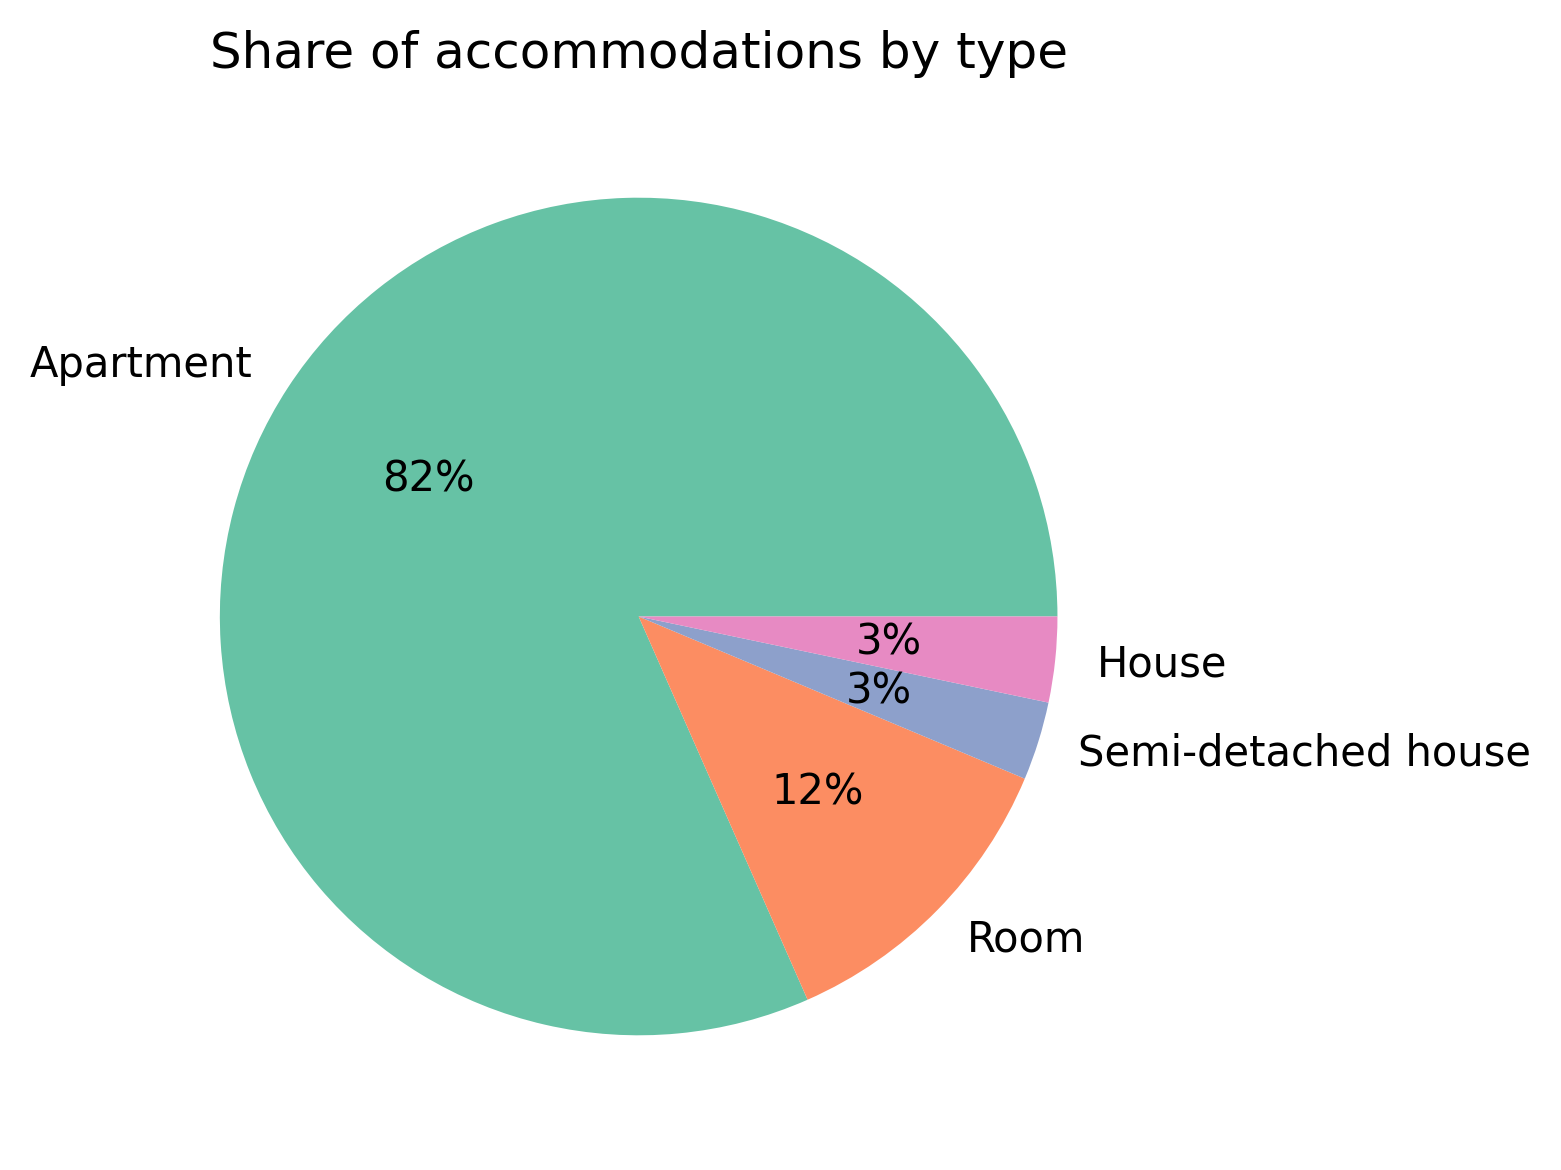

In [ ]:
# Preparing summarized data
SummaryData = Accommodations.copy()
SummaryData = SummaryData[SummaryData["AccommodationType"].notna()].copy()
SummaryData["NumberOfListings"] = SummaryData.groupby(["AccommodationType"])["Link"].transform("nunique")
SummaryData.drop_duplicates(subset = ["AccommodationType"], inplace = True)

# Making and displaying a chart
plt.pie(SummaryData["NumberOfListings"], labels = SummaryData["AccommodationType"], colors = ColorPalette, autopct = '%.0f%%')
plt.title("Share of accommodations by type")
plt.tight_layout()
plt.show()

### How does the type of accommodation offerings differ by location?

In here, we explore how the proportions of different accommodation types differ depending on whether they are located in the city or in the suburbs. 

**The figure below gives us the following insights:**

* The majority of both apartments (52%) and houses (92%) for rent are located in the suburbs, with houses being significantly less common to find in the city (8%) than apartments (48%).
* Only about a third (33%) of all rooms for rent are located in the suburbs, with the majority being found in the city.

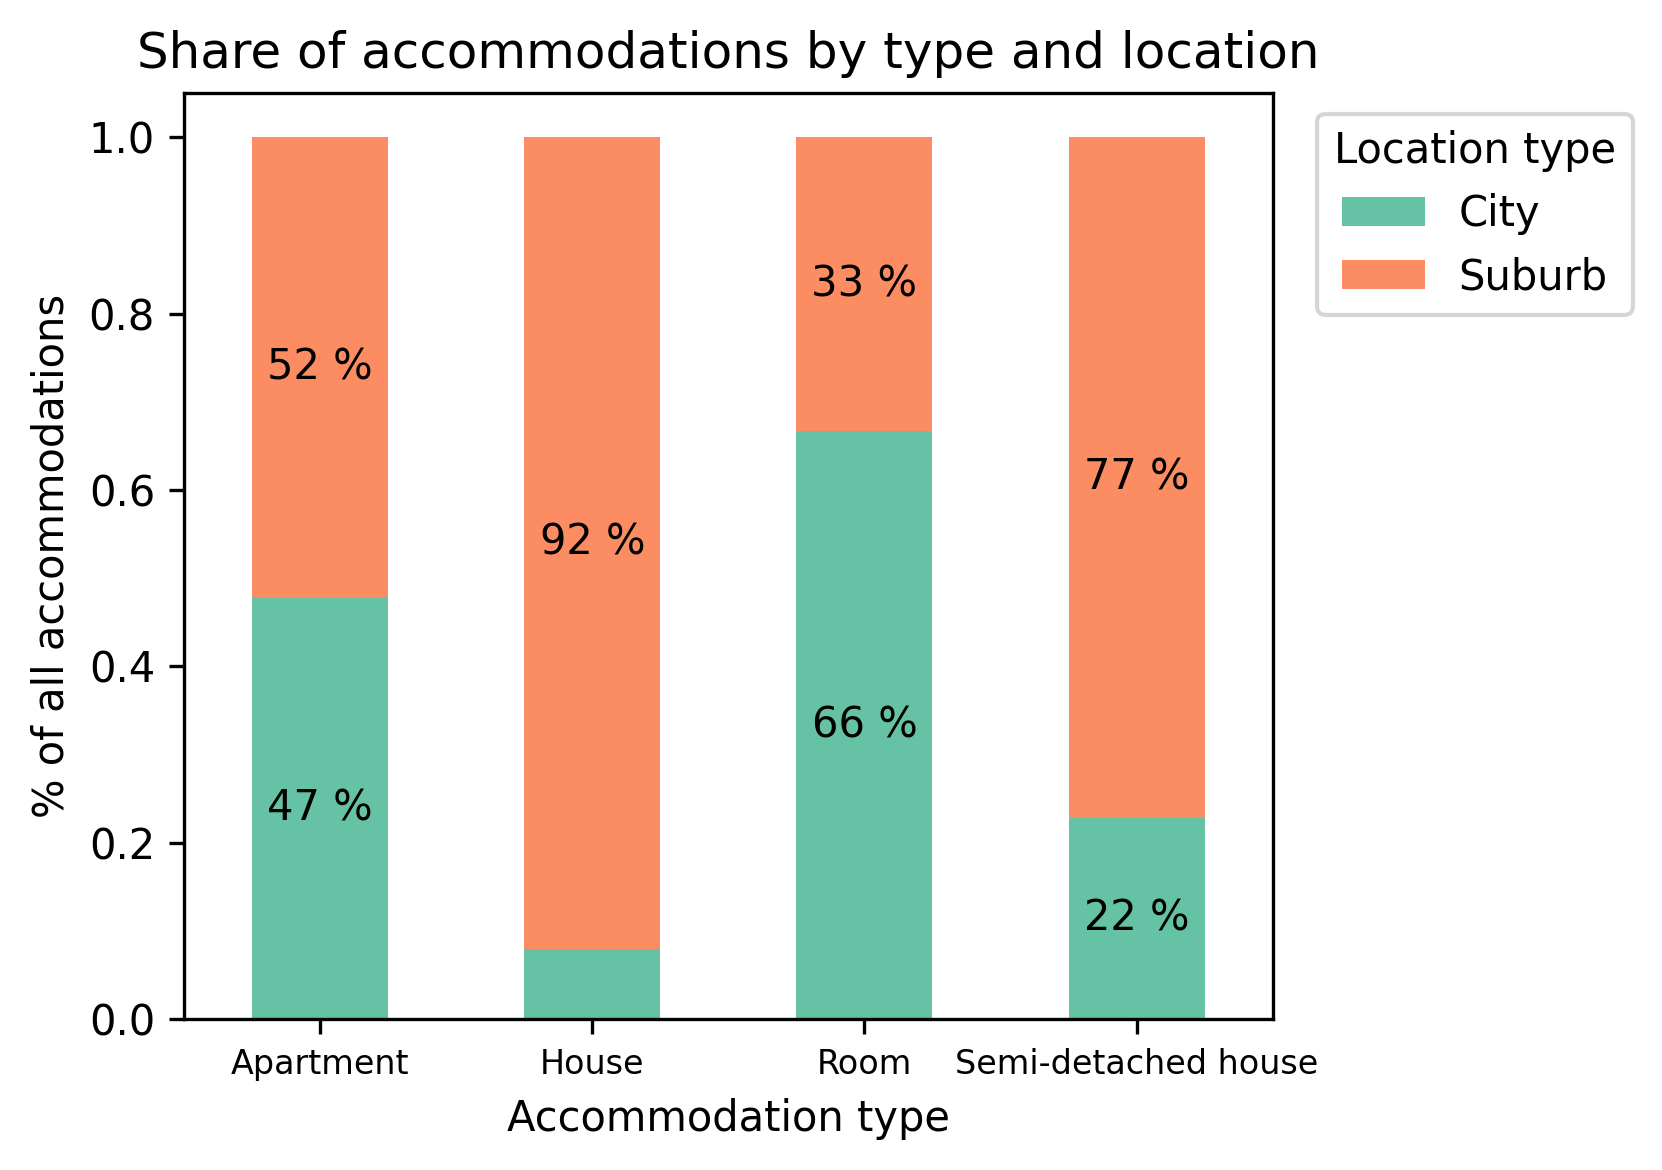

In [ ]:
# Preparing summarized data
x_var, y_var = "AccommodationType", "LocationType"
SummaryData = Accommodations.copy()
SummaryData = SummaryData[(SummaryData["AccommodationType"].notna()) & (SummaryData["LocationType"].notna())].copy()
SummaryData = Accommodations.groupby(x_var)[y_var].value_counts(normalize = True).unstack(y_var)

# Defining custom colors for charts made using pandas
CustomColors = {"City":"#66C2A5", "Suburb":"#FC8D62"}

# Making and displaying a chart
ax = plt.gca()
fig = SummaryData.plot.bar(stacked = True, color = CustomColors, ax = ax)

# Adding labels to the chart and adjusting chart properties
ShowValuesPandas(SummaryData)
plt.title("Share of accommodations by type and location")
plt.xlabel("Accommodation type")
plt.ylabel("% of all accommodations")
plt.xticks(fontsize = 8, wrap = True, rotation = 0)
legend = plt.legend(loc = "upper right", title = "Location type")
plt.legend(title = "Location type", loc = "upper right", bbox_to_anchor = (1.35, 1))

plt.tight_layout()
plt.show()

### What is the geographical distribution of accommodations?

Below, we examine the overall distribution of all available accommodations on a map of the Greater Copenhagen area. In this way, we can get a sense of where we can find something for rent as well as see where there are clusters of available accommodations.

First, we take a look at a combined chart that shows all accommodations available regardless of their type. After that, we take a look at the distribution of apartments and houses only.

**The three figures below give us the following insights:**

* The number of accommodations available increases the closer we get to the "heart" of Copenhagen, with some external clusters close to Taastrup, Hedehusene and Brøndby Strand.
* Apartments, representing 82% of all available accommodation listings, have the same roughy distribution as all accommodations in general, meaning they are also relatively equally distributed, though with more apartments being available in the more central parts of the city.
* Houses have a very different geographical distribution, with no listings in most parts of the city (and especially not within the city center), though with some local clusters located to the north of Copenhagen: Bagsværd, Jægersborg and Skodsborg among others.

Thus, if you would like to rent an apartment, you have a much wider choice in terms of where you can find one relative to finding a house for rent. This is consistent with our previous conclusion that 92% of all houses are located in the suburbs, while only 52% of all apartments are located in the suburbs.

In [ ]:
# Preparing data for chart
DataForChart = Accommodations.copy()
DataForChart = DataForChart[(DataForChart["Latitude"].notna()) & (DataForChart["Longitude"].notna())].copy()
DataForChart["Number of listings"] = DataForChart.groupby(["Latitude", "Longitude"])["Link"].transform("nunique")
DataForChart.drop_duplicates(subset = ["Latitude", "Longitude"], inplace = True)

# Preparing and displaying the chart
Chart = px.density_mapbox(DataForChart, lat = "Latitude", lon = "Longitude", z = "Number of listings",
                        mapbox_style = "carto-positron", color_continuous_scale = "Spectral", opacity = 0.5)
Chart

#### Geographical distribution of apartments

In [ ]:
# Selected accommodation type
UserSelection = "Apartment"

# Preparing data for chart
DataForChart = Accommodations[Accommodations["AccommodationType"] == UserSelection].copy()
DataForChart = DataForChart[(DataForChart["Latitude"].notna()) & (DataForChart["Longitude"].notna())].copy()
DataForChart["Number of listings"] = DataForChart.groupby(["Latitude", "Longitude"])["Link"].transform("nunique")
DataForChart.drop_duplicates(subset = ["Latitude", "Longitude"], inplace = True)

# Preparing and displaying the chart
Chart = px.density_mapbox(DataForChart, lat = "Latitude", lon = "Longitude", z = "Number of listings",
                        mapbox_style = "carto-positron", color_continuous_scale = "Spectral", opacity = 0.5)
Chart

#### Geographical distribution of houses

In [ ]:
# Selected accommodation type
UserSelection = "House"

# Preparing data for chart
DataForChart = Accommodations[Accommodations["AccommodationType"] == UserSelection].copy()
DataForChart = DataForChart[(DataForChart["Latitude"].notna()) & (DataForChart["Longitude"].notna())].copy()
DataForChart["Number of listings"] = DataForChart.groupby(["Latitude", "Longitude"])["Link"].transform("nunique")
DataForChart.drop_duplicates(subset = ["Latitude", "Longitude"], inplace = True)

# Preparing and displaying the chart
Chart = px.density_mapbox(DataForChart, lat = "Latitude", lon = "Longitude", z = "Number of listings",
                        mapbox_style = "carto-positron", color_continuous_scale = "Spectral", opacity = 0.5)
Chart

### How many rooms do accommodation listings typically have?

Below, we take a look at the distribution of number of rooms for different kinds of accommodations as well as for all available accommodations in general. The insights are presented using boxplots, which make it possible to do comparison across different types of accommodation.

**The figure below gives us the following insights:**

* With a median of 3, apartments have a lower number of rooms than both houses (median of 5) and semi-detached houses (median of 4). Rooms are (of course) only characterized by having 1 room, except for some obvious outliers.
* While apartments may have up to 8 rooms, 75% of all apartments only have 4 or fewer rooms. A similar observation can be made for houses, where 75% of them have up to 6 rooms, though some may have up to 10 rooms. Semi-detached houses lie somewhere in the middle between apartments and regular houses.

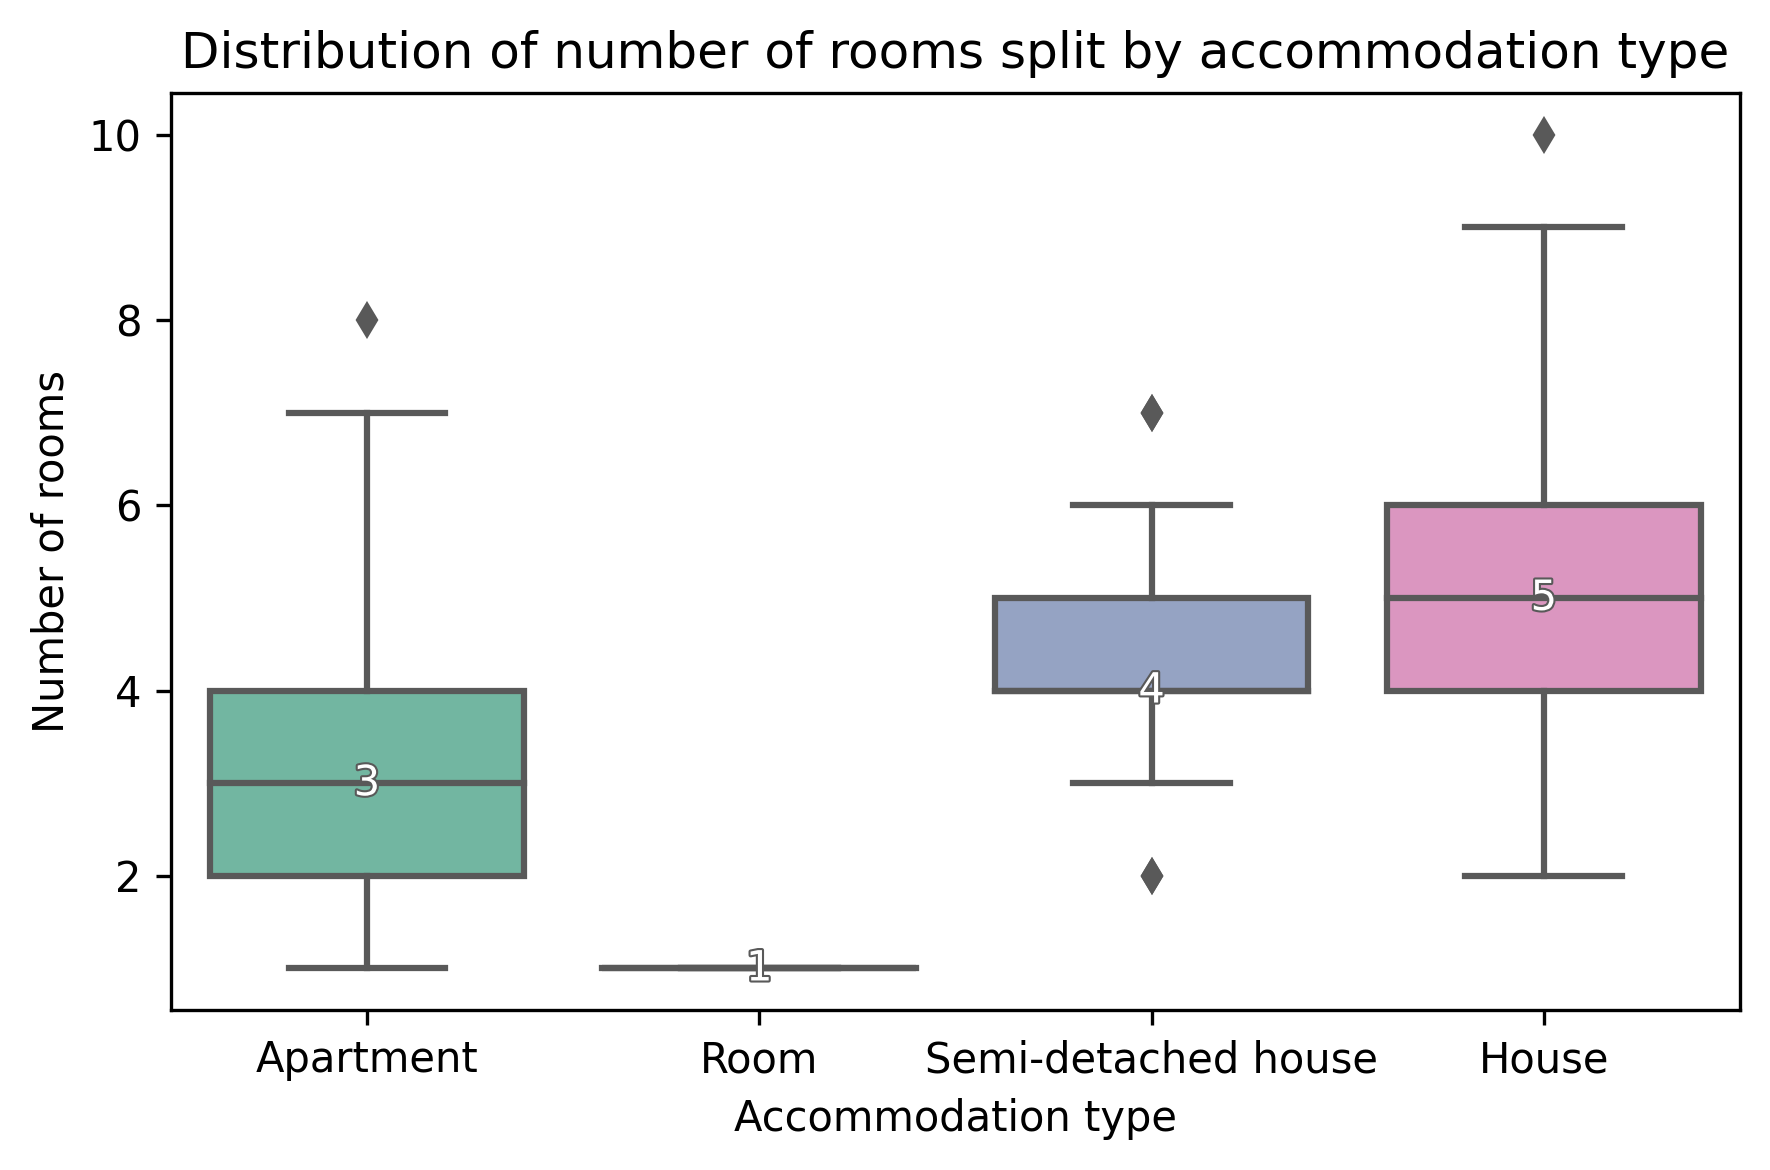

In [ ]:
# Making and displaying a chart
Chart = sns.boxplot(data = Accommodations, x = "AccommodationType", y = "NumberOfRooms", palette = ColorPalette)
DataForChart = DataForChart[(DataForChart["AccommodationType"].notna()) & (DataForChart["NumberOfRooms"].notna())].copy()
plt.title("Distribution of number of rooms split by accommodation type")
plt.xlabel("Accommodation type")
plt.ylabel("Number of rooms")

AddMedianLabels(Chart, fmt = ".0f")
plt.tight_layout()
plt.show()

### How often are pets allowed in the accommodations?

Below, we present four different views of whether pets are allowed or not. First, we take a very general look. Then, we examine whether the permission of pets varies by different factors, including accommodation type, location and whether the accommodation is furnished or not.

**The four figures below give us the following insights:**

* Overall, pets are not allowed in more than half of all available accommodations (58%).
* Pets are least likely to be allowed in single rooms for rent (5% likely) and most likely to be allowed in semi-detached houses (64%). Less than half of all available apartments (47%) allow pets.
* In geographical terms, pets are almost twice as likely to be allowed in the suburbs (51% of all listings) than they are in the city (32%).
* Pets are also almost 5 times as likely to be allowed in unfurnished listings (49% of all available listings) than they are in accommodations that already have furniture (11% of all available listings).

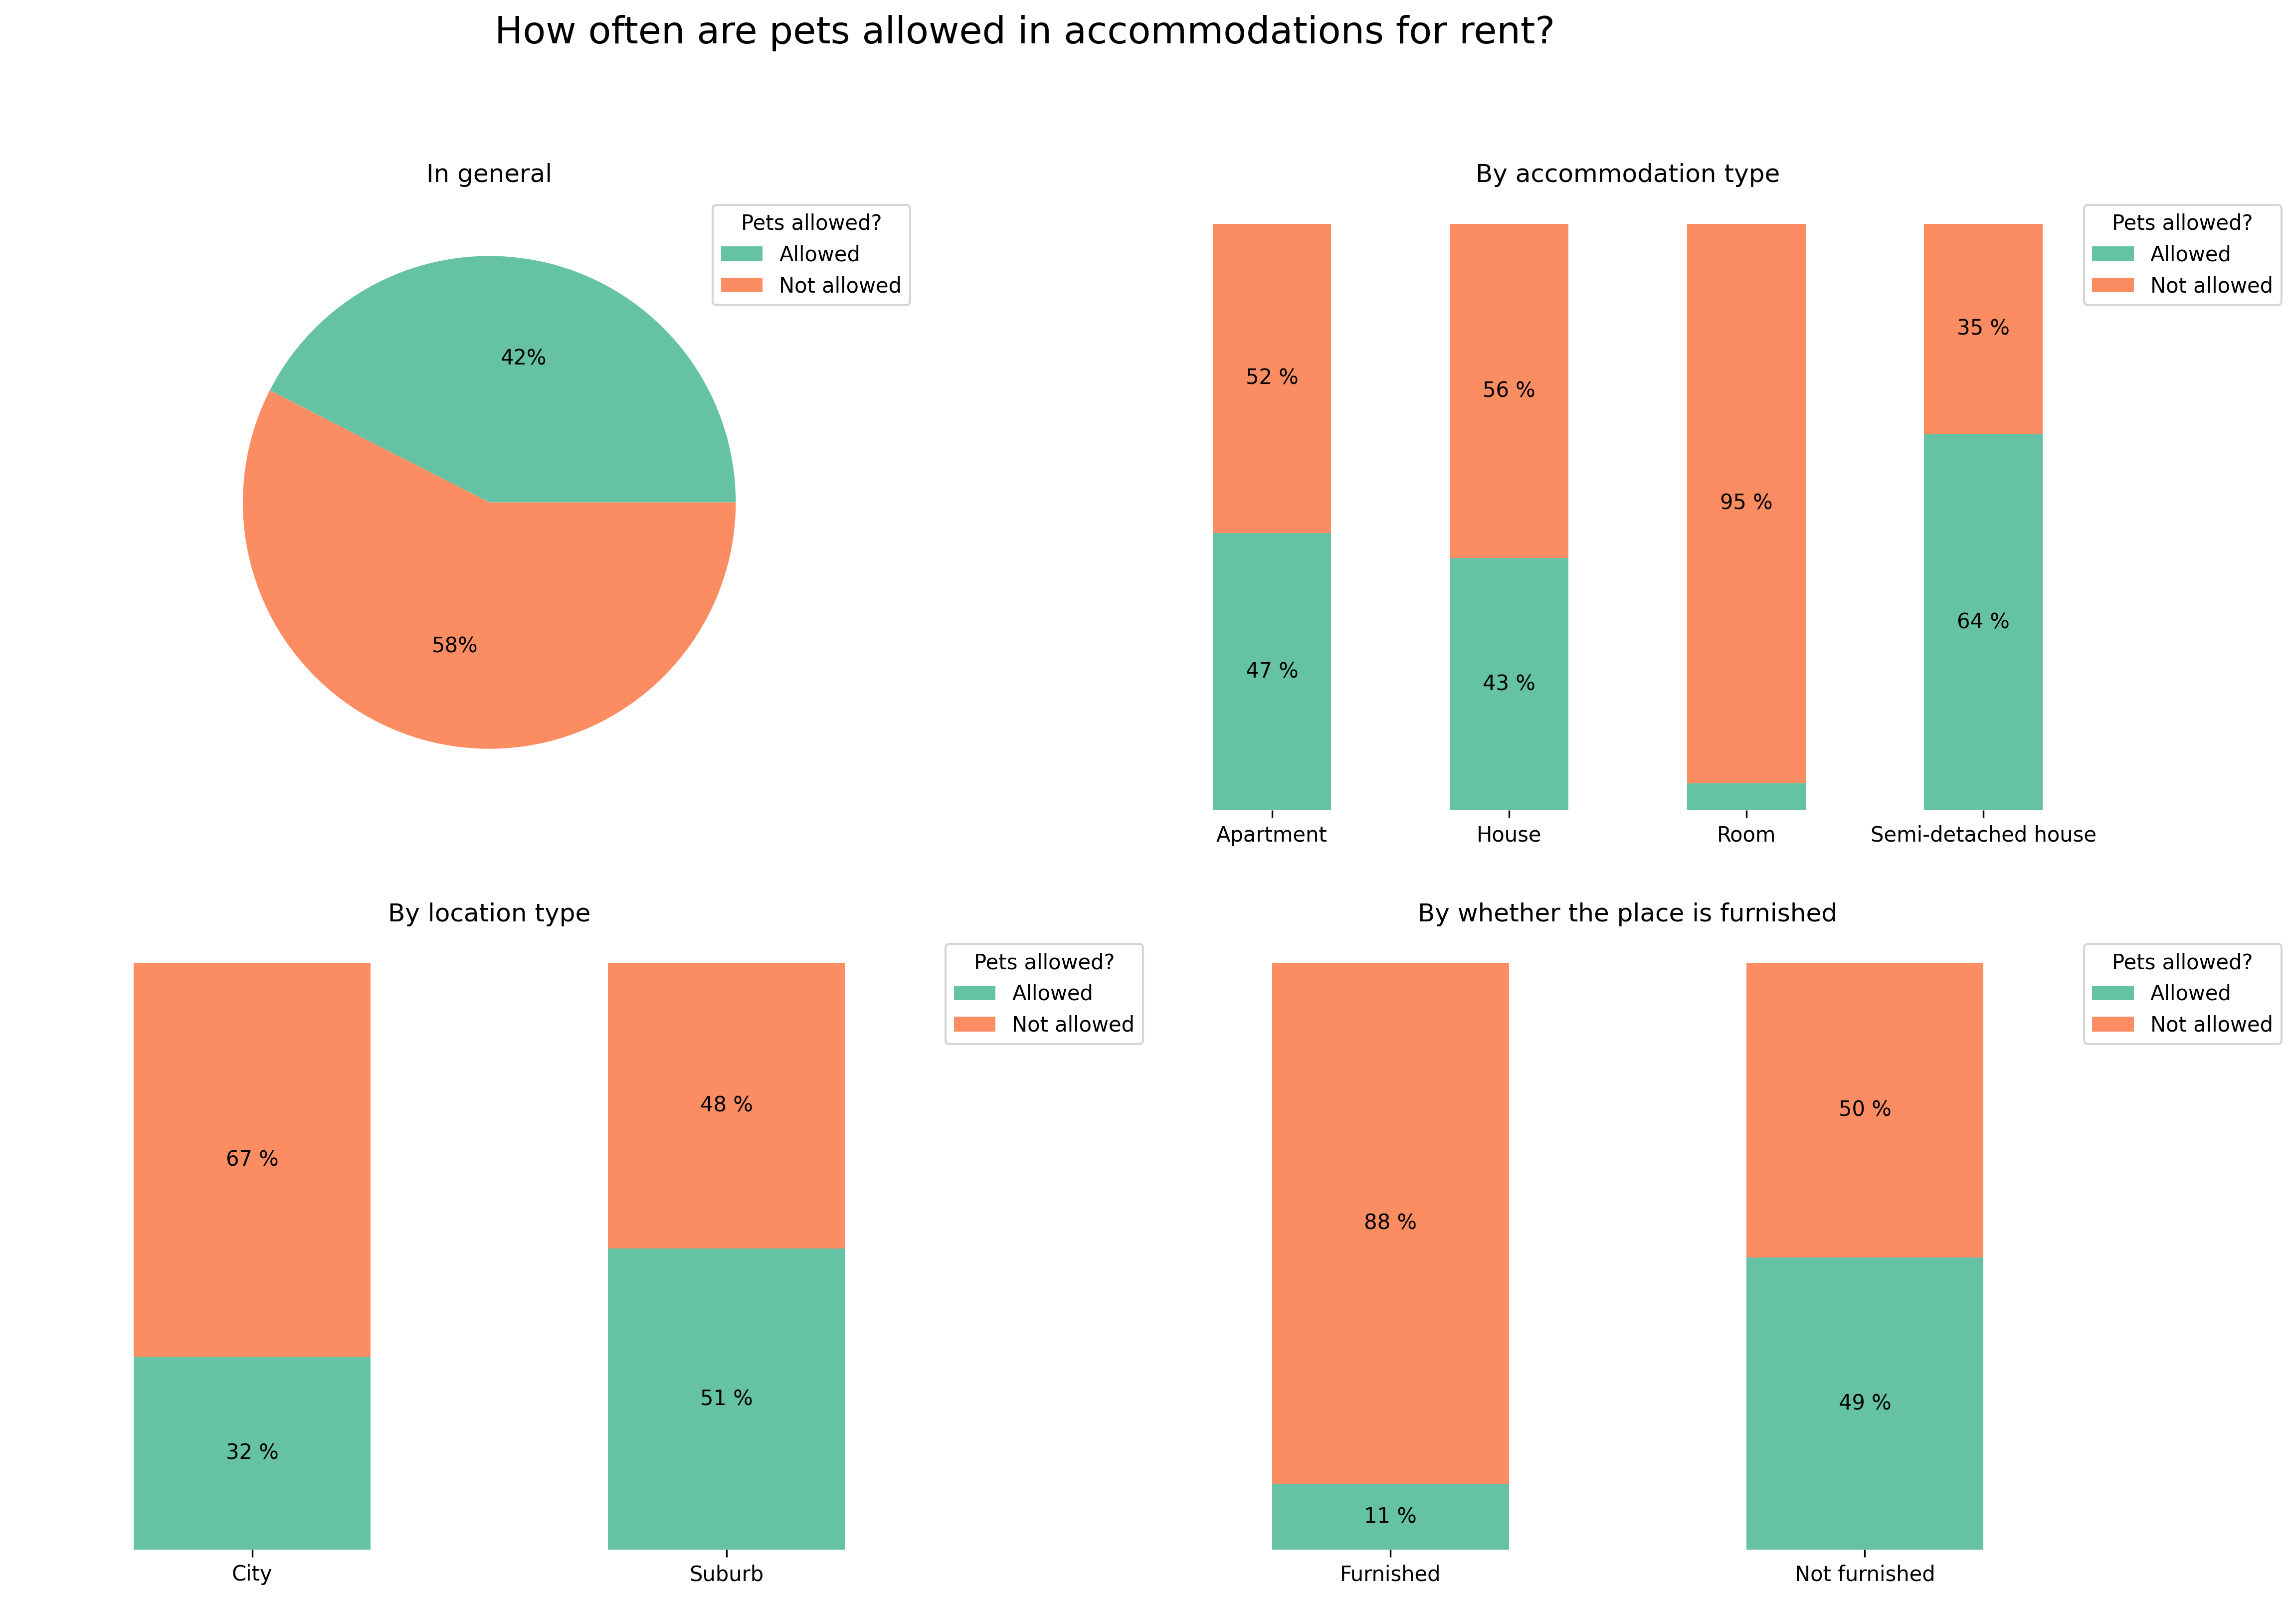

In [ ]:
# Preparing area for plotting of data
fig = plt.figure(figsize = (18, 12), dpi = 300)

# Defining custom colors for charts made using pandas
CustomColors = {"Allowed":"#66C2A5", "Not allowed":"#FC8D62"}

# Preparing data for the 1st plot
VarsOfInterest = ["PetsAllowed"]
SummaryData = Accommodations.copy()
SummaryData["PetsAllowed"] = np.where(SummaryData["PetsAllowed"] == 1, "Allowed", "Not allowed")
SummaryData["NumberOfListings"] = SummaryData.groupby(VarsOfInterest)["Link"].transform("nunique")
SummaryData.sort_values(VarsOfInterest, inplace = True)
SummaryData.drop_duplicates(subset = VarsOfInterest, inplace = True)

# Making the 1st plot
ax1 = plt.subplot2grid((2, 2), (0, 0))
Plot1 = plt.pie(SummaryData["NumberOfListings"], colors = ColorPalette, autopct = '%.0f%%')
plt.title("In general")
plt.legend(title = "Pets allowed?", labels = SummaryData["PetsAllowed"], loc = "upper right", bbox_to_anchor = (1.2, 1))

# Preparing data for the 2nd plot
SummaryData = Accommodations.copy()
SummaryData["PetsAllowed"] = np.where(SummaryData["PetsAllowed"] == 1, "Allowed", "Not allowed")
x_var, y_var = "AccommodationType", "PetsAllowed"
SummaryData = SummaryData.groupby(x_var)[y_var].value_counts(normalize = True).unstack(y_var)

# Making the 2nd plot
ax1 = plt.subplot2grid((2, 2), (0, 1))
ax = plt.gca()
Plot2 = SummaryData.plot.bar(stacked = True, color = CustomColors, ax = ax1)
ShowValuesPandas(SummaryData)
plt.title("By accommodation type")
plt.legend(title = "Pets allowed?", loc = "upper right", bbox_to_anchor = (1.2, 1))
plt.xlabel("")
plt.ylabel("")
plt.xticks(wrap = True, rotation = 0)
plt.yticks([], [])
HideBorders(ax1)

# Preparing data for the 3rd plot
SummaryData = Accommodations.copy()
SummaryData["PetsAllowed"] = np.where(SummaryData["PetsAllowed"] == 1, "Allowed", "Not allowed")
x_var, y_var = "LocationType", "PetsAllowed"
SummaryData = SummaryData.groupby(x_var)[y_var].value_counts(normalize = True).unstack(y_var)

# Making the 3rd plot
ax1 = plt.subplot2grid((2, 2), (1, 0))
ax = plt.gca()
Plot3 = SummaryData.plot.bar(stacked = True, color = CustomColors, ax = ax1)
ShowValuesPandas(SummaryData)
plt.title("By location type")
plt.legend(title = "Pets allowed?", loc = "upper right", bbox_to_anchor = (1.2, 1))
plt.xlabel("")
plt.ylabel("")
plt.xticks(wrap = True, rotation = 0)
plt.yticks([], [])
HideBorders(ax1)

# Preparing data for the 4th plot
SummaryData = Accommodations.copy()
SummaryData["PetsAllowed"] = np.where(SummaryData["PetsAllowed"] == 1, "Allowed", "Not allowed")
SummaryData["Furnished"] = np.where(SummaryData["Furnished"] == 1, "Furnished", "Not furnished")
x_var, y_var = "Furnished", "PetsAllowed"
SummaryData = SummaryData.groupby(x_var)[y_var].value_counts(normalize = True).unstack(y_var)

# Making the 4th plot
ax1 = plt.subplot2grid((2, 2), (1, 1))
ax = plt.gca()
Plot4= SummaryData.plot.bar(stacked = True, color = CustomColors, ax = ax1)
ShowValuesPandas(SummaryData)
plt.title("By whether the place is furnished")
plt.legend(title = "Pets allowed?", loc = "upper right", bbox_to_anchor = (1.2, 1))
plt.xlabel("")
plt.ylabel("")
plt.xticks(wrap = True, rotation = 0)
plt.yticks([], [])
HideBorders(ax1)

# Finalizing output
plt.suptitle("How often are pets allowed in accommodations for rent?", fontsize = 18)
plt.show()

### How often is parking available?

Below, we present four different views of whether parking is available or not. First, we take a very general look. Then, we examine whether the availability of parking varies by different factors, including accommodation type, location and whether the accommodation is suitable for the elderly or not.

**The four figures below give us the following insights:**

* Overall, parking is available in less than half of all accommodations for rent (44%).
* Parking is much more likely to be available in houses (53% likely) and in semi-detached houses (60%) than it is likely to be available in either single rooms (28%) or apartments (45%).
* Parking is more often available in the suburbs (52% of all accommodations) than it is available in the city (only 35% of all accommodations).
* Parking is also more likely to be present in connection with accommodations that have been marked as "suitable for the elderly" (77% likely) than in those which haven't been marked as such (32%).

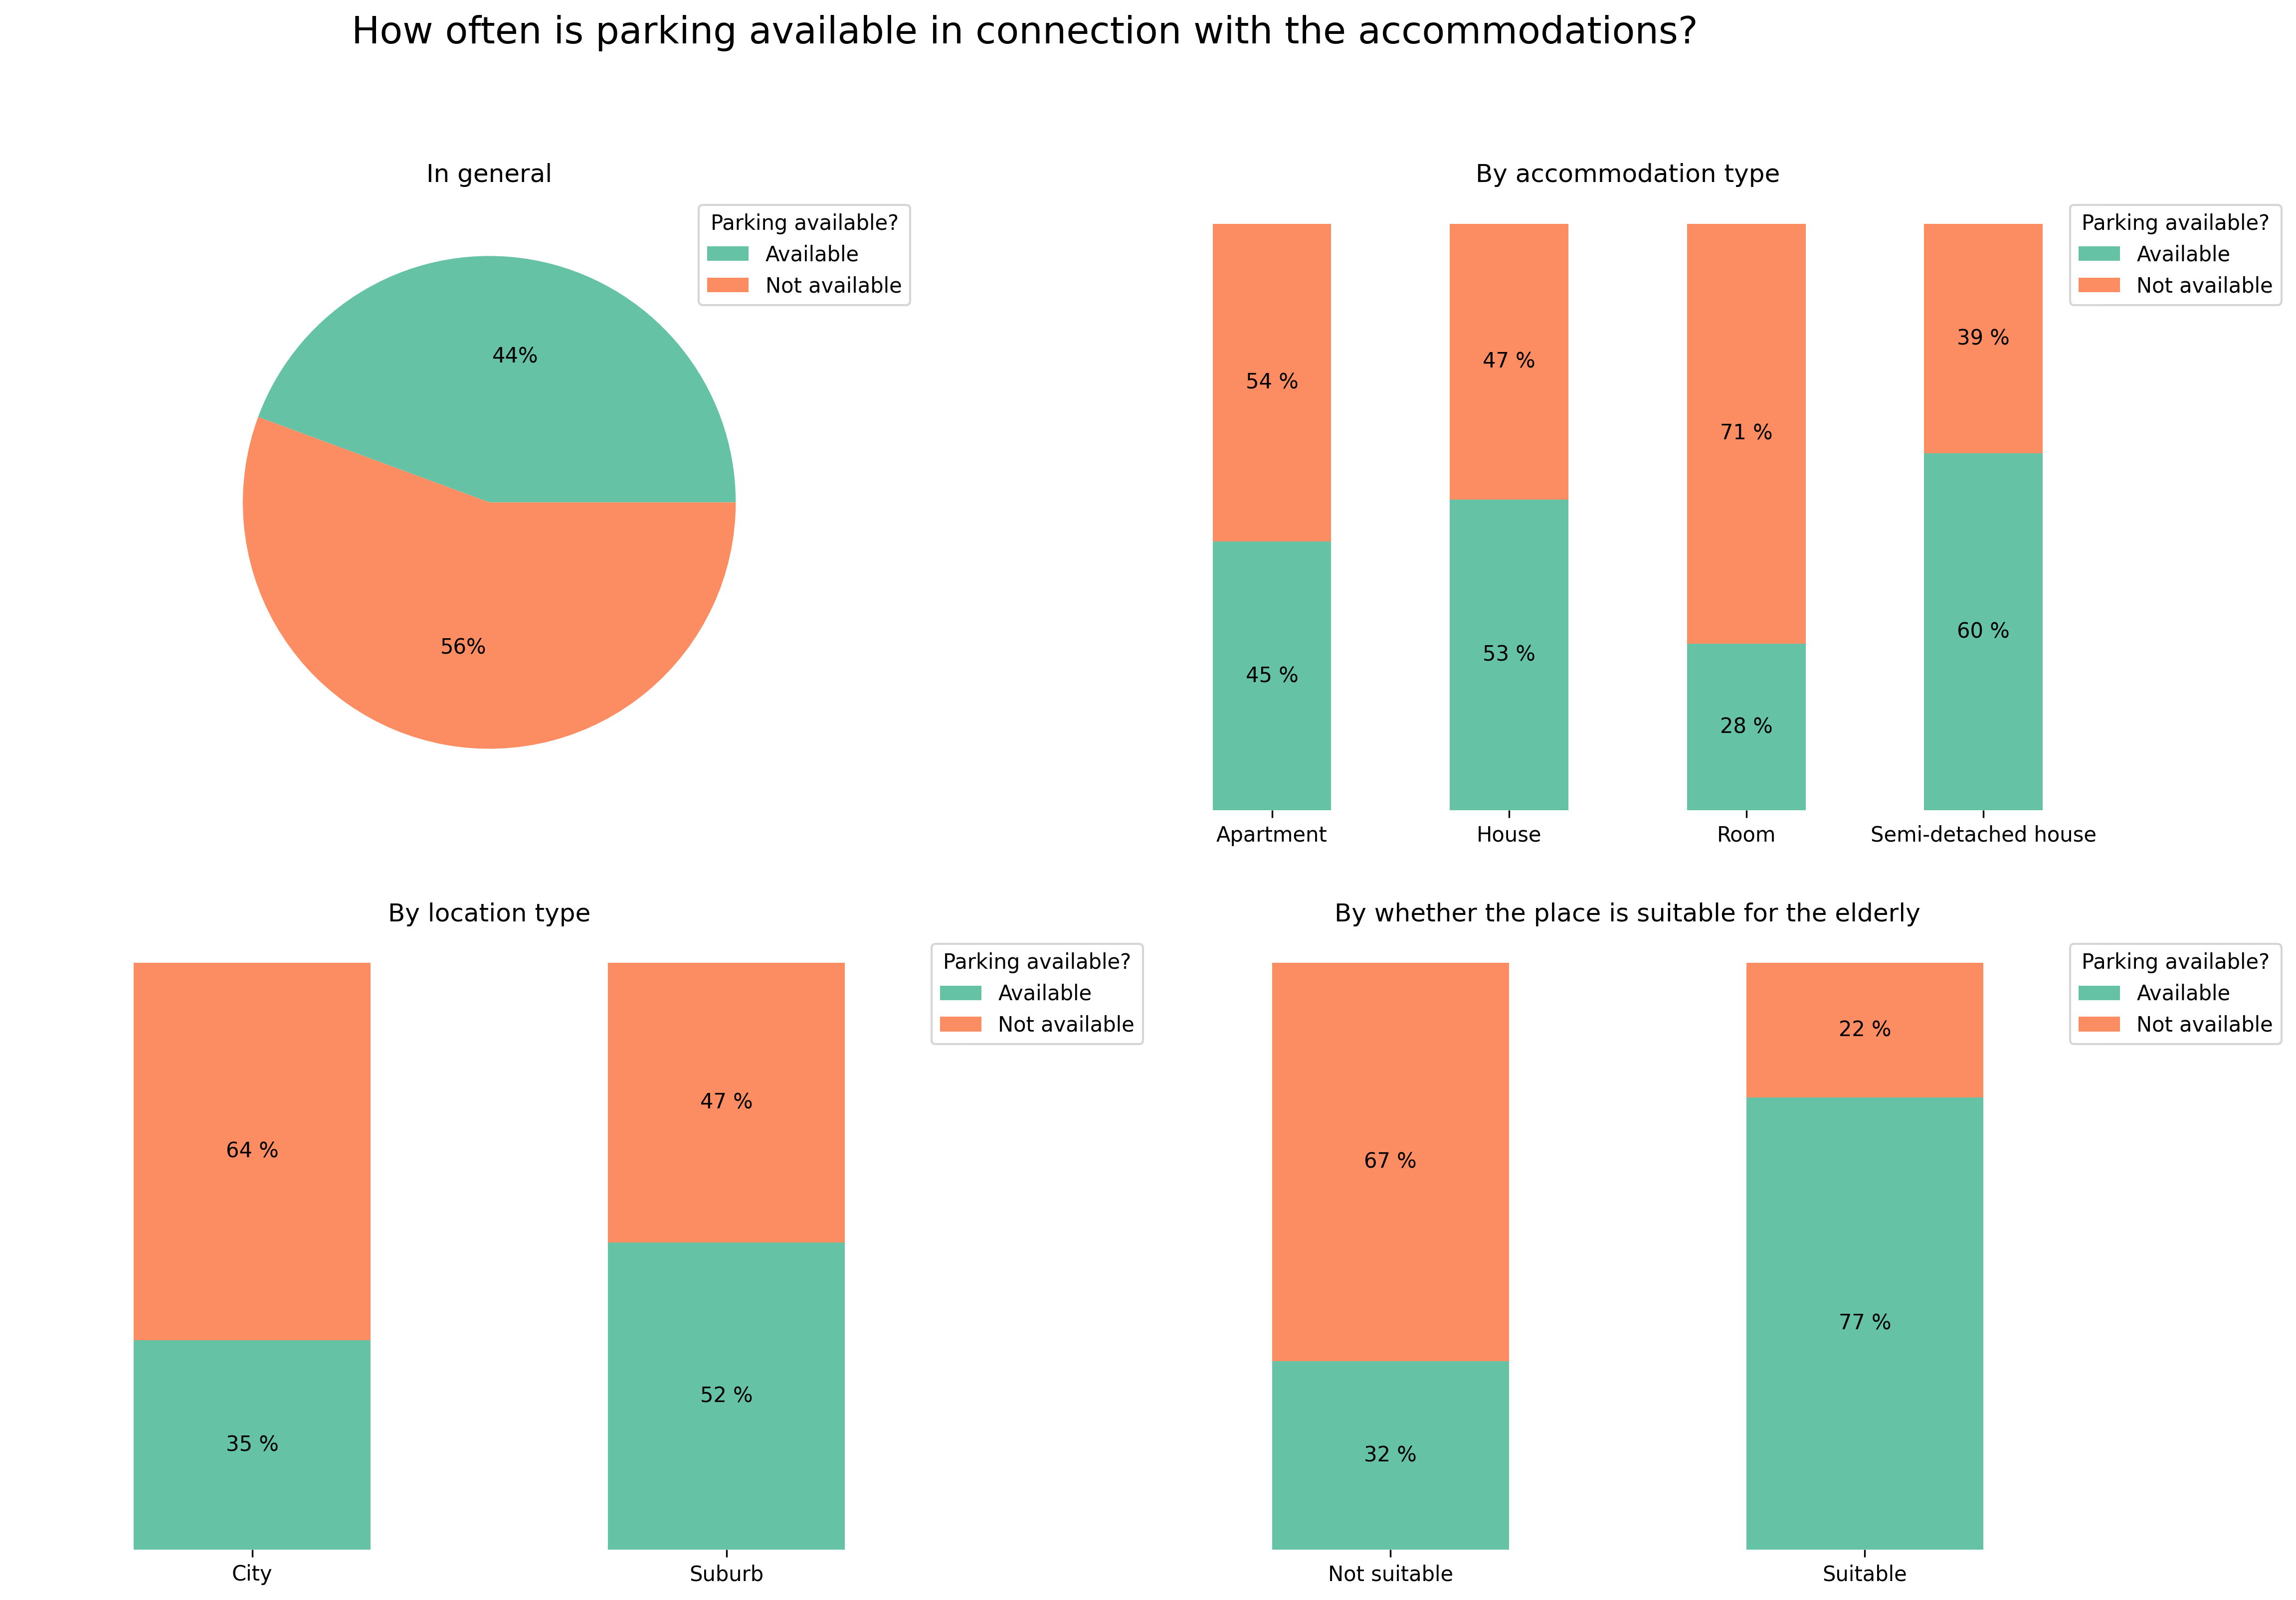

In [ ]:
# Preparing area for plotting of data
fig = plt.figure(figsize = (18, 12), dpi = 300)

# Defining custom colors for charts made using pandas
CustomColors = {"Available":"#66C2A5", "Not available":"#FC8D62"}

# Preparing data for the 1st plot
VarsOfInterest = ["Parking"]
SummaryData = Accommodations.copy()
SummaryData["Parking"] = np.where(SummaryData["Parking"] == 1, "Available", "Not available")
SummaryData["NumberOfListings"] = SummaryData.groupby(VarsOfInterest)["Link"].transform("nunique")
SummaryData.sort_values(VarsOfInterest, inplace = True)
SummaryData.drop_duplicates(subset = VarsOfInterest, inplace = True)

# Making the 1st plot
ax1 = plt.subplot2grid((2, 2), (0, 0))
Plot1 = plt.pie(SummaryData["NumberOfListings"], colors = ColorPalette, autopct = '%.0f%%')
plt.title("In general")
plt.legend(title = "Parking available?", labels = SummaryData["Parking"], loc = "upper right", bbox_to_anchor = (1.2, 1))

# Preparing data for the 2nd plot
SummaryData = Accommodations.copy()
SummaryData["Parking"] = np.where(SummaryData["Parking"] == 1, "Available", "Not available")
x_var, y_var = "AccommodationType", "Parking"
SummaryData = SummaryData.groupby(x_var)[y_var].value_counts(normalize = True).unstack(y_var)

# Making the 2nd plot
ax1 = plt.subplot2grid((2, 2), (0, 1))
ax = plt.gca()
Plot2 = SummaryData.plot.bar(stacked = True, color = CustomColors, ax = ax1)
ShowValuesPandas(SummaryData)
plt.title("By accommodation type")
plt.legend(title = "Parking available?", loc = "upper right", bbox_to_anchor = (1.2, 1))
plt.xlabel("")
plt.ylabel("")
plt.xticks(wrap = True, rotation = 0)
plt.yticks([], [])
HideBorders(ax1)

# Preparing data for the 3rd plot
SummaryData = Accommodations.copy()
SummaryData["Parking"] = np.where(SummaryData["Parking"] == 1, "Available", "Not available")
x_var, y_var = "LocationType", "Parking"
SummaryData = SummaryData.groupby(x_var)[y_var].value_counts(normalize = True).unstack(y_var)

# Making the 3rd plot
ax1 = plt.subplot2grid((2, 2), (1, 0))
ax = plt.gca()
Plot3 = SummaryData.plot.bar(stacked = True, color = CustomColors, ax = ax1)
ShowValuesPandas(SummaryData)
plt.title("By location type")
plt.legend(title = "Parking available?", loc = "upper right", bbox_to_anchor = (1.2, 1))
plt.xlabel("")
plt.ylabel("")
plt.xticks(wrap = True, rotation = 0)
plt.yticks([], [])
HideBorders(ax1)

# Preparing data for the 4th plot
SummaryData = Accommodations.copy()
SummaryData["Parking"] = np.where(SummaryData["Parking"] == 1, "Available", "Not available")
SummaryData["SuitableForElderly"] = np.where(SummaryData["SuitableForElderly"] == 1, "Suitable", "Not suitable")
x_var, y_var = "SuitableForElderly", "Parking"
SummaryData = SummaryData.groupby(x_var)[y_var].value_counts(normalize = True).unstack(y_var)

# Making the 4th plot
ax1 = plt.subplot2grid((2, 2), (1, 1))
ax = plt.gca()
Plot4= SummaryData.plot.bar(stacked = True, color = CustomColors, ax = ax1)
ShowValuesPandas(SummaryData)
plt.title("By whether the place is suitable for the elderly")
plt.legend(title = "Parking available?", loc = "upper right", bbox_to_anchor = (1.2, 1))
plt.xlabel("")
plt.ylabel("")
plt.xticks(wrap = True, rotation = 0)
plt.yticks([], [])
HideBorders(ax1)

# Finalizing output
plt.suptitle("How often is parking available in connection with the accommodations?", fontsize = 18)
plt.show()

### For how long are the accommodations available for rent?

First, we take a very general look. Then, we examine whether the length of the availability varies by different factors, including accommodation type, location and whether the accommodation is refurbished or not.

**The four figures below give us the following insights:**

* Overall, less than a third of all listings (27%) are available for a limited time period only. This is even lower in the case of apartments, where only 21% are available for a limited time. Meanwhile, regular houses are only available for an unlimited time period in 9% of all cases.
* Accommodations located in the city are more likely to be available for a limited time period only (33%) compared to accommodations located in the suburbs (23%).
* Perhaps contrary to expectations, unfurnished accommodations are less likely to be available for an unlimited time period (66%) than furnished accommodations (88%).

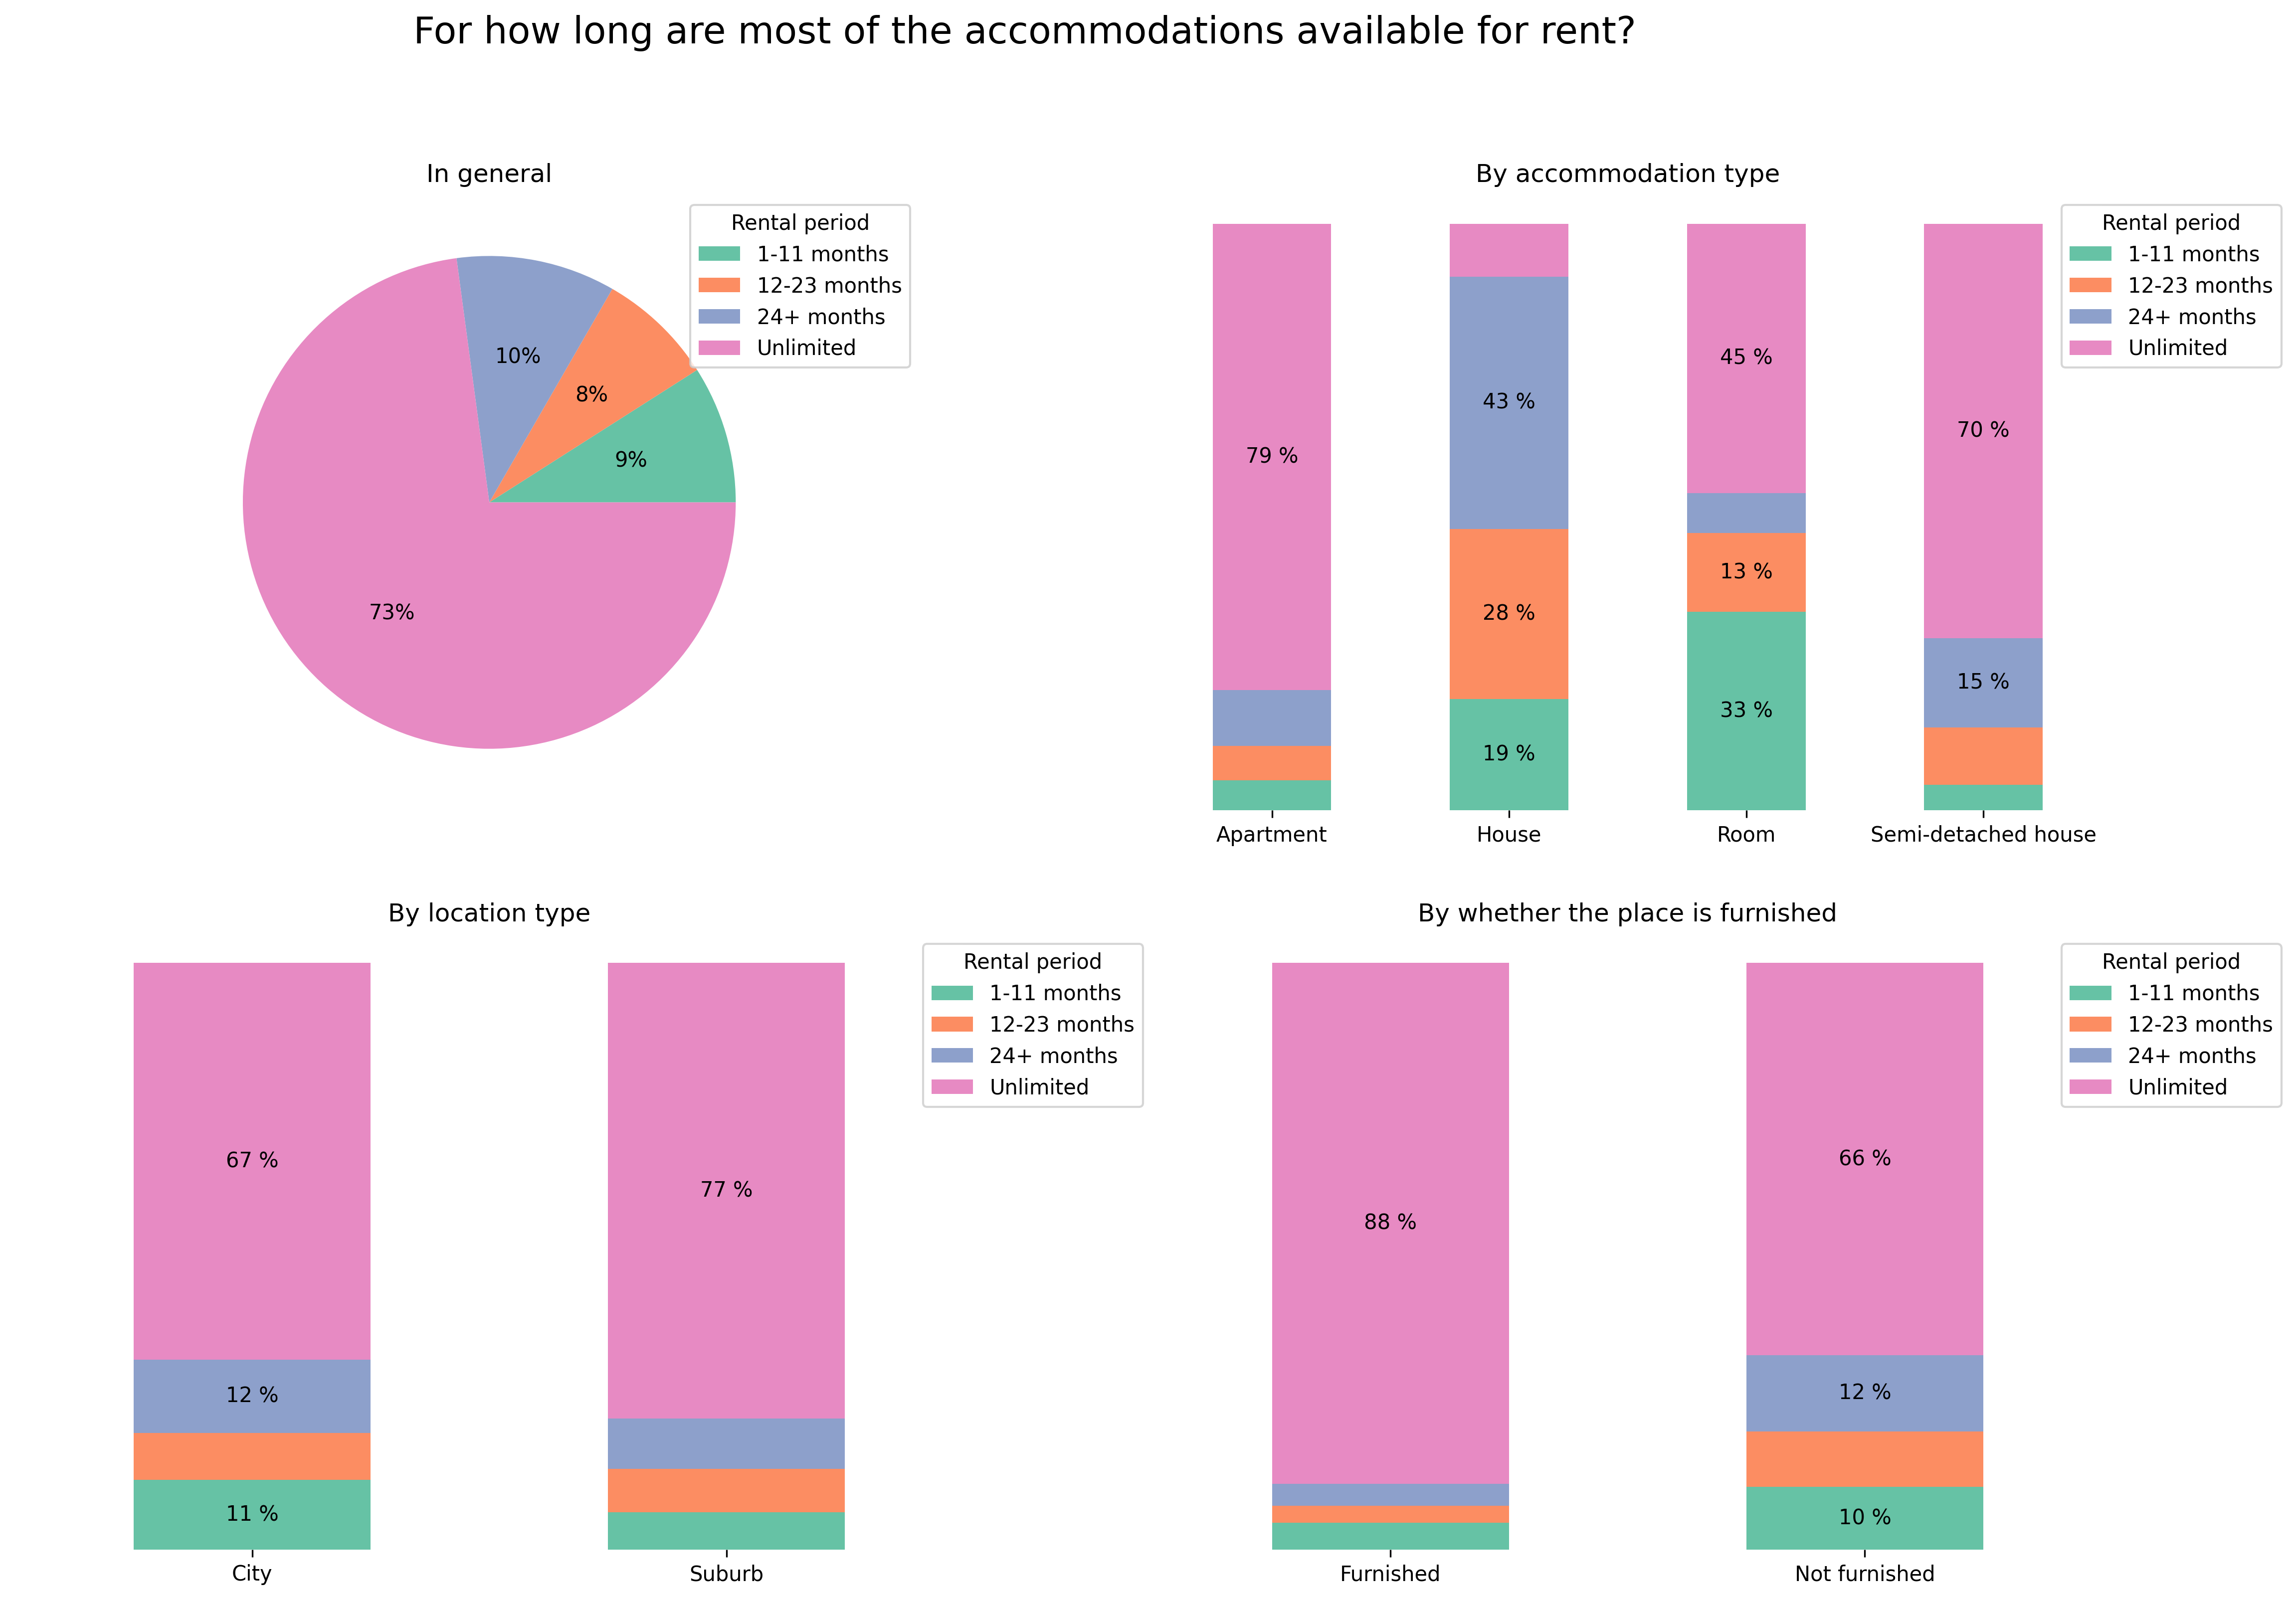

In [ ]:
# Preparing area for plotting of data
fig = plt.figure(figsize = (18, 12), dpi = 300)

# Defining custom colors for charts made using pandas
CustomColors = {"1-11 months":"#66C2A5", "12-23 months":"#FC8D62", "24+ months":"#8DA0CB", "Unlimited":"#E78AC3"}

# Preparing data for the 1st plot
VarsOfInterest = ["RentalPeriod"]
SummaryData = Accommodations.copy()
SummaryData = SummaryData[SummaryData["RentalPeriod"].notna()].copy()
SummaryData["NumberOfListings"] = SummaryData.groupby(VarsOfInterest)["Link"].transform("nunique")
SummaryData.sort_values(VarsOfInterest, inplace = True)
SummaryData.drop_duplicates(subset = VarsOfInterest, inplace = True)

# Making the 1st plot
ax1 = plt.subplot2grid((2, 2), (0, 0))
Plot1 = plt.pie(SummaryData["NumberOfListings"], colors = ColorPalette, autopct = '%.0f%%')
plt.title("In general")
plt.legend(title = "Rental period", labels = SummaryData["RentalPeriod"], loc = "upper right", bbox_to_anchor = (1.2, 1))

# Preparing data for the 2nd plot
SummaryData = Accommodations.copy()
SummaryData = SummaryData[(SummaryData["RentalPeriod"].notna()) & (SummaryData["AccommodationType"].notna())].copy()
x_var, y_var = "AccommodationType", "RentalPeriod"
SummaryData[y_var] = SummaryData[y_var].astype(str)
SummaryData = SummaryData.groupby(x_var)[y_var].value_counts(normalize = True).unstack(y_var)

# Making the 2nd plot
ax1 = plt.subplot2grid((2, 2), (0, 1))
ax = plt.gca()
Plot2 = SummaryData.plot.bar(stacked = True, color = CustomColors, ax = ax1)
ShowValuesPandas(SummaryData)
plt.title("By accommodation type")
plt.legend(title = "Rental period", loc = "upper right", bbox_to_anchor = (1.2, 1))
plt.xlabel("")
plt.ylabel("")
plt.xticks(wrap = True, rotation = 0)
plt.yticks([], [])
HideBorders(ax1)

# Preparing data for the 3rd plot
SummaryData = Accommodations.copy()
x_var, y_var = "LocationType", "RentalPeriod"
SummaryData = SummaryData[(SummaryData["RentalPeriod"].notna()) & (SummaryData["LocationType"].notna())].copy()
SummaryData[y_var] = SummaryData[y_var].astype(str)
SummaryData = SummaryData.groupby(x_var)[y_var].value_counts(normalize = True).unstack(y_var)

# Making the 3rd plot
ax1 = plt.subplot2grid((2, 2), (1, 0))
ax = plt.gca()
Plot3 = SummaryData.plot.bar(stacked = True, color = CustomColors, ax = ax1)
ShowValuesPandas(SummaryData)
plt.title("By location type")
plt.legend(title = "Rental period", loc = "upper right", bbox_to_anchor = (1.2, 1))
plt.xlabel("")
plt.ylabel("")
plt.xticks(wrap = True, rotation = 0)
plt.yticks([], [])
HideBorders(ax1)

# Preparing data for the 4th plot
SummaryData = Accommodations.copy()
SummaryData = SummaryData[SummaryData["RentalPeriod"].notna()].copy()
SummaryData["Furnished"] = np.where(SummaryData["SuitableForElderly"] == 1, "Furnished", "Not furnished")
x_var, y_var = "Furnished", "RentalPeriod"
SummaryData[y_var] = SummaryData[y_var].astype(str)
SummaryData = SummaryData.groupby(x_var)[y_var].value_counts(normalize = True).unstack(y_var)

# Making the 4th plot
ax1 = plt.subplot2grid((2, 2), (1, 1))
ax = plt.gca()
Plot4= SummaryData.plot.bar(stacked = True, color = CustomColors, ax = ax1)
ShowValuesPandas(SummaryData)
plt.title("By whether the place is furnished")
plt.legend(title = "Rental period", loc = "upper right", bbox_to_anchor = (1.2, 1))
plt.xlabel("")
plt.ylabel("")
plt.xticks(wrap = True, rotation = 0)
plt.yticks([], [])
HideBorders(ax1)

# Finalizing output
plt.suptitle("For how long are most of the accommodations available for rent?", fontsize = 18)
plt.show()

### How big are the accommodations on offer?

First, we take a very general look at the size as measured in square meters. Then, we examine whether the size varies by different factors, including accommodation type and location.

**The figures below give us the following insights:**

* The median size of accommodations appears to be around 70-80 square meters in general, which is fairly close to median of the most represented kind of accommodations - apartments (87 square meters).
* Rooms have naturally the smaller median size (14 square meters), while regular houses have the largest median size (153 square meters).
* There are quite a few outliers in the size distribution of both rooms and apartments, with relatively few outliers in the case of houses and semi-detached houses.
* Acommodations in the city appear to be slightly larger as evidenced by their median size (86 square meters compared to 84 square meters in the suburbds). Even upon closer examination of the respective distributions, it becomes apparent that two thirds of accommodations in the city have a size of up to about 210 square meters, while two thirds of accommodations in the suburbs have a size of up to about 180 square meters. Even so, there are quite a few outliers with exceptionally high sizes in the suburbs.
* Finally, accommodations where pets are allowed appear to be bigger than those where pets aren't allowed as evidenced by the median sizes of 90 and 72 square meters respectively. Although there are quite some outliers, it's curious to see that there are also quite a few bigger accommodations where pets aren't allowed.

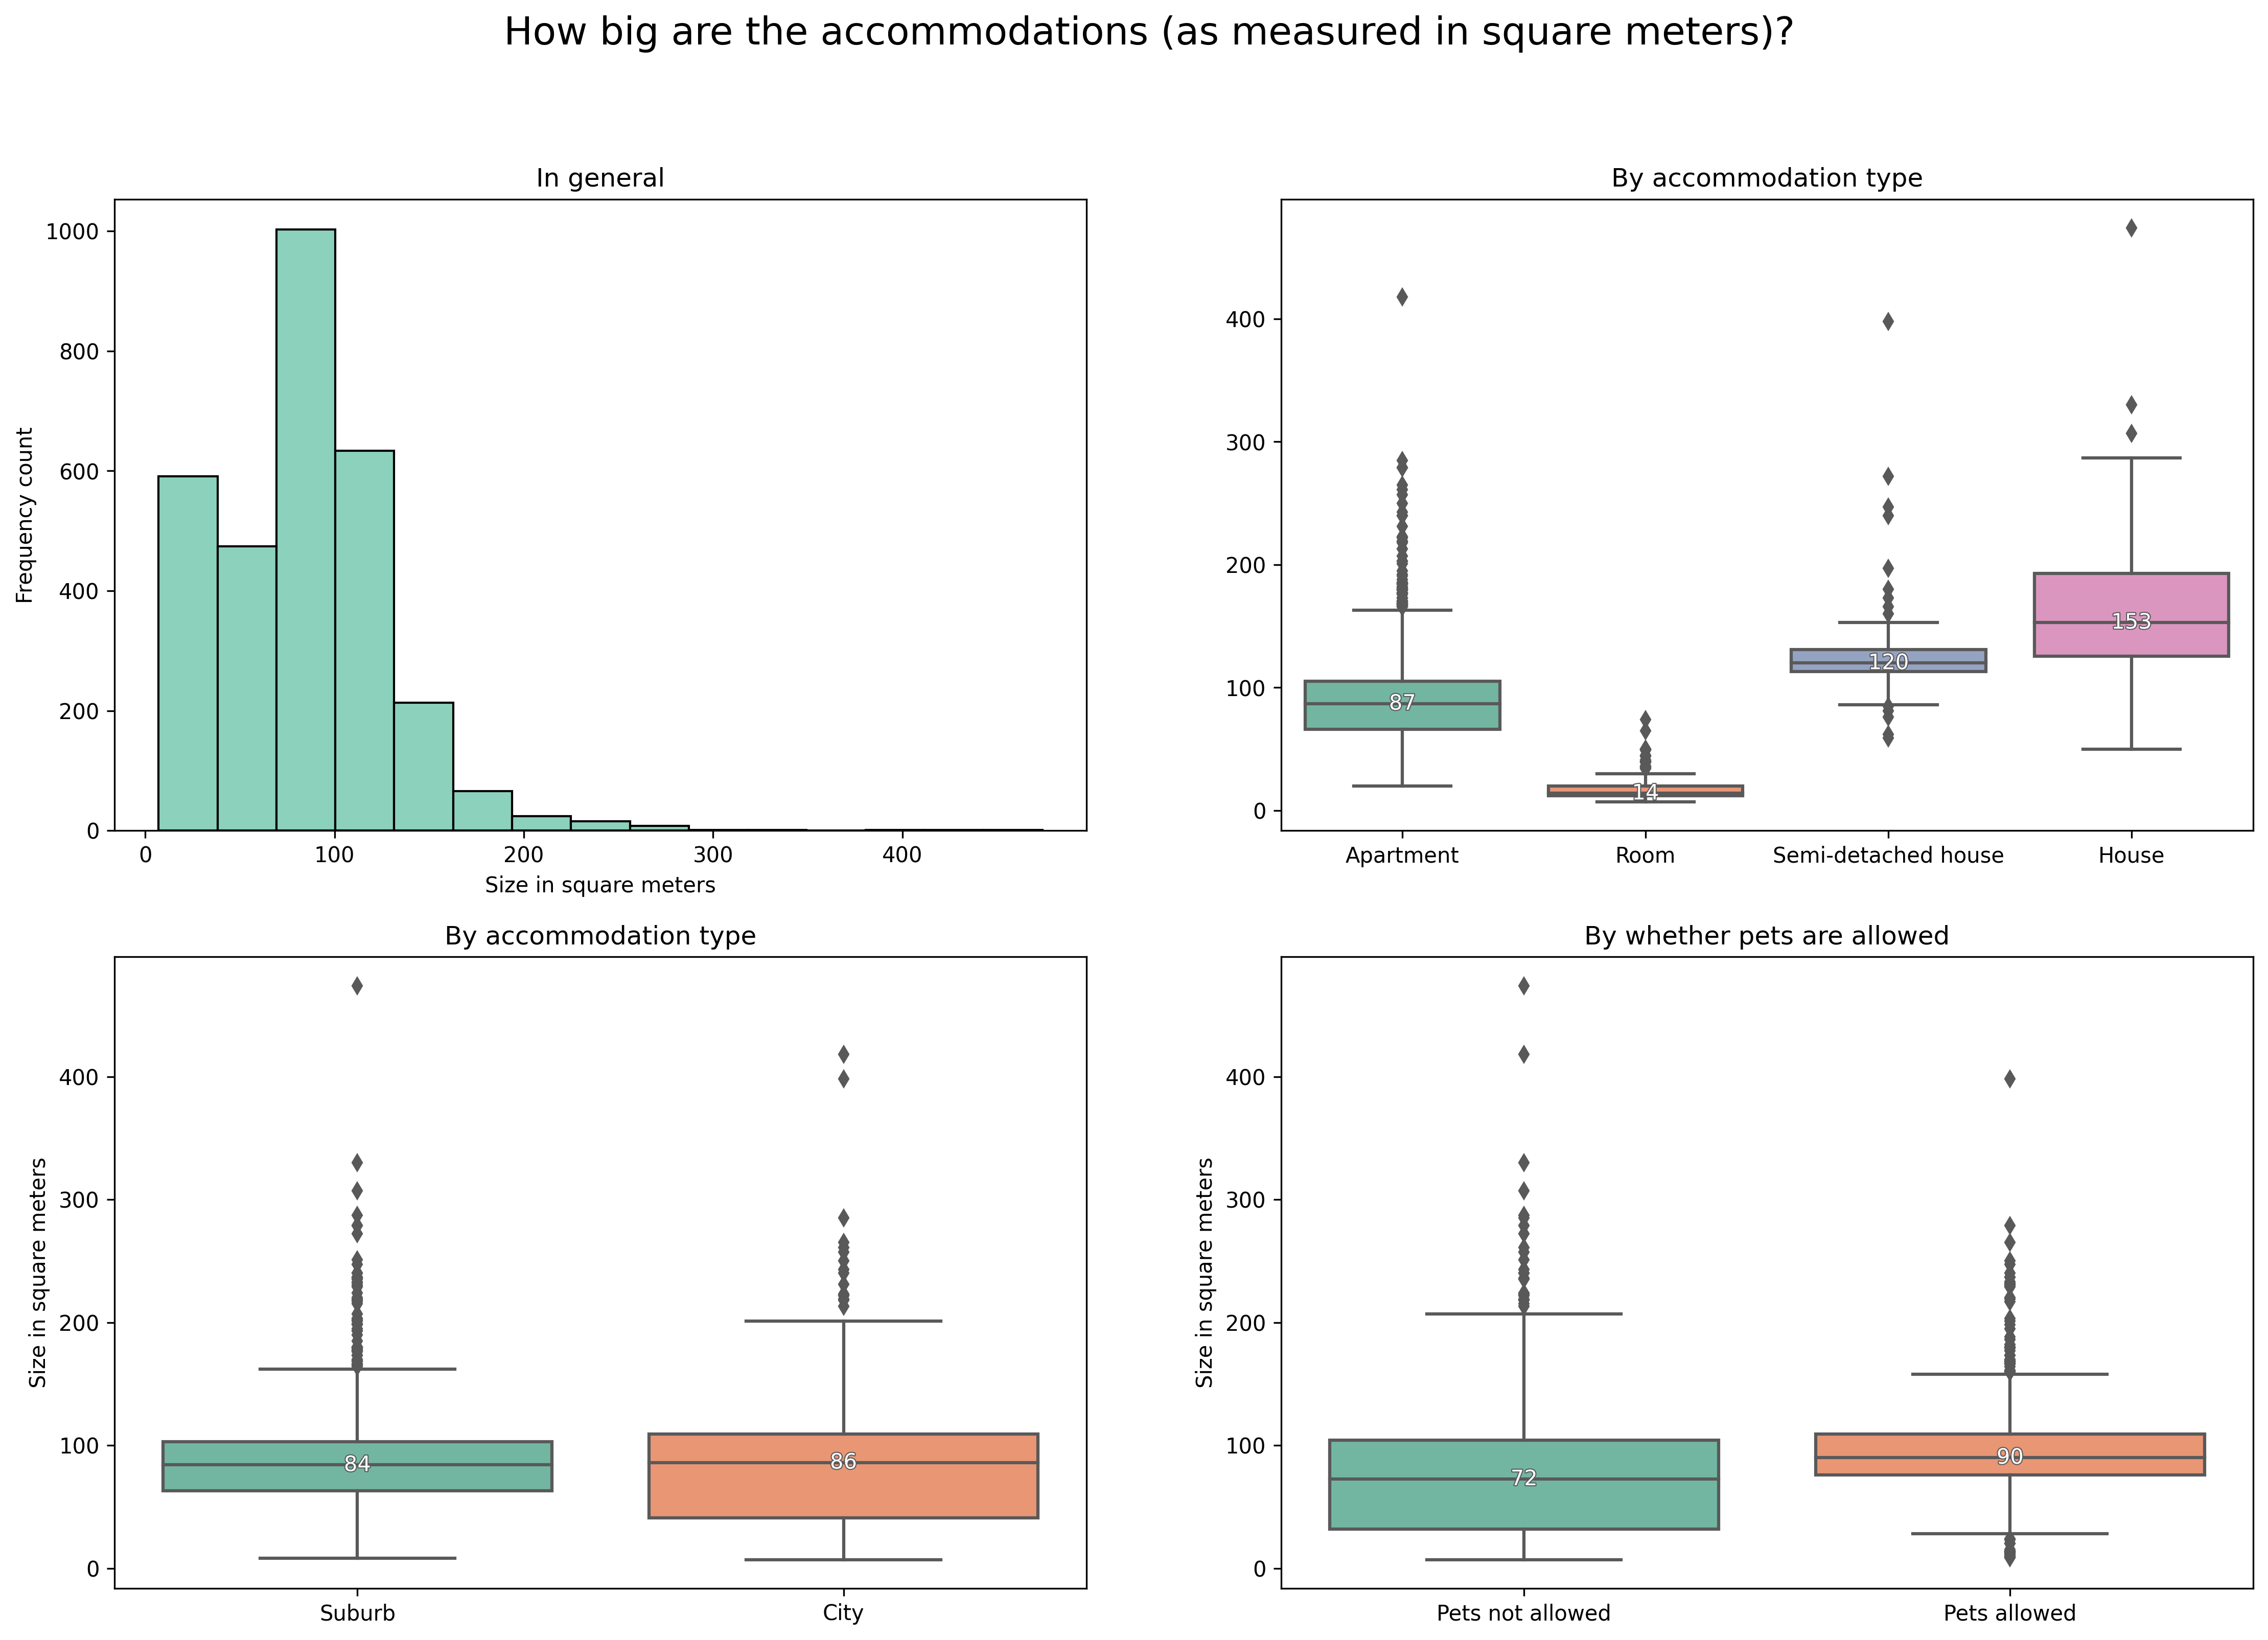

In [ ]:
# Preparing area for plotting of data
fig = plt.figure(figsize = (18, 12), dpi = 300)

# Defining custom colors for charts made using pandas
CustomColors = {"1-11 months":"#66C2A5", "12-23 months":"#FC8D62", "24+ months":"#8DA0CB", "Unlimited":"#E78AC3"}

# Making the 1st plot
ax1 = plt.subplot2grid((2, 2), (0, 0))
Plot1 = sns.histplot(x = Accommodations["SizeSquareMeters"], color = "#66C2A5", bins = 15)
plt.title("In general")
plt.xlabel("Size in square meters")
plt.ylabel("Frequency count")

# Making the 2nd plot
ax1 = plt.subplot2grid((2, 2), (0, 1))
Plot2 = sns.boxplot(data = Accommodations, x = "AccommodationType", y = "SizeSquareMeters", palette = ColorPalette, ax = ax1)
plt.title("Distribution of size in square meters by accommodation type")
plt.xlabel("Accommodation type")
plt.ylabel("Size in square meters")
AddMedianLabels(Plot2, fmt = ".0f")
plt.title("By accommodation type")
plt.xlabel("")
plt.ylabel("")

# Making the 3rd plot
ax1 = plt.subplot2grid((2, 2), (1, 0))
Plot3 = sns.boxplot(data = Accommodations, x = "LocationType", y = "SizeSquareMeters", palette = ColorPalette, ax = ax1)
plt.title("Distribution of size in square meters by location type")
plt.xlabel("Accommodation type")
plt.ylabel("Size in square meters")
AddMedianLabels(Plot3, fmt = ".0f")
plt.title("By accommodation type")
plt.xlabel("")
plt.ylabel("Size in square meters")

# Preparing data for the 4th plot
DataForChart = Accommodations.copy()
DataForChart["PetsAllowed"] = np.where(DataForChart["PetsAllowed"] == 1, "Pets allowed", "Pets not allowed")

# Making the 4th plot
ax1 = plt.subplot2grid((2, 2), (1, 1))
Plot4 = sns.boxplot(data = DataForChart, x = "PetsAllowed", y = "SizeSquareMeters", palette = ColorPalette, ax = ax1)
plt.title("Distribution of size in square meters by location type")
plt.xlabel("")
plt.ylabel("Size in square meters")
AddMedianLabels(Plot4, fmt = ".0f")
plt.title("By whether pets are allowed")
plt.xlabel("")
plt.ylabel("Size in square meters")

# Finalizing output
plt.suptitle("How big are the accommodations (as measured in square meters)?", fontsize = 18)
plt.show()

### Is there a correlation between number of rooms and size measured in square meters?

The scatter plots below show the relationship between number of rooms and size measured in square meters, first in general terms and then split by accommodation type and location type.

**The figures below give us the following insights:**

Regardless of which plot we take a look at, the conclusion is the same: there is a strong positive correlation between number of rooms and size in square meters (as one would expect). The relationship appears to be of a linear character, suggesting a relatively constant increase in size depending on the number of rooms.

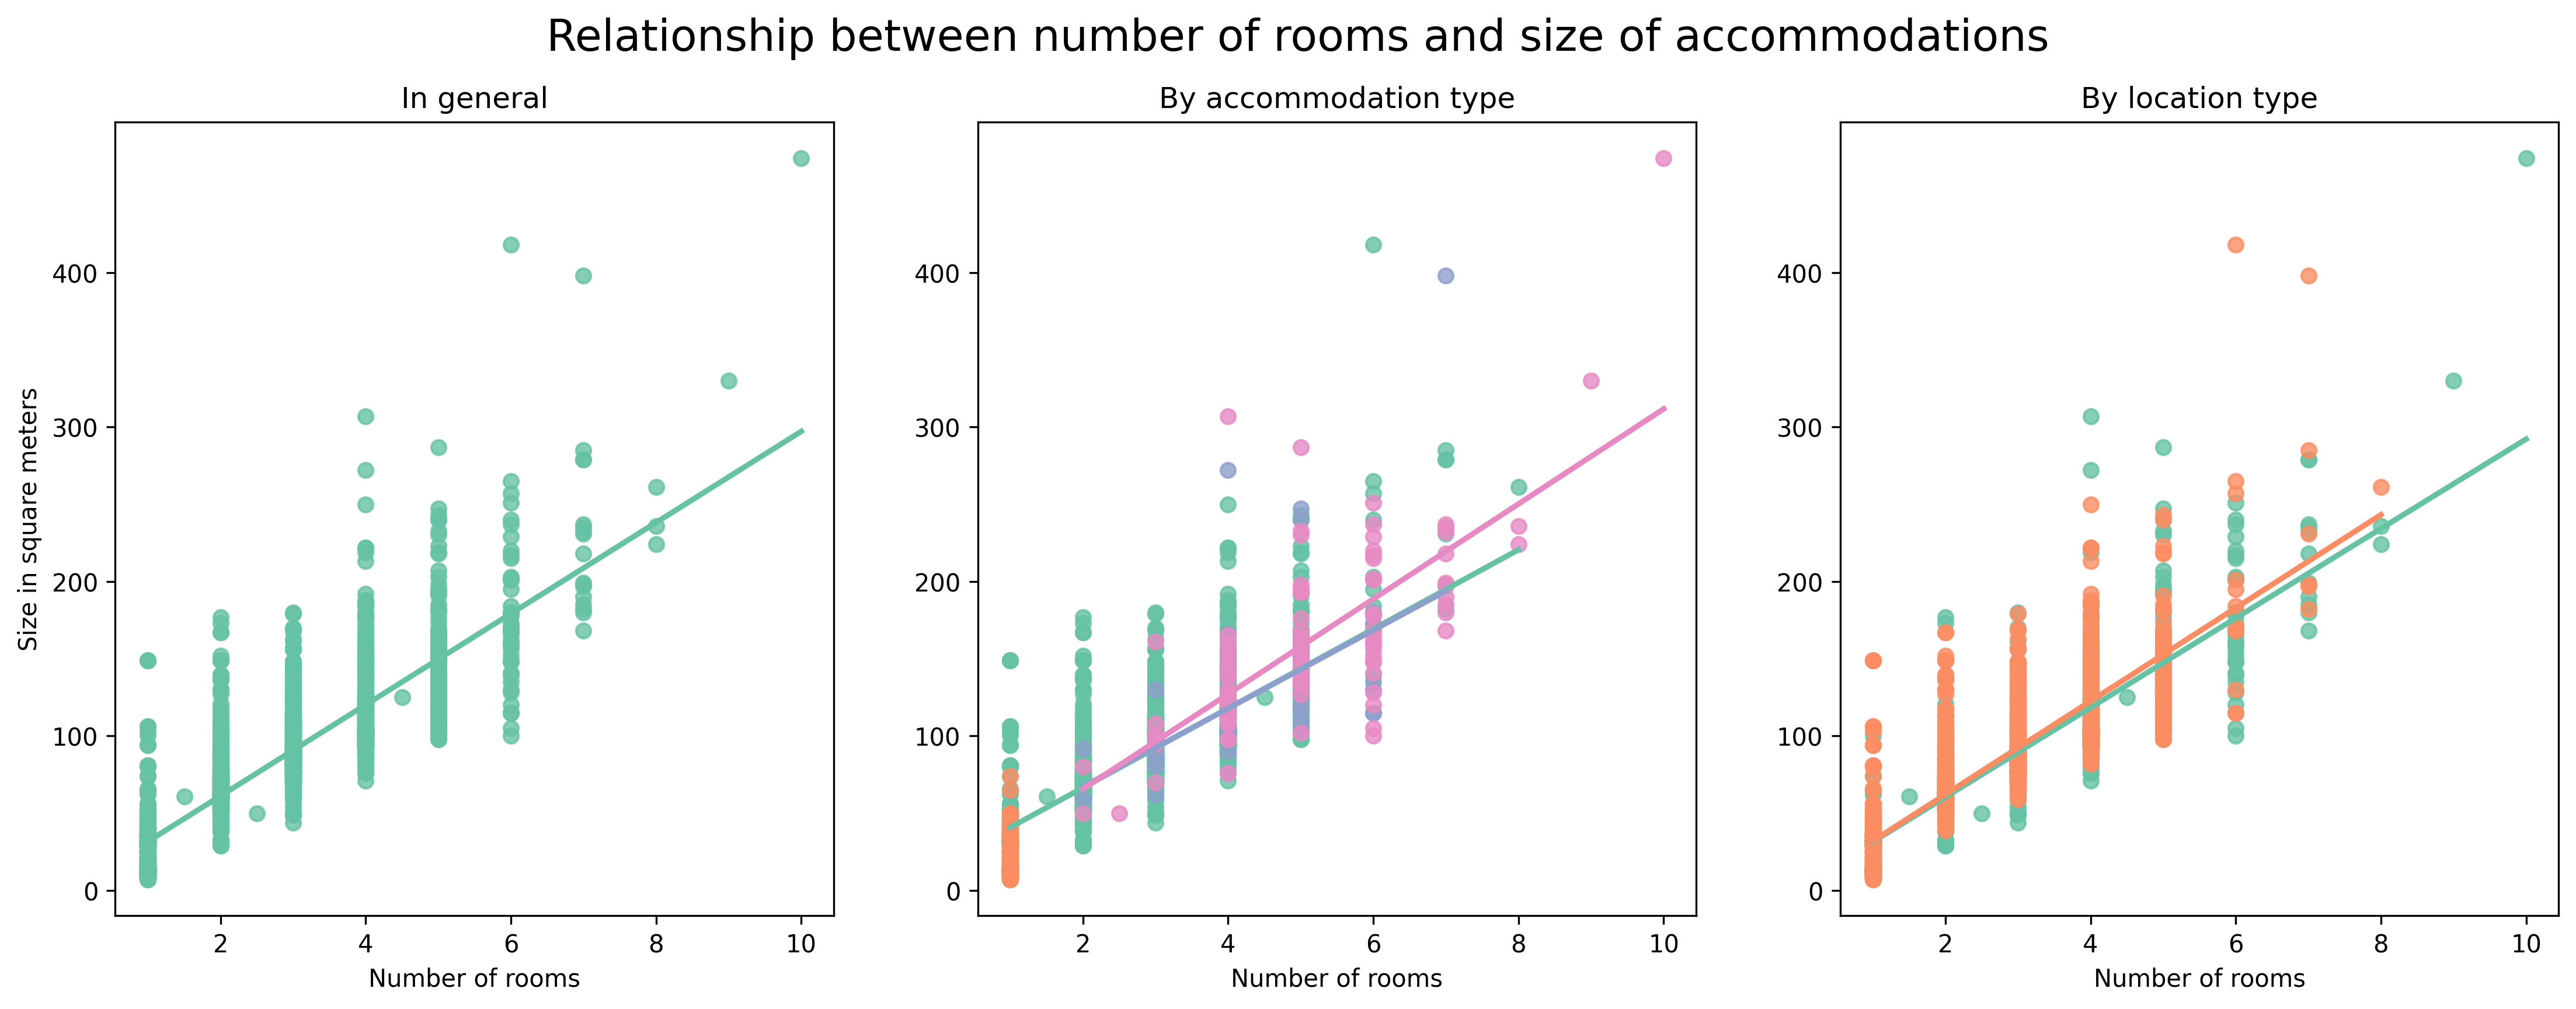

In [ ]:
# Preparing area for plotting of data
fig = plt.figure(figsize = (18, 6), dpi = 300)

# Defining custom colors for charts made using pandas
CustomColors = {"1-11 months":"#66C2A5", "12-23 months":"#FC8D62", "24+ months":"#8DA0CB", "Unlimited":"#E78AC3"}

# Making the 1st plot
ax1 = plt.subplot2grid((1, 3), (0, 0))
Plot1 = sns.regplot(data = Accommodations, x = "NumberOfRooms", y = "SizeSquareMeters", ci = None, color = "#66C2A5", ax = ax1)
plt.title("In general")
plt.xlabel("Number of rooms")
plt.ylabel("Size in square meters")

# Making the 2nd plot
ax1 = plt.subplot2grid((1, 3), (0, 1))
Plot2 = HueRegplot(data = Accommodations, x = "NumberOfRooms", y = "SizeSquareMeters", hue = "AccommodationType", ci = None, ax = ax1)
plt.title("By accommodation type")
# plt.legend(title = "Accommodation type", loc = "upper right", bbox_to_anchor = (1.2, 1))
plt.xlabel("Number of rooms")
plt.ylabel("")

# Making the 3rd plot
ax1 = plt.subplot2grid((1, 3), (0, 2))
Plot3 = HueRegplot(data = Accommodations, x = "NumberOfRooms", y = "SizeSquareMeters", hue = "LocationType", ci = None, ax = ax1)
plt.title("By location type")
plt.xlabel("Number of rooms")
plt.ylabel("")

# Finalizing output
plt.suptitle("Relationship between number of rooms and size of accommodations", fontsize = 18)
plt.show()

### What does the split of accommodations by different energy ratings look like?

As we have quite a few different categories, we're grouping some of them together so that

In [ ]:
Accommodations.EnergyRating.unique()

array([nan, 'C', 'B', 'E', 'F', 'A20', 'D', 'A15', 'A10', 'G'],
      dtype=object)

... becomes:

In [ ]:
# Temporary dataframe where the energy ratings are grouped together
DataForChart = Accommodations.copy()

Conditions = [(DataForChart.EnergyRating.isin(["A10", "A15", "A20"])),
              (DataForChart.EnergyRating == "B"),
              (DataForChart.EnergyRating == "C"),
              (DataForChart.EnergyRating.isin(["D", "E", "F", "G", np.nan]))]

Values = ["A", "B", "C", "D+"]
DataForChart["EnergyRating"] = np.select(Conditions, Values)

# Sorting the data in ascending order (makes for better looking charts)
DataForChart.sort_values("EnergyRating", ascending = True, inplace = True)

# Previewing the new, grouped values
DataForChart.EnergyRating.unique()

array(['A', 'B', 'C', 'D+'], dtype=object)

Below, we start out by taking a very general look. Then, we examine whether the energy rating varies by different factors, including accommodation type and location.

**The figures below give us the following insights:**

* Surprisingly for a country like Denmark, only less than one fifth of all accomodations available in the Greater Copenhagen region are highly energy efficient ("A"-rated: 28%). Even more disturbingly, 59% of the accommodations have an energy efficiency rating "D" or lower.
* While there are some differences between accommodation types, energy efficiency seems to be an issue with all types, though semi-detached houses are most likely to have a top-rated energy efficiency (34%), while regular houses are least likely to have that rating (3%).
* Looking at locations, accommodations in the city are much more likely to have a top-rated energy efficiency (34%) than accommodations in the suburbs (23%). This is consistent with one of our previous conclusions reg. the majority of the houses being located in the suburbs, and we know from the chart below that houses are a lot less likely to be highly energy-efficient.

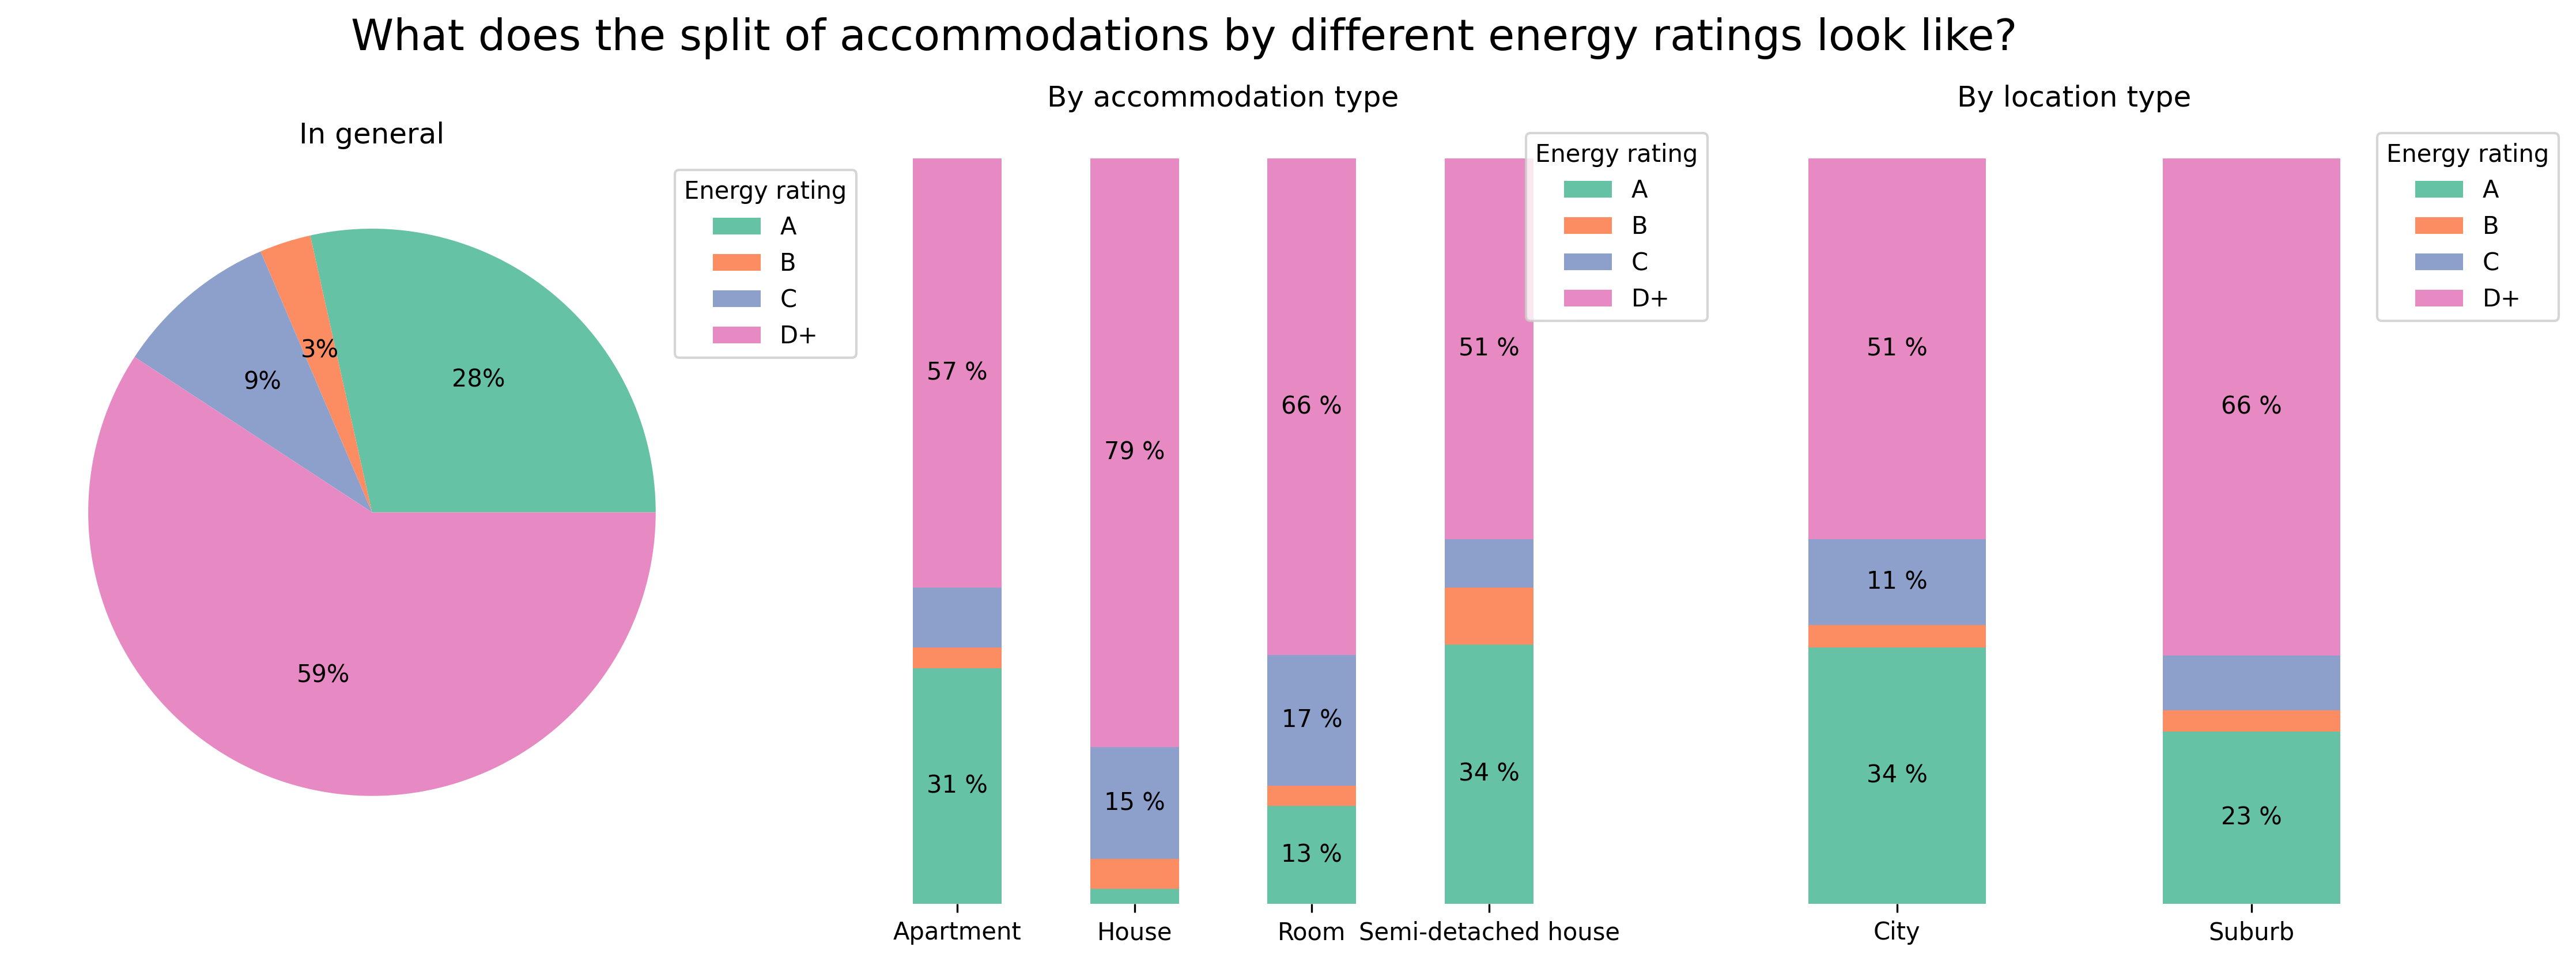

In [ ]:
# Preparing area for plotting of data
fig = plt.figure(figsize = (18, 6), dpi = 300)

# Defining custom colors for charts made using pandas
CustomColors = {"A":"#66C2A5", "B":"#FC8D62", "C":"#8DA0CB", "D+":"#E78AC3"}

# Preparing data for the 1st plot
VarsOfInterest = ["EnergyRating"]
SummaryData = DataForChart.copy()
SummaryData["NumberOfListings"] = SummaryData.groupby(VarsOfInterest)["Link"].transform("nunique")
SummaryData.sort_values(VarsOfInterest, inplace = True)
SummaryData.drop_duplicates(subset = VarsOfInterest, inplace = True)

# Making the 1st plot
ax1 = plt.subplot2grid((1, 3), (0, 0))
Plot1 = plt.pie(SummaryData["NumberOfListings"], colors = ColorPalette, autopct = '%.0f%%')
plt.title("In general")
plt.legend(title = "Energy rating", labels = SummaryData["EnergyRating"], loc = "upper right", bbox_to_anchor = (1.2, 1))

# Preparing data for the 2nd plot
SummaryData = DataForChart.copy()
x_var, y_var = "AccommodationType", "EnergyRating"
SummaryData[y_var] = SummaryData[y_var].astype(str)
SummaryData = SummaryData.groupby(x_var)[y_var].value_counts(normalize = True).unstack(y_var)

# Making the 2nd plot
ax1 = plt.subplot2grid((1, 3), (0, 1))
ax = plt.gca()
Plot2 = SummaryData.plot.bar(stacked = True, color = CustomColors, ax = ax1)
ShowValuesPandas(SummaryData)
plt.title("By accommodation type")
plt.legend(title = "Energy rating", loc = "upper right", bbox_to_anchor = (1.2, 1))
plt.xlabel("")
plt.ylabel("")
plt.xticks(wrap = True, rotation = 0)
plt.yticks([], [])
HideBorders(ax1)

# Preparing data for the 3rd plot
SummaryData = DataForChart.copy()
x_var, y_var = "LocationType", "EnergyRating"
SummaryData[y_var] = SummaryData[y_var].astype(str)
SummaryData = SummaryData.groupby(x_var)[y_var].value_counts(normalize = True).unstack(y_var)

# Making the 3rd plot
ax1 = plt.subplot2grid((1, 3), (0, 2))
ax = plt.gca()
Plot3 = SummaryData.plot.bar(stacked = True, color = CustomColors, ax = ax1)
ShowValuesPandas(SummaryData)
plt.title("By location type")
plt.legend(title = "Energy rating", loc = "upper right", bbox_to_anchor = (1.2, 1))
plt.xlabel("")
plt.ylabel("")
plt.xticks(wrap = True, rotation = 0)
plt.yticks([], [])
HideBorders(ax1)

# Finalizing output
plt.suptitle("What does the split of accommodations by different energy ratings look like?", fontsize = 18)
plt.show()

### What do rent prices look like?

Below, we take a look at rent prices per square meter (exclusive of additional monthly expenses like e.g. aconto). First, we do this in general but then, we also see how prices vary depending on accommodation type, location type and whether or not the accommodation on offer is for students only.

**The figures below give us the following insights:**

* For the majority of accommodations, the price per square meter is somewhere between 150-200 kr.
* By far, single rooms are the most expensive kind of accommodation judging by the rent per square meter (a deep dive on this is included as a sub-question), with a median price per square meter of 359 kr., which is more than twice as expensive as the median price per square meter for the other kinds of accommodations (which is around 150 kr.).
* There is a price premium to pay for accommodations located in the city, with their median price per square meter being 23% higher compared to that of accommodations located in the suburbs.
* Curiously, the median price per square meter for student accommodations is actually higher (by 23%) than the corresponding price for accommodations where all kinds of renters are welcome. This may be related to the fact that student accommodations are more likely to be single rooms, and we already know that this kind of accommodation is the priciest as judged by the monthly rent by square meter.

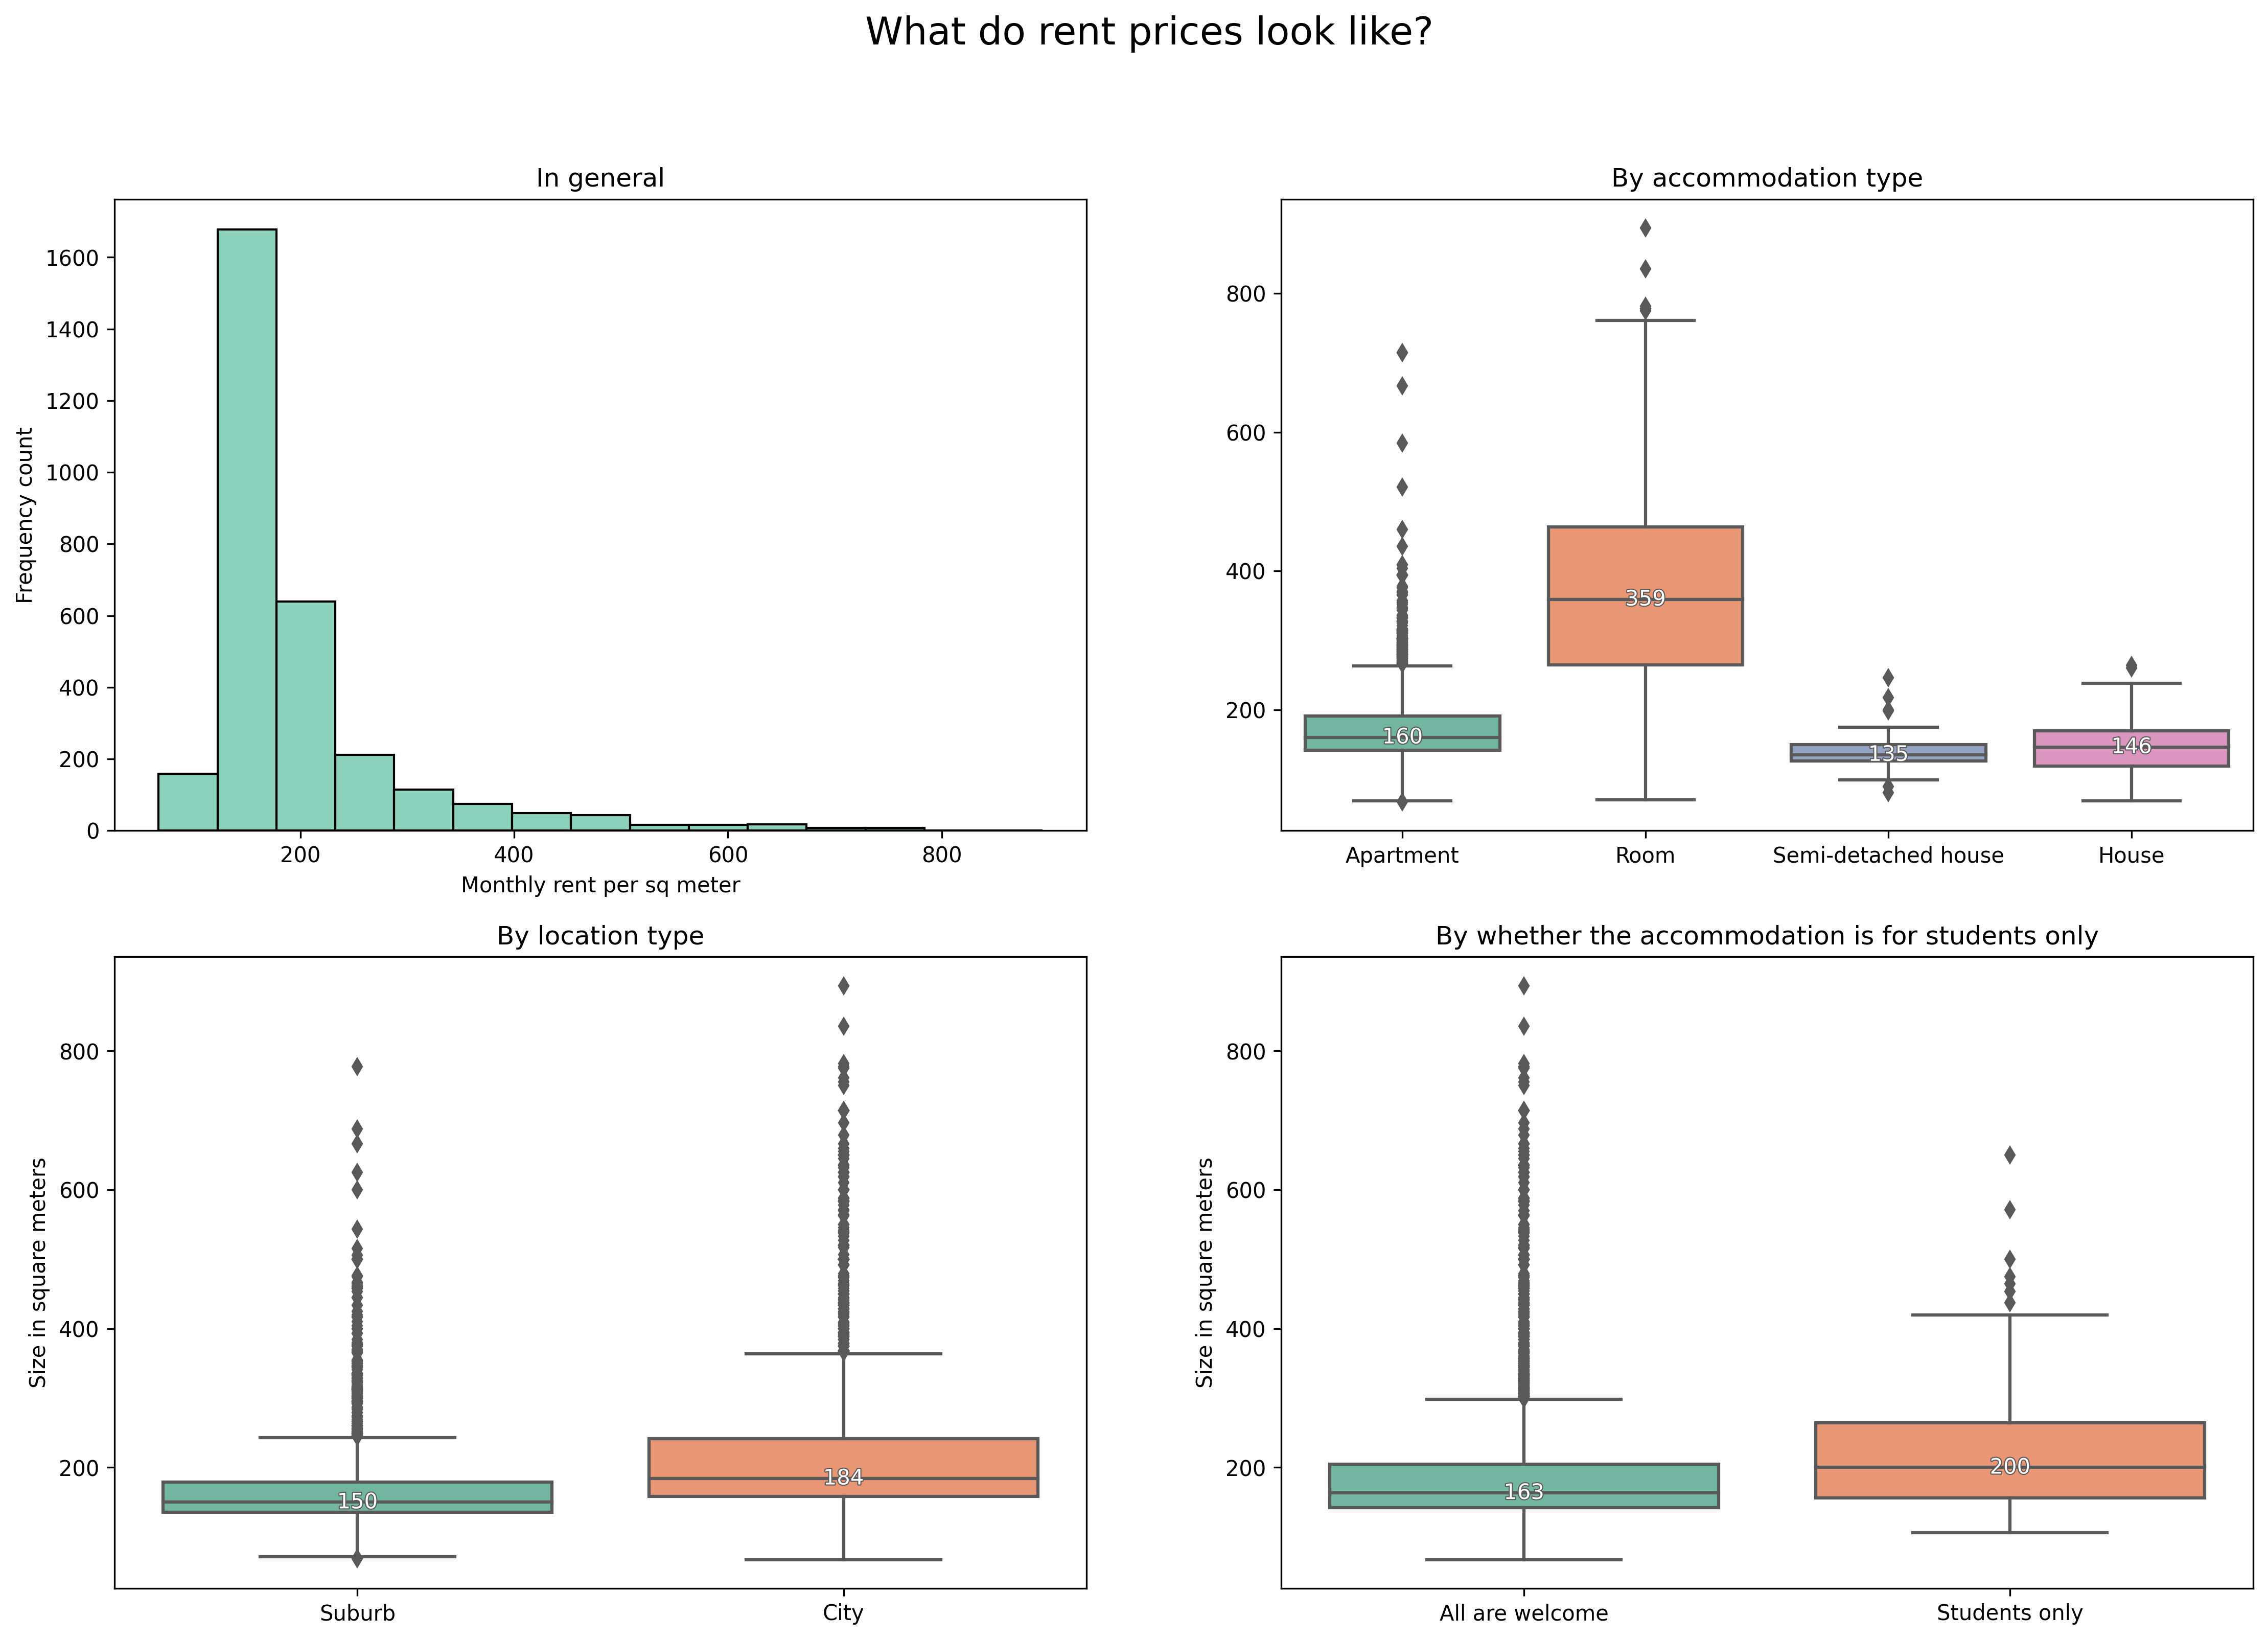

In [ ]:
# Preparing area for plotting of data
fig = plt.figure(figsize = (18, 12), dpi = 300)

# Making the 1st plot
ax1 = plt.subplot2grid((2, 2), (0, 0))
Plot1 = sns.histplot(x = Accommodations["MonthlyRentBySqM"], color = "#66C2A5", bins = 15)
plt.title("In general")
plt.xlabel("Monthly rent per sq meter")
plt.ylabel("Frequency count")

# Making the 2nd plot
ax1 = plt.subplot2grid((2, 2), (0, 1))
Plot2 = sns.boxplot(data = Accommodations, x = "AccommodationType", y = "MonthlyRentBySqM", palette = ColorPalette, ax = ax1)
plt.title("Distribution of rent per square meter by accommodation type")
plt.xlabel("Accommodation type")
plt.ylabel("Size in square meters")
AddMedianLabels(Plot2, fmt = ".0f")
plt.title("By accommodation type")
plt.xlabel("")
plt.ylabel("")

# Making the 3rd plot
ax1 = plt.subplot2grid((2, 2), (1, 0))
Plot3 = sns.boxplot(data = Accommodations, x = "LocationType", y = "MonthlyRentBySqM", palette = ColorPalette, ax = ax1)
plt.title("Distribution of rent per square meter by location type")
plt.xlabel("Accommodation type")
plt.ylabel("Size in square meters")
AddMedianLabels(Plot3, fmt = ".0f")
plt.title("By location type")
plt.xlabel("")
plt.ylabel("Size in square meters")

# Preparing data for the 4th plot
DataForChart = Accommodations.copy()
DataForChart["StudentsOnly"] = np.where(DataForChart["StudentsOnly"] == 1, "Students only", "All are welcome")

# Making the 4th plot
ax1 = plt.subplot2grid((2, 2), (1, 1))
Plot4 = sns.boxplot(data = DataForChart, x = "StudentsOnly", y = "MonthlyRentBySqM", palette = ColorPalette, ax = ax1)
plt.title("Distribution of rent per square meter by location type")
plt.xlabel("")
plt.ylabel("Monthly rent per square meter")
AddMedianLabels(Plot4, fmt = ".0f")
plt.title("By whether the accommodation is for students only")
plt.xlabel("")
plt.ylabel("Size in square meters")

# Finalizing output
plt.suptitle("What do rent prices look like?", fontsize = 18)
plt.show()

#### Does it pay off to go for a standalone one-room accommodation vs. getting a single room in a shared accommodation?

As the chart above shows, the average price per square meter is hire for single rooms. This naturally raises the question of whether it makes sense to rent a one-room apartment instead. Below, we compare the distributions of the two kinds of accommodation options.

**The figures below give us the following insights:**

* There is indeed a notable price difference between single rooms (assumed to be parts of shared accommodations) and one-room apartments when it comes to the price per square meter.
* Based on median price, one-room apartments are 43% cheaper than single rooms. In fact, if we look at the bottom 75% of all one-room apartments, prices will not exceed 245 kr. per square meter, whereas if we look at the bottom 75% of all single rooms, the price per square meter can be as high as 463 kr. (a difference of 89%).
* Based on these numbers, it makes more sense for single people to move into their own place (even if it's a one-room apartment) rather than share accommodation with other people (which though will likely give access to shared areas, which are not listed in the size of the single room).

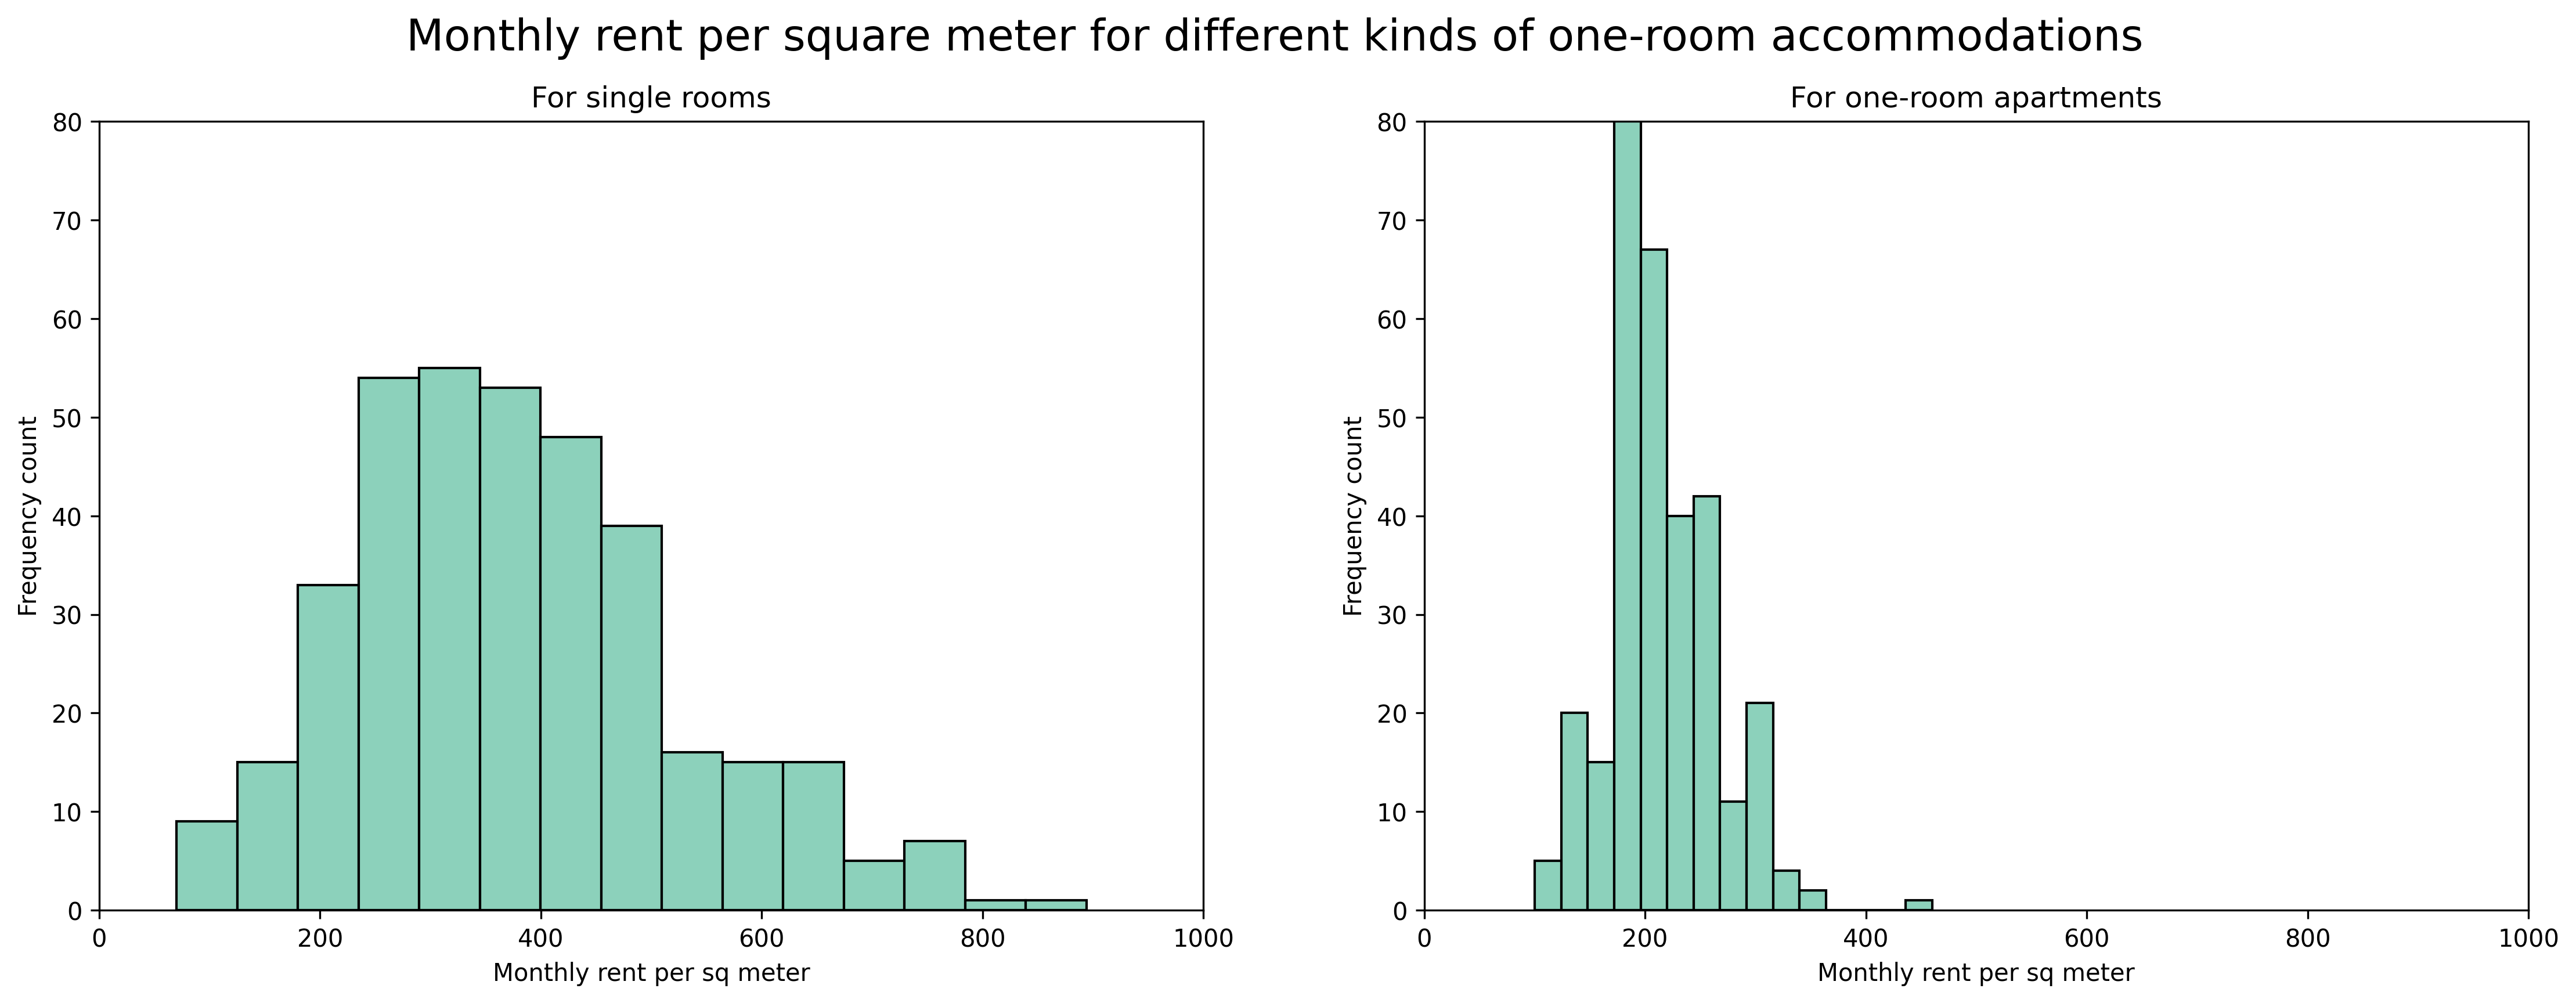

In [ ]:
# Preparing area for plotting of data
fig = plt.figure(figsize = (18, 6), dpi = 300)

# Filtering the data to identify the desired type of accommodations
SingleRooms = Accommodations[Accommodations["AccommodationType"] == "Room"].copy()
OneRoomApartments = Accommodations[(Accommodations["AccommodationType"] == "Apartment") \
                                   & (Accommodations["NumberOfRooms"] == 1)].copy()

# Making the 1st plot
ax1 = plt.subplot2grid((1, 2), (0, 0))
Plot1 = sns.histplot(x = SingleRooms["MonthlyRentBySqM"], color = "#66C2A5", bins = 15)
plt.xlim(0, 1000)
plt.ylim(0, 80)
plt.title("For single rooms")
plt.xlabel("Monthly rent per sq meter")
plt.ylabel("Frequency count")

# Making the 2nd plot
ax1 = plt.subplot2grid((1, 2), (0, 1))
Plot2 = sns.histplot(x = OneRoomApartments["MonthlyRentBySqM"], color = "#66C2A5", bins = 15)
plt.xlim(0, 1000)
plt.ylim(0, 80)
plt.title("For one-room apartments")
plt.xlabel("Monthly rent per sq meter")
plt.ylabel("Frequency count")

# Finalizing output
plt.suptitle("Monthly rent per square meter for different kinds of one-room accommodations", fontsize = 18)
plt.show()

In [ ]:
# Preparing some descriptives for the two kinds of accommodations
SingleRooms_Rent = pd.DataFrame(SingleRooms["MonthlyRentBySqM"].describe())
SingleRooms_Rent.columns = ["Single rooms"]

OneRoomApartments_Rent = pd.DataFrame(OneRoomApartments["MonthlyRentBySqM"].describe())
OneRoomApartments_Rent.columns = ["One-room apartments"]

# Putting the data together and printing a copy for the end user
SummaryData = pd.merge(SingleRooms_Rent, OneRoomApartments_Rent, how = "left", \
                       left_on = SingleRooms_Rent.index, right_on = OneRoomApartments_Rent.index)
SummaryData.rename(columns = {"key_0":"Statistic"}, inplace = True)
SummaryData

Statistic  Single rooms  One-room apartments
0     count    366.000000           320.000000
1      mean    378.118787           214.714145
2       std    149.177201            48.333674
3       min     70.000000           100.000000
4       25%    264.779412           188.888889
5       50%    359.166667           202.943723
6       75%    463.352273           244.911012
7       max    894.117647           460.000000

#### Are there any factors which might explain why student accommodations are more expensive (per square meter)?

Below, compare accommodations that are only available to students to accommodations where all kinds of renters are welcome on a number of key parameters which we find to be related to pricier accommodations, inlcuding accommodation type and location type (location is investigated in the following question's section).

**The figures below give us the following insights:**

* The location type split between student and regular accommodations is almost the same, so this is unlikely to drive the price difference.
* A bit under half of all student-only accommodations are single rooms (37%), which are known to be way more expensive per square meter than all other kinds of accommodation. The corresponding share of single rooms which are open to all renters is much lower at 11%.

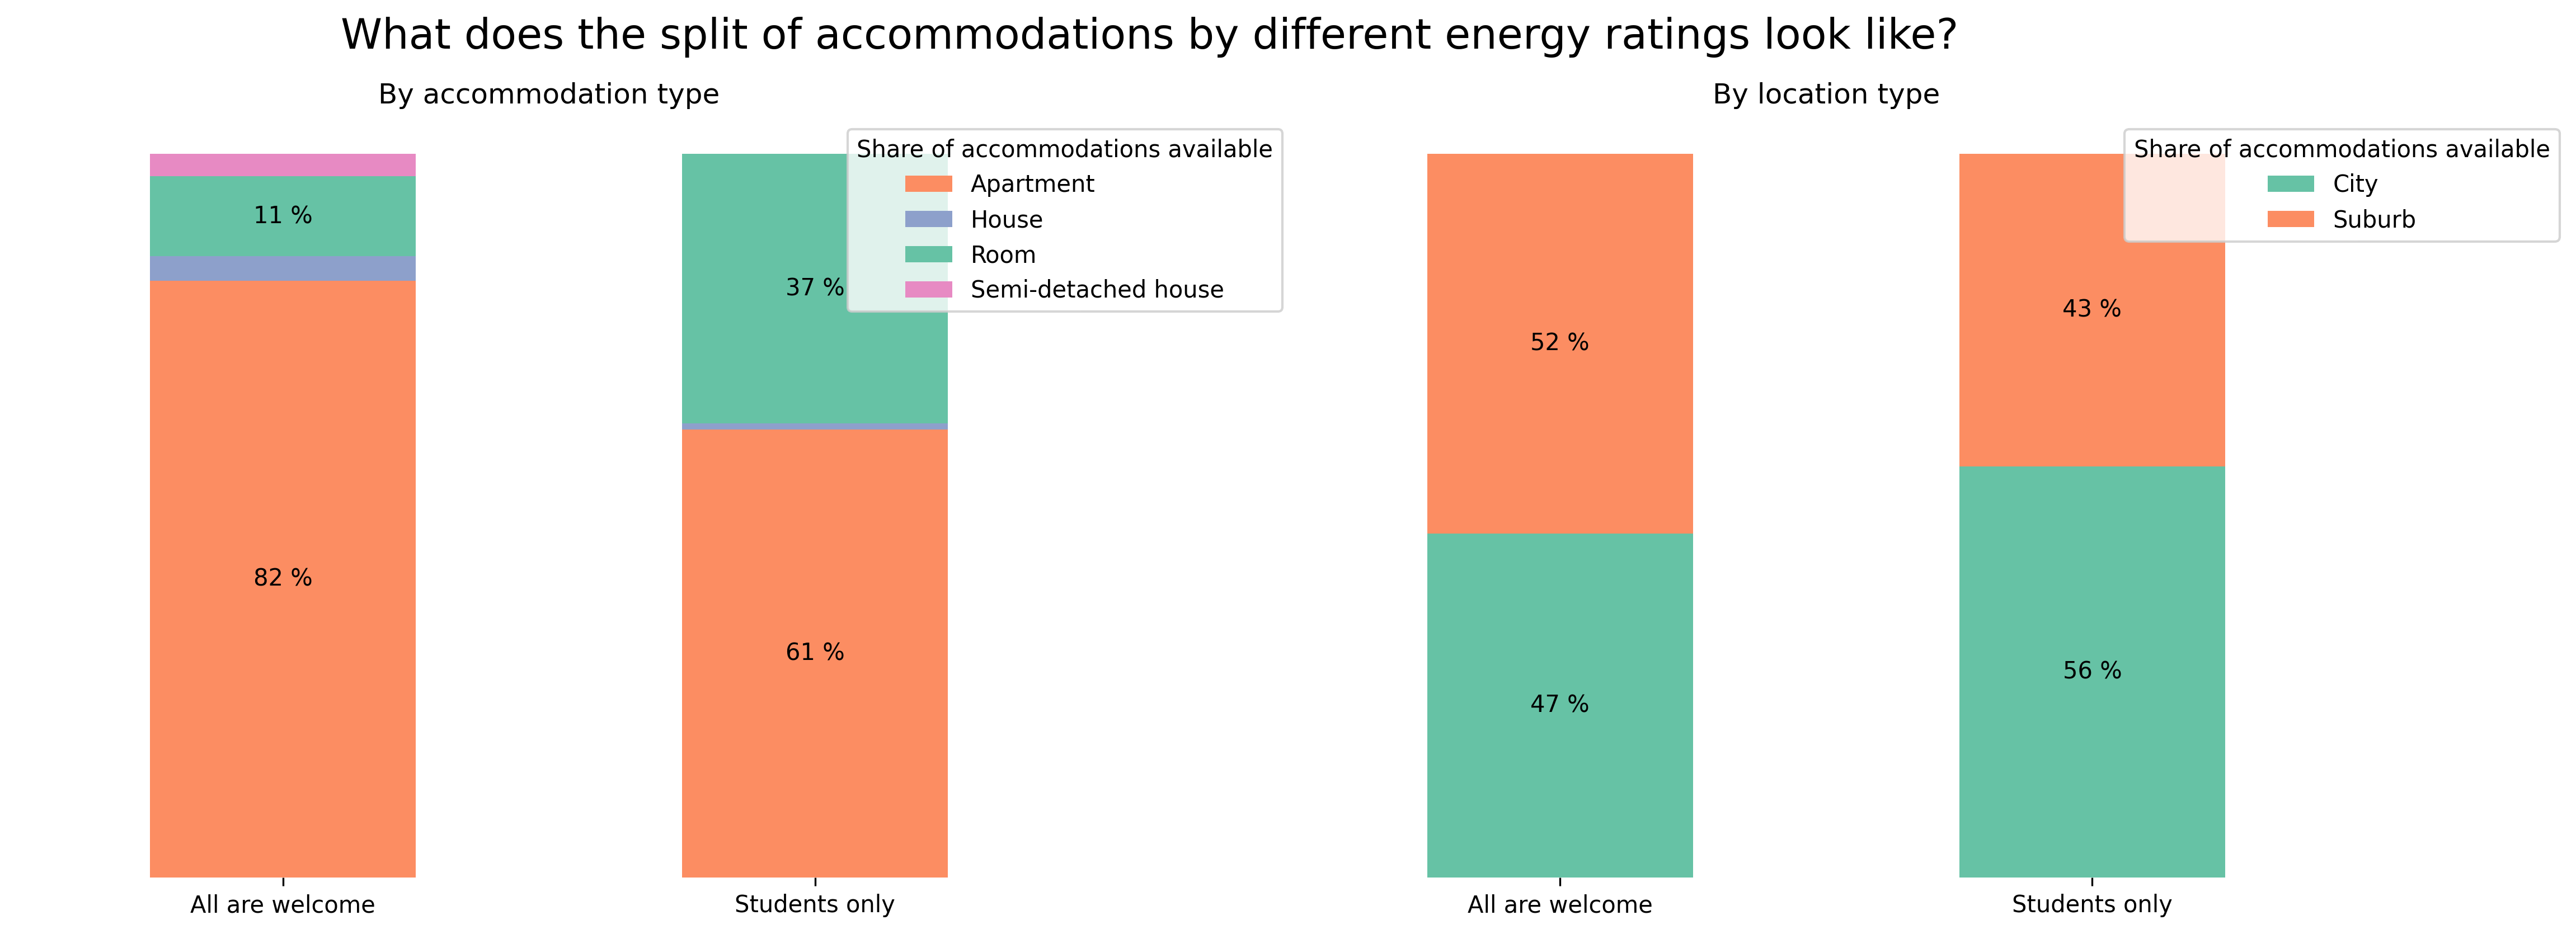

In [ ]:
# Preparing area for plotting of data
fig = plt.figure(figsize = (18, 6), dpi = 300)

# Preparing data for the 1st plot
DataForChart = Accommodations.copy()
DataForChart["StudentsOnly"] = np.where(DataForChart["StudentsOnly"] == 1, "Students only", "All are welcome")

SummaryData = DataForChart.copy()
SummaryData = SummaryData[SummaryData["AccommodationType"].notna()].copy()
x_var, y_var = "StudentsOnly", "AccommodationType"
SummaryData[y_var] = SummaryData[y_var].astype(str)
SummaryData = SummaryData.groupby(x_var)[y_var].value_counts(normalize = True).unstack(y_var)
SummaryData.fillna(0, inplace = True) # to prevent errors from arising when plotting the data

# Defining custom colors for charts made using pandas for the 1st plot
CustomColors = {"Room":"#66C2A5", "Apartment":"#FC8D62", "House":"#8DA0CB", "Semi-detached house":"#E78AC3"}

# Making the 1st plot
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax = plt.gca()
Plot1 = SummaryData.plot.bar(stacked = True, color = CustomColors, ax = ax1)
ShowValuesPandas(SummaryData)
plt.title("By accommodation type")
plt.legend(title = "Share of accommodations available", loc = "upper right", bbox_to_anchor = (1.2, 1))
plt.xlabel("")
plt.ylabel("")
plt.xticks(wrap = True, rotation = 0)
plt.yticks([], [])
HideBorders(ax1)

# Preparing data for the 2nd plot
SummaryData = DataForChart.copy()
DataForChart = SummaryData[SummaryData["LocationType"].notna()].copy()
x_var, y_var = "StudentsOnly", "LocationType"
SummaryData[y_var] = SummaryData[y_var].astype(str)
SummaryData = SummaryData.groupby(x_var)[y_var].value_counts(normalize = True).unstack(y_var)
SummaryData.fillna(0, inplace = True) # to prevent errors from arising when plotting the data

# Defining custom colors for charts made using pandas for the 2nd plot
CustomColors = {"City":"#66C2A5", "Suburb":"#FC8D62"}

# Making the 2nd plot
ax1 = plt.subplot2grid((1, 2), (0, 1))
ax = plt.gca()
Plot2 = SummaryData.plot.bar(stacked = True, color = CustomColors, ax = ax1)
ShowValuesPandas(SummaryData)
plt.title("By location type")
plt.legend(title = "Share of accommodations available", loc = "upper right", bbox_to_anchor = (1.2, 1))
plt.xlabel("")
plt.ylabel("")
plt.xticks(wrap = True, rotation = 0)
plt.yticks([], [])
HideBorders(ax1)

# Finalizing output
plt.suptitle("What does the split of accommodations by different energy ratings look like?", fontsize = 18)
plt.show()

#### Can we expect to pay more in rent for more energy-efficient accommodations?

It is reasonable to assume that a better energy efficiency is related to either the accommodation being located in a more recently constructed building or that it has come as a result of an investment in improving an old building. In both cases, we can assume that to also be related to a higher price. But is this truly the case? We explore this prospect in the charts below.

**The figures below give us the following insights:**

* There appears to be an inverse relationship between energy efficiency and geographic location, with rentals that have a better energy efficiency more likely to be located in the city than in the suburbs.
* By far, the cheapest rent per sqm is found in "D+"-rated accommodations (163 kr.), however, this is likely related to the geographical placement of these accommodations, with 58% of them being located in the suburbs.
* Meanwhile, the rent per sqm for "A"-rated accommodations is only marginally higher (164 kr.), even though only 42% of these rentals are located in the suburbs.
* Finally, "C"-rated accommodations appear to be somewhat more expensive than either "A" or "D+" rated accommodations, as evidenced by their median and their distributions' bottom 75% limit.
* Overall, we can hypothesize that it's cheaper to live in an "A"-rated place due to its improved energy efficiency, while it's cheaper to live in a "D"-rated place due to it being placed farther away from the city (testing these hypotheses requires more than just looking at charts and is outside of scope for the current notebook).

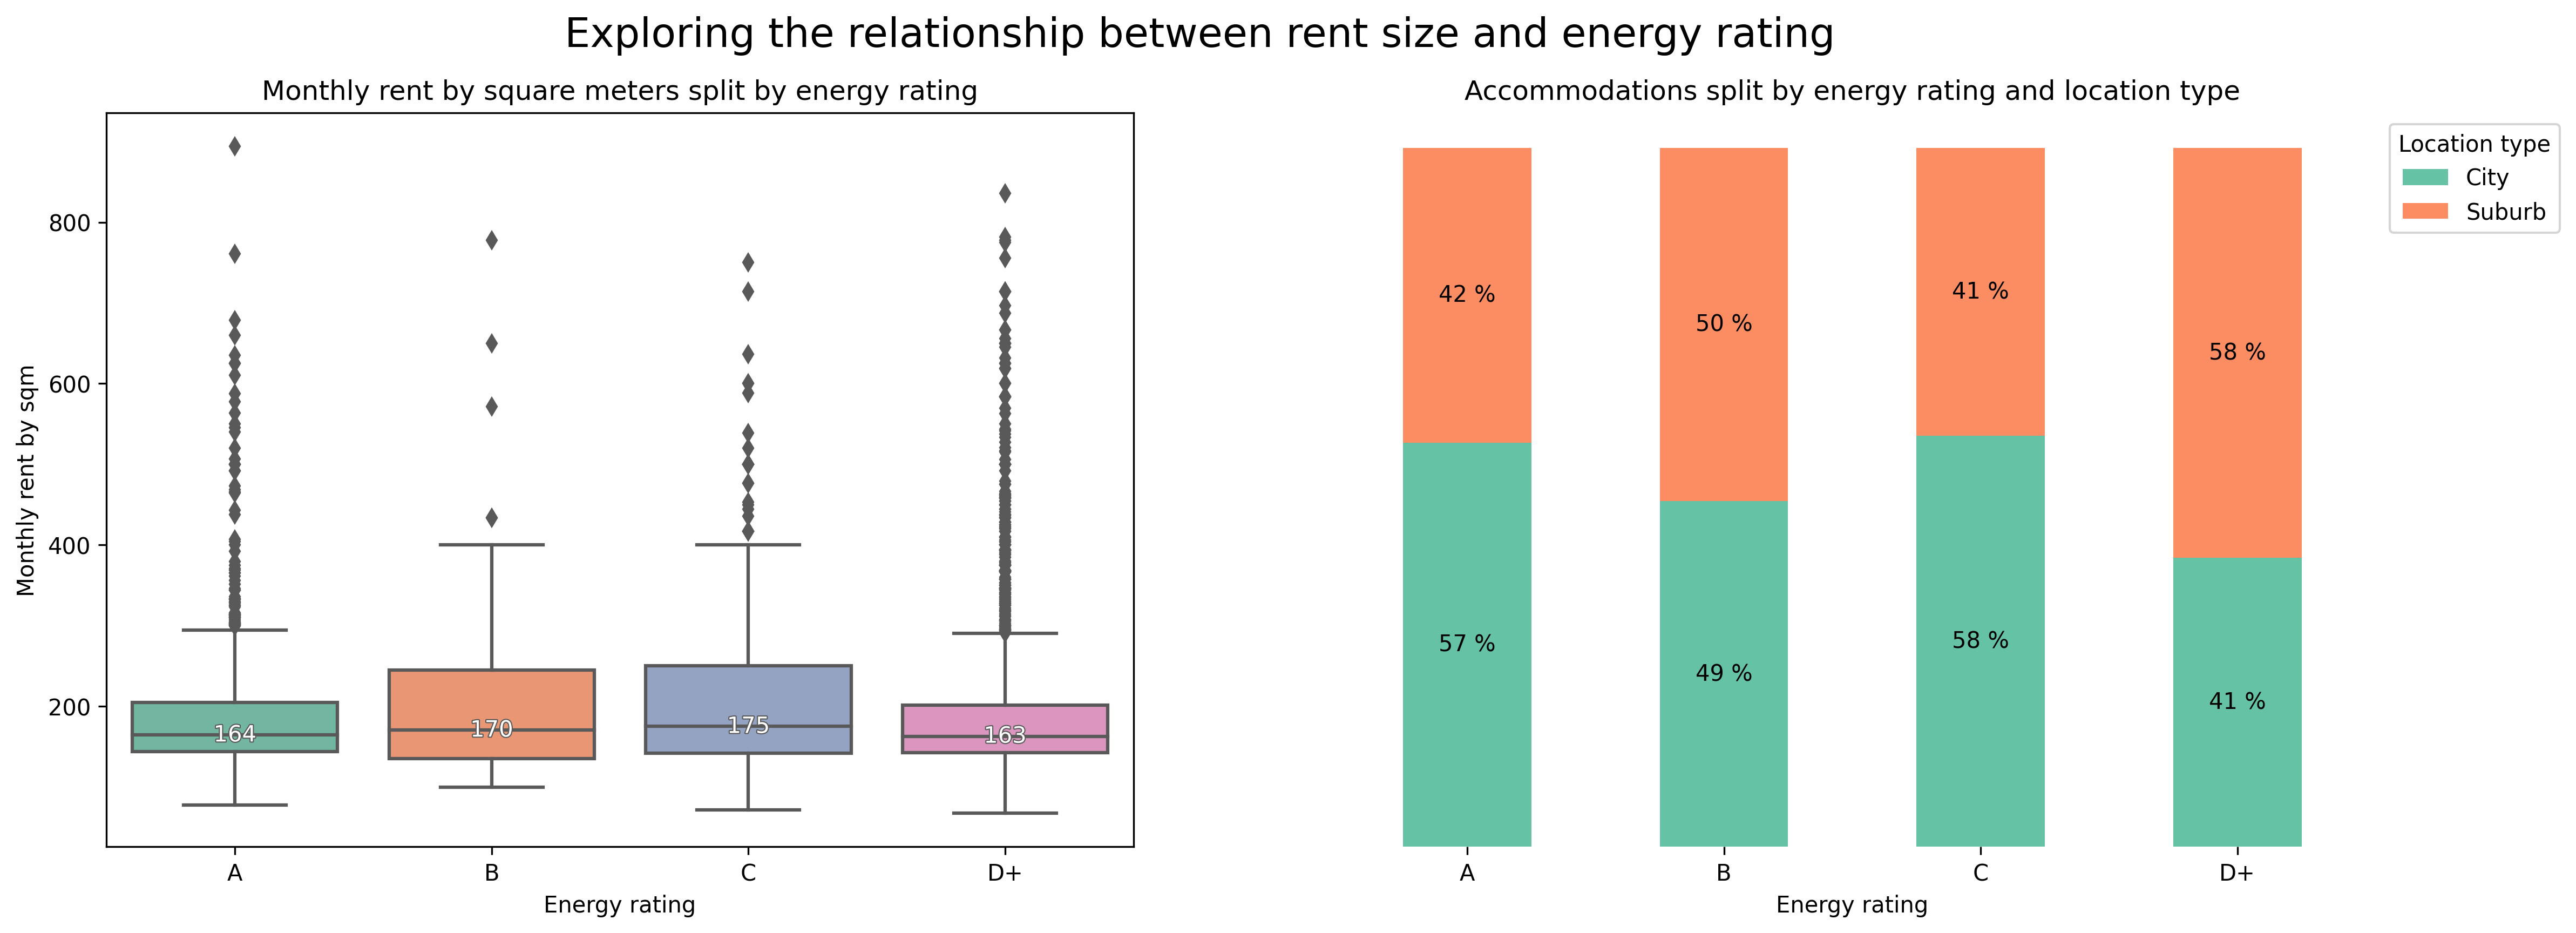

In [ ]:
# Preparing area for plotting of data
fig = plt.figure(figsize = (18, 6), dpi = 300)

# Temporary dataframe where the energy ratings are grouped together
DataForChart = Accommodations.copy()

Conditions = [(DataForChart.EnergyRating.isin(["A10", "A15", "A20"])),
              (DataForChart.EnergyRating == "B"),
              (DataForChart.EnergyRating == "C"),
              (DataForChart.EnergyRating.isin(["D", "E", "F", "G", np.nan]))]

Values = ["A", "B", "C", "D+"]
DataForChart["EnergyRating"] = np.select(Conditions, Values)
DataForChart.sort_values("EnergyRating", ascending = True, inplace = True)

# Making the 1st plot
ax1 = plt.subplot2grid((1, 2), (0, 0))
Plot = sns.boxplot(data = DataForChart, x = "EnergyRating", y = "MonthlyRentBySqM", palette = ColorPalette, ax = ax1)
plt.title("Monthly rent by square meters split by energy rating")
AddMedianLabels(Plot, fmt = ".0f")
plt.xlabel("Energy rating")
plt.ylabel("Monthly rent by sqm")

# Preparing data for the 2nd plot
SummaryData = DataForChart.copy()
x_var, y_var = "EnergyRating", "LocationType"
SummaryData[y_var] = SummaryData[y_var].astype(str)
SummaryData = SummaryData.groupby(x_var)[y_var].value_counts(normalize = True).unstack(y_var)
SummaryData.fillna(0, inplace = True) # to prevent errors from arising when plotting the data

# Defining custom colors for charts made using pandas for the 2nd plot
CustomColors = {"City":"#66C2A5", "Suburb":"#FC8D62"}

# Making the 2nd plot
ax1 = plt.subplot2grid((1, 2), (0, 1))
ax = plt.gca()
Plot2 = SummaryData.plot.bar(stacked = True, color = CustomColors, ax = ax1)
ShowValuesPandas(SummaryData)
plt.title("Accommodations split by energy rating and location type")
plt.legend(title = "Location type", loc = "upper right", bbox_to_anchor = (1.2, 1))
plt.xlabel("Energy rating")
plt.ylabel("")
plt.xticks(wrap = True, rotation = 0)
plt.yticks([], [])
HideBorders(ax1)

# Finalizing output
plt.suptitle("Exploring the relationship between rent size and energy rating", fontsize = 18)
plt.show()

#### Is scarcity in an area affecting the price of the rentals?

Another angle worth exploring is whether the  number of accommodations available in a certain area is affecting the rent price per sqm. On the charts below, we explore this by looking at both the exact location (useful for rentals located in the same/adjacent buildings) and an approximate location (useful for rentals located in the same neighborhoods). In addition, we take the general location type in consideration so as to be able to distinguish between accommodations located in the city vs. those located in the suburbs.

Please note that in order to calculate the number of rentals available in different areas, we round off the GSP coordinates to 2 and 3 decimals respectively. These are then used as the definitions for different areas.

**The figures below give us the following insights:**

* Overall, we see a negative relationship between the number of accommodations available in a certain area and the monthly rent for these accommodations, regardless of whether we look at GPS coordinates rounded off to 2 or 3 decimals.
* This relationship is substantiated across both accommodations located in the city and accommodations located in the suburbs, although we can also see that there is more variability among city-based accommodations, meaning the relationship between price and scarcity in there is less strong than it is in the suburbs.

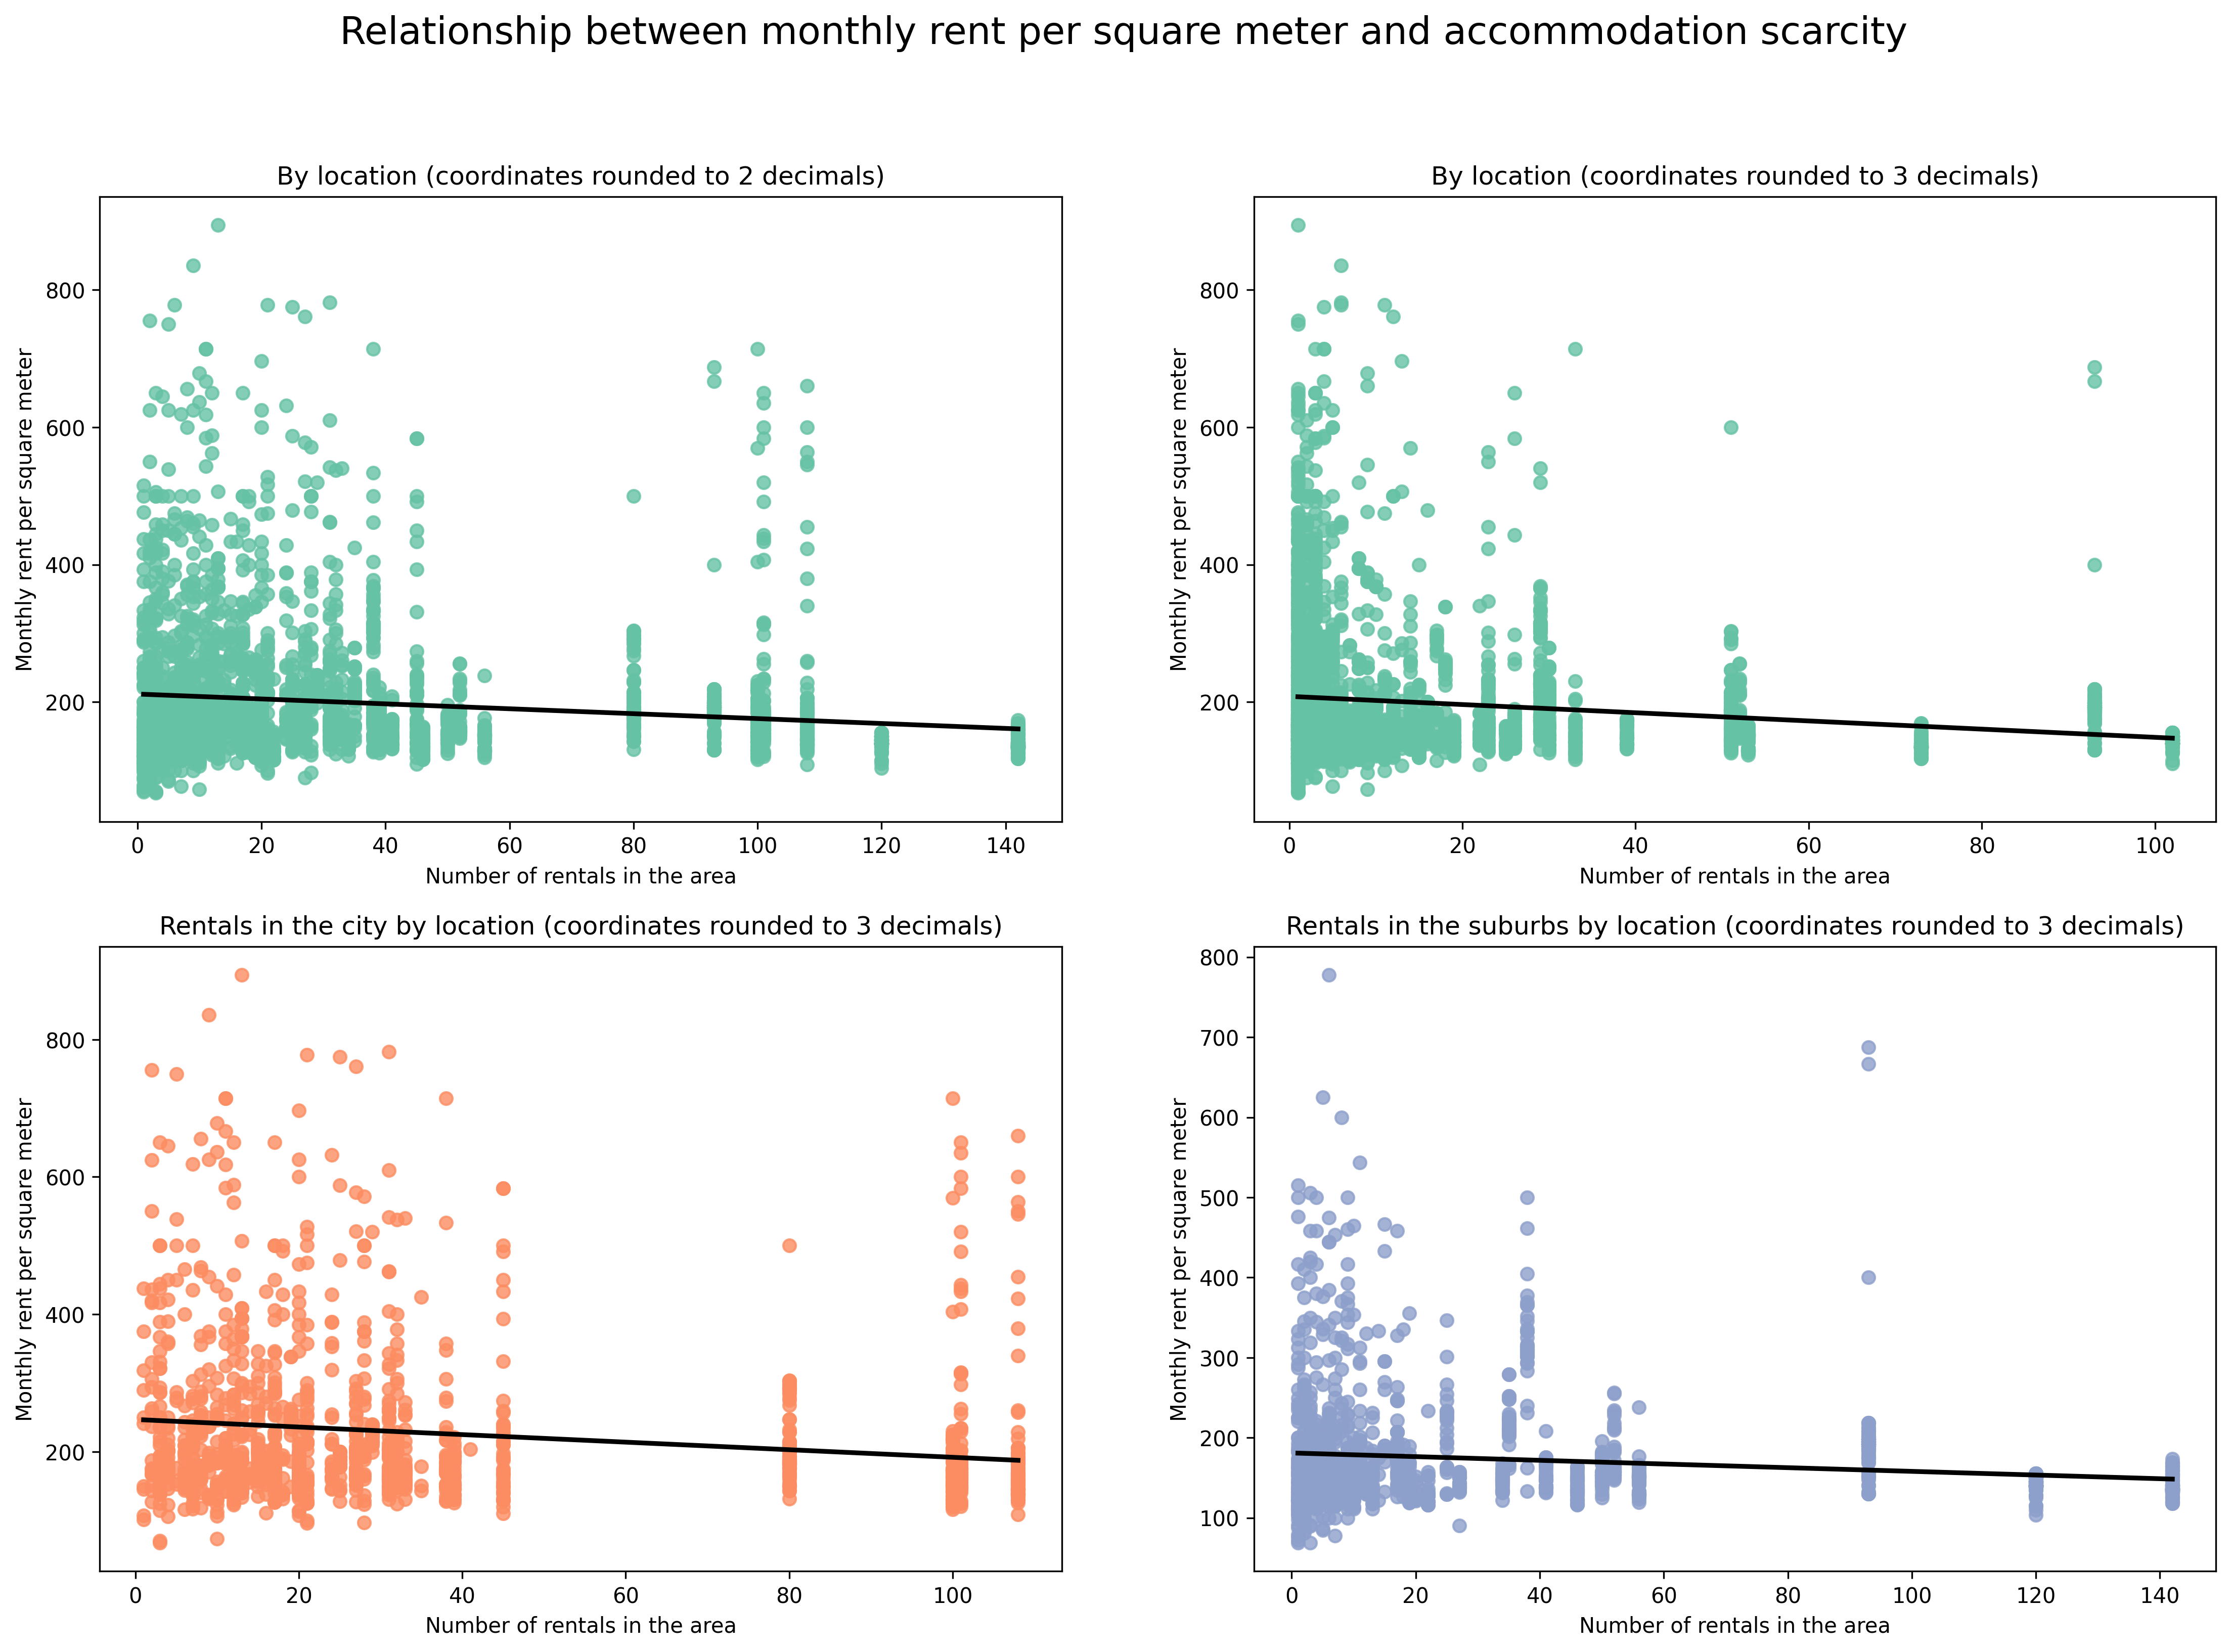

In [ ]:
# Preparing area for plotting of data
fig = plt.figure(figsize = (18, 12), dpi = 300)

# Calculating additional columns for answering this specific question
DataForChart = Accommodations.copy()
DataForChart = DataForChart[(DataForChart["Latitude"].notna()) & (DataForChart["Longitude"].notna())].copy()
DataForChart.rename(columns = {"Latitude":"LatitudeL3", "Longitude":"LongitudeL3"}, inplace = True)
DataForChart["LatitudeL2"] = np.round(DataForChart["LatitudeL3"], 3)
DataForChart["LatitudeL1"] = np.round(DataForChart["LatitudeL3"], 2)
DataForChart["LongitudeL2"] = np.round(DataForChart["LongitudeL3"], 3)
DataForChart["LongitudeL1"] = np.round(DataForChart["LongitudeL3"], 2)

# Aggregating data on number of listings for each location (at different levels)
DataForChart["EntriesForLocationL1"] = DataForChart.groupby(["LatitudeL1", "LongitudeL1"])["Link"].transform("nunique")
DataForChart["EntriesForLocationL2"] = DataForChart.groupby(["LatitudeL2", "LongitudeL2"])["Link"].transform("nunique")
DataForChart["EntriesForLocationL3"] = DataForChart.groupby(["LatitudeL3", "LongitudeL3"])["Link"].transform("nunique")

# Making the 1st plot
ax1 = plt.subplot2grid((2, 2), (0, 0))
Plot1 = sns.regplot(x = DataForChart["EntriesForLocationL1"], y = DataForChart["MonthlyRentBySqM"], ci = None, color = "#66C2A5", line_kws = {"color":"#000000"})
plt.title("By location (coordinates rounded to 2 decimals)")
plt.xlabel("Number of rentals in the area")
plt.ylabel("Monthly rent per square meter")

# Making the 2nd plot
ax1 = plt.subplot2grid((2, 2), (0, 1))
Plot2 = sns.regplot(x = DataForChart["EntriesForLocationL2"], y = DataForChart["MonthlyRentBySqM"], ci = None, color = "#66C2A5", line_kws = {"color":"#000000"})
plt.title("By location (coordinates rounded to 3 decimals)")
plt.xlabel("Number of rentals in the area")
plt.ylabel("Monthly rent per square meter")

# Filtering the data for the 3rd plot
DataForPlot3 = DataForChart[DataForChart["LocationType"] == "City"].copy()

# Making the 3rd plot
ax1 = plt.subplot2grid((2, 2), (1, 0))
Plot3 = sns.regplot(x = DataForPlot3["EntriesForLocationL1"], y = DataForPlot3["MonthlyRentBySqM"], ci = None, color = "#FC8D62", line_kws = {"color":"#000000"})
plt.title("Rentals in the city by location (coordinates rounded to 3 decimals)")
plt.xlabel("Number of rentals in the area")
plt.ylabel("Monthly rent per square meter")

# Filtering the data for the 4th plot
DataForPlot4 = DataForChart[DataForChart["LocationType"] == "Suburb"].copy()

# Making the 4th plot
ax1 = plt.subplot2grid((2, 2), (1, 1))
Plot4 = sns.regplot(x = DataForPlot4["EntriesForLocationL1"], y = DataForPlot4["MonthlyRentBySqM"], ci = None, color = "#8DA0CB", line_kws = {"color":"#000000"})
plt.title("Rentals in the suburbs by location (coordinates rounded to 3 decimals)")
plt.xlabel("Number of rentals in the area")
plt.ylabel("Monthly rent per square meter")

# Finalizing output
plt.suptitle("Relationship between monthly rent per square meter and accommodation scarcity", fontsize = 18)
plt.show()

### Which are the most and least expensive areas to live in?

Below, we examine different parts of the Greater Copenhagen area in order to see where the most expensive accommodations are located. As price can naturally be assumed to be related to size, we adjust the **monthly rent** by the number of square meters associated with each accommodation.

**The figure below gives us the following insights:**

* Prices per square meter vary greatly depending on location.
* There seems to be a relationship between geographic location and price per square meter in that areas that lie closer to the city center being much more expensive to live in.
* Even within minicipalities other than Copenhagen and Frederiksberg, the closer you move to the local center of the municipality, the higher the price per square meter you should expect to pay.

In [ ]:
# Preparing data for chart
DataForChart = Accommodations.copy()
DataForChart = DataForChart[(DataForChart["Latitude"].notna()) & (DataForChart["Longitude"].notna())]
DataForChart["Mean price per sq meter"] = DataForChart.groupby(["Latitude", "Longitude"])["MonthlyRentBySqM"].transform("mean")
DataForChart.drop_duplicates(subset = ["Latitude", "Longitude"], inplace = True)

# Preparing and displaying the chart
Chart = px.density_mapbox(DataForChart, lat = "Latitude", lon = "Longitude", z = "Mean price per sq meter",
                        mapbox_style = "carto-positron", color_continuous_scale = "Spectral", opacity = 0.5)
Chart

An alternative way of looking at it is to examine the distribution of monthly rent per square meter at the municipality level. The figure below revelas that the 3 **most expensive** municipalities to rent in are Frederiksberg, Gentofte and Gladsaxe, while the 3 **cheapest** municipalities are Egedal, Glostrup and Vallensbæk respectively.

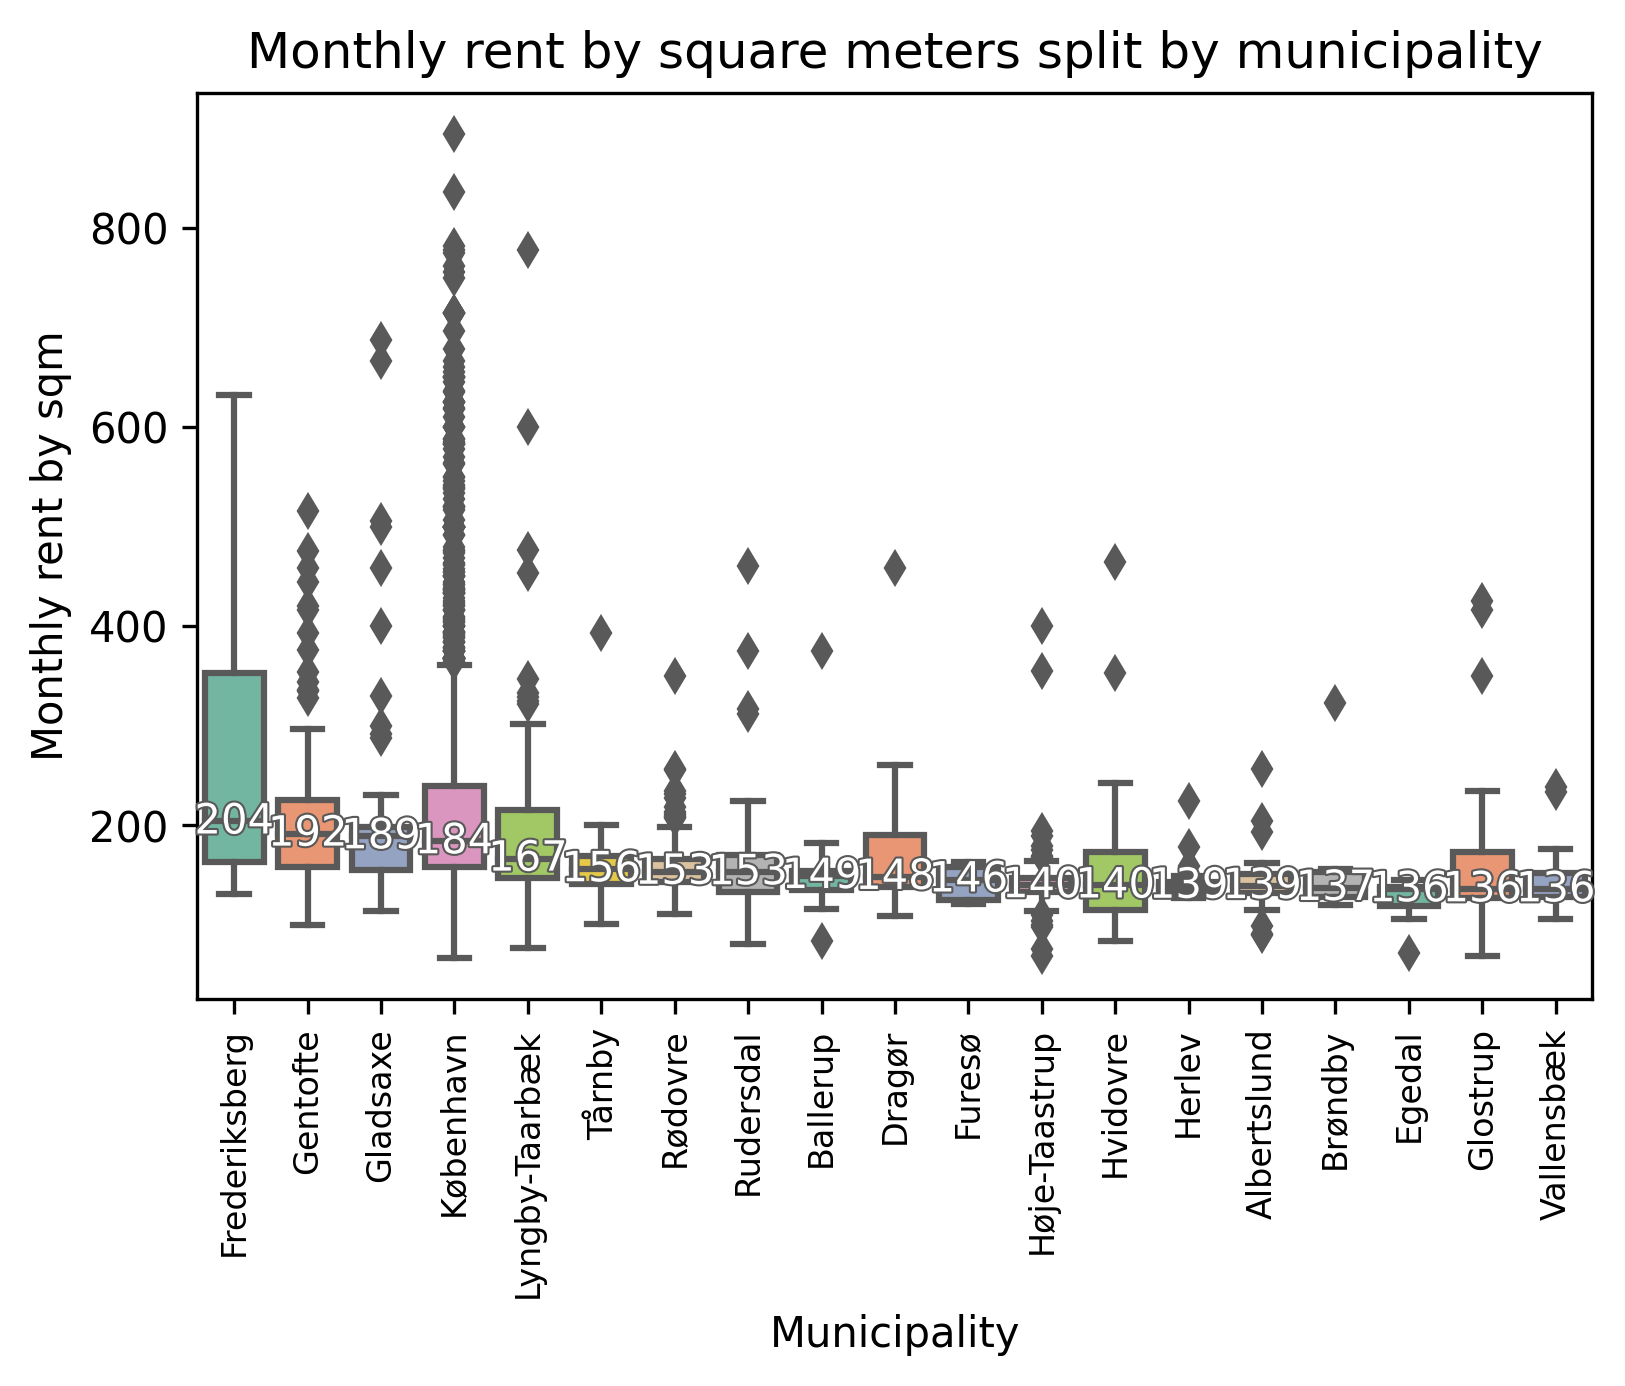

In [ ]:
# Preparing data for chart
DataForChart = Accommodations[Accommodations["Municipality"].notna()].copy()
DataForChart["MedianPerMunicipality"] = DataForChart.groupby("Municipality")["MonthlyRentBySqM"].transform("median")
DataForChart.sort_values("MedianPerMunicipality", ascending = False, inplace = True)

# Creating a chart
Plot = sns.boxplot(data = DataForChart, x = "Municipality", y = "MonthlyRentBySqM", palette = ColorPalette)
plt.title("Monthly rent by square meters split by municipality")
AddMedianLabels(Plot, fmt = ".0f")
plt.xlabel("Municipality")
plt.ylabel("Monthly rent by sqm")
plt.xticks(rotation = 90, fontsize = 8)
plt.show()


### How often do we have monthly aconto and how much is it relative to rent/accommodation size?

Below, we examine the subject of how often we have aconto in addition to the monthly rent as well as how the size of the aconto payment is related to the size of the rent and the size of the accommodation.

**The figures below give us the following insights:**

* Aconto is quite a common occurrence for rentals in the Greater Copenhagen area, with 81% of all rentals having it in addition to the monthly rent.
* Aconto seems to be similarly correlated to both monthly rent (unadjusted for accommodation size) (Pearson's *r* = 0.38) and to the size of the accommodation (Pearson's *r*=0.51), although the the scatter plots further down the page show that there are also plenty of outliers.
* On average, you should expect to pay an aconto that roughly corresponds to 6.4% of the size of your monthly rent (unadjusted for accommodation size) and in 75% of all cases, you should expect to pay a value corresponding to less than 6.7% of your monthly rent.
* Alternatively, you should on average expect to pay an aconto that roughly corresponds to 12.45 DKK per square meter and in 75% of all cases, that value will not exceed 13.22 DKK per square meter. That means that for a 50 square meters place, you should expect to pay 661 DKK in monthly aconto.
* When it comes to whether a better energy efficiency rating results in a lower aconto payment, the conclusion is slightly convoluted. Looking at the median aconto per square meter, it would appear that "C"-rated accommodations are the cheapest (9.79 DKK per sqm).
* However, it must be noted that we do have a considerable number of outliers, and that for "D+"-rated accommodations, one may end up paying a lot more than in better rated accommodations. Meaning that as far as the aconto payment is concerned, it does make sense to move in a more energy-efficient place.

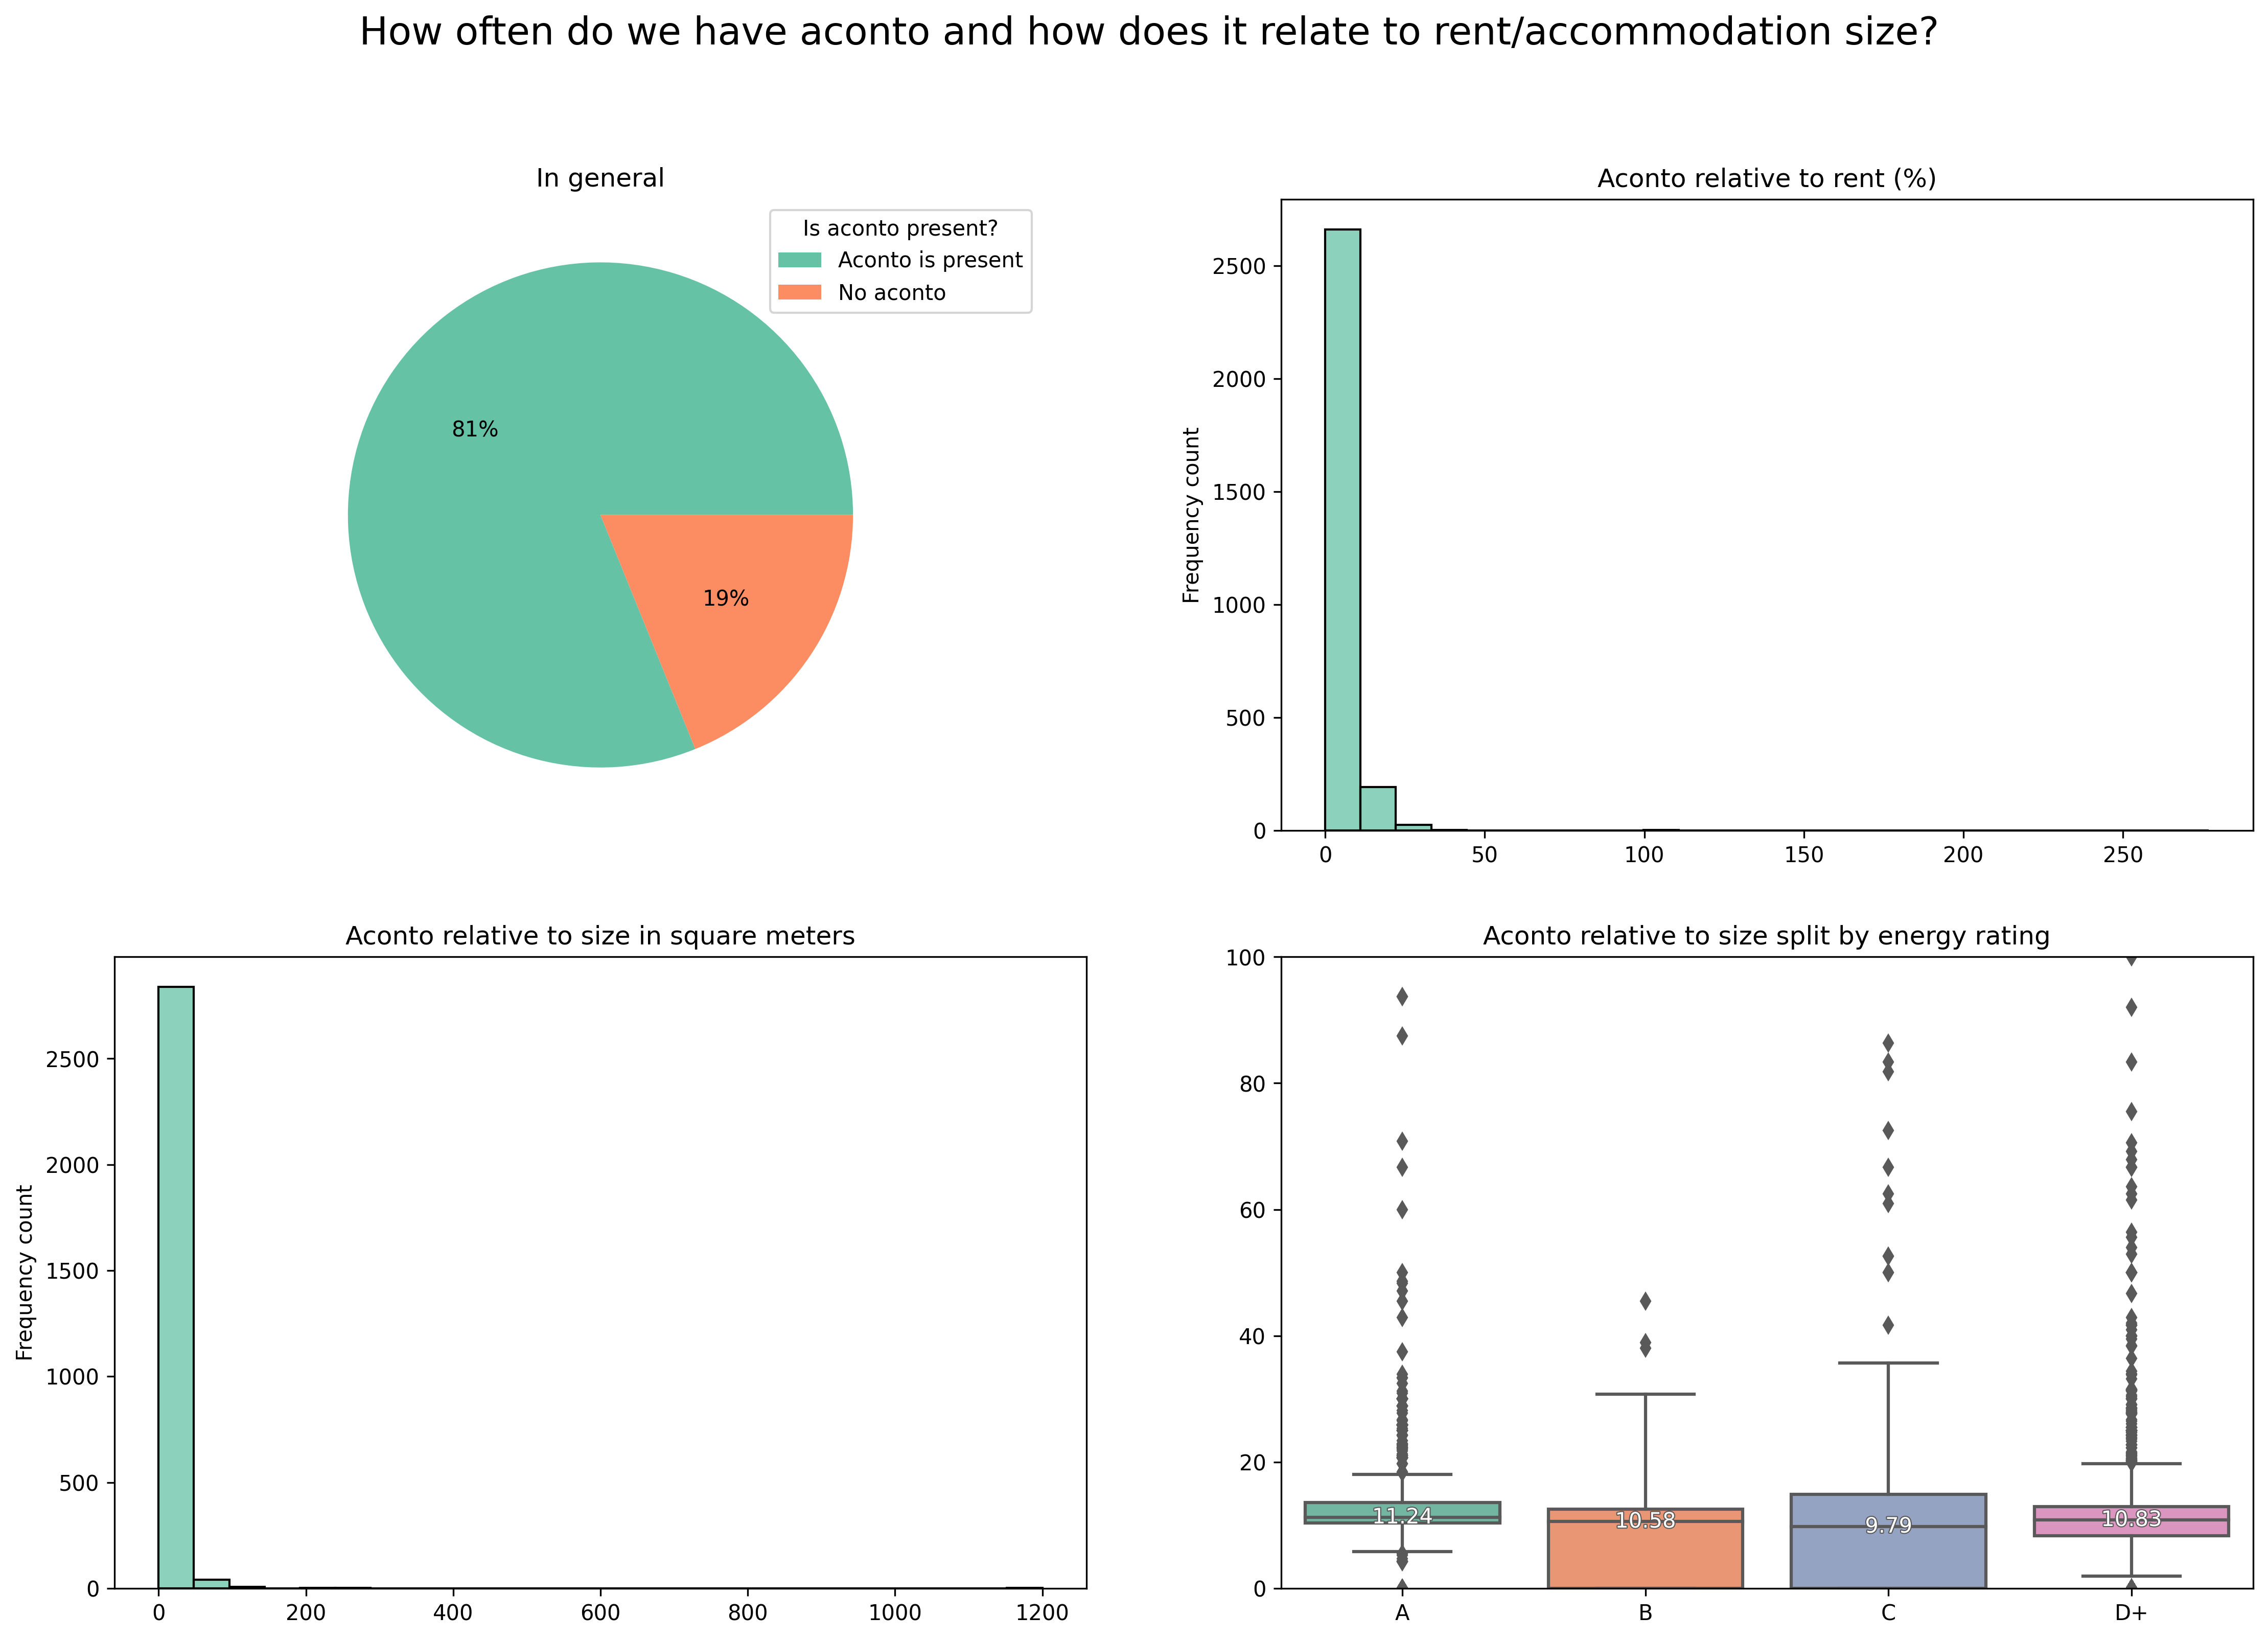

In [ ]:
# Preparing area for plotting of data
fig = plt.figure(figsize = (18, 12), dpi = 300)

# Temporary dataframe where the energy ratings are grouped together
DataForChart = Accommodations.copy()

Conditions = [(DataForChart.EnergyRating.isin(["A10", "A15", "A20"])),
              (DataForChart.EnergyRating == "B"),
              (DataForChart.EnergyRating == "C"),
              (DataForChart.EnergyRating.isin(["D", "E", "F", "G", np.nan]))]

Values = ["A", "B", "C", "D+"]
DataForChart["EnergyRating"] = np.select(Conditions, Values)
DataForChart.sort_values("EnergyRating", ascending = True, inplace = True)

# Calculating additional columns for answering this specific question
DataForChart["AcontoIsPresent"] = np.where(DataForChart["Aconto"] > 0, "Aconto is present", "No aconto")
DataForChart["AcontoRelativeToRentPct"] = np.round((DataForChart["Aconto"]/DataForChart["MonthlyRent"]) * 100, 2)
DataForChart["AcontoRelativeToSize"] = DataForChart["Aconto"]/DataForChart["SizeSquareMeters"]

# Defining custom colors for charts made using pandas
CustomColors = {"1-11 months":"#66C2A5", "12-23 months":"#FC8D62", "24+ months":"#8DA0CB", "Unlimited":"#E78AC3"}

# Preparing data for the 1st plot
VarsOfInterest = ["AcontoIsPresent"]
SummaryData = DataForChart.copy()
SummaryData["NumberOfListings"] = SummaryData.groupby(VarsOfInterest)["Link"].transform("nunique")
SummaryData.sort_values(VarsOfInterest, inplace = True)
SummaryData.drop_duplicates(subset = VarsOfInterest, inplace = True)

# Making the 1st plot
ax1 = plt.subplot2grid((2, 2), (0, 0))
Plot1 = plt.pie(SummaryData["NumberOfListings"], colors = ColorPalette, autopct = '%.0f%%')
plt.title("In general")
plt.legend(title = "Is aconto present?", labels = SummaryData["AcontoIsPresent"], loc = "upper right", bbox_to_anchor = (1.2, 1))

# Making the 2nd plot
ax1 = plt.subplot2grid((2, 2), (0, 1))
Plot1 = sns.histplot(x = DataForChart["AcontoRelativeToRentPct"], color = "#66C2A5", bins = 25)
plt.title("Aconto relative to rent (%)")
plt.xlabel("")
plt.ylabel("Frequency count")

# Making the 3rd plot
ax1 = plt.subplot2grid((2, 2), (1, 0))
Plot1 = sns.histplot(x = DataForChart["AcontoRelativeToSize"], color = "#66C2A5", bins = 25)
plt.title("Aconto relative to size in square meters")
plt.xlabel("")
plt.ylabel("Frequency count")

# Making the 4th plot
ax1 = plt.subplot2grid((2, 2), (1, 1))
Plot4 = sns.boxplot(data = DataForChart, x = "EnergyRating", y = "AcontoRelativeToSize", palette = ColorPalette, ax = ax1)
plt.title("Aconto relative to size split by energy rating")
plt.xlabel("Accommodation type")
plt.ylabel("Size in square meters")
plt.ylim(0, 100)
AddMedianLabels(Plot4, fmt = ".2f")
plt.xlabel("")
plt.ylabel("")

# Finalizing output
plt.suptitle("How often do we have aconto and how does it relate to rent/accommodation size?", fontsize = 18)
plt.show()

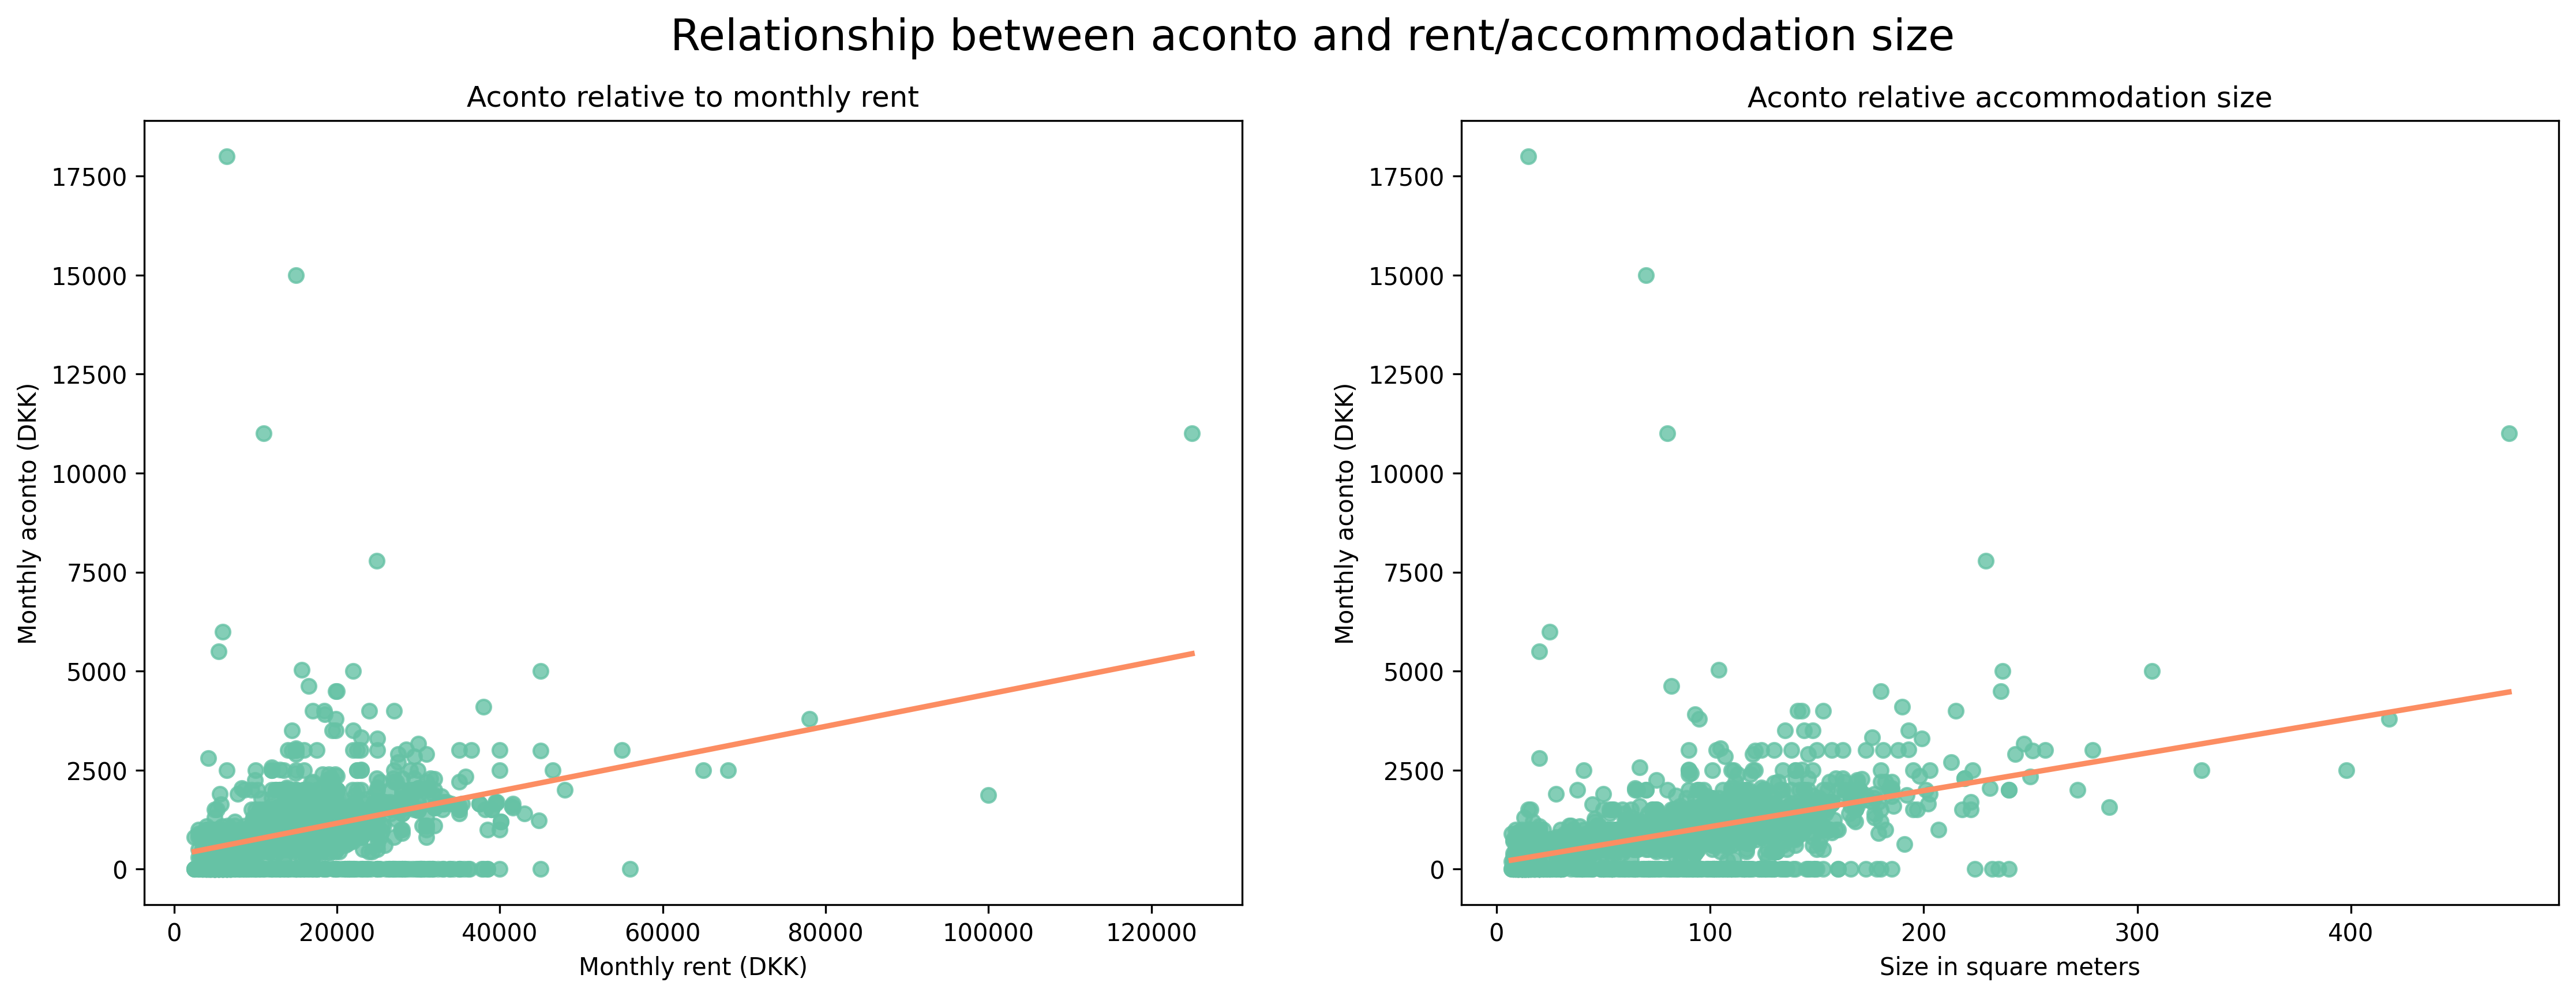

In [ ]:
# Preparing area for plotting of data
fig = plt.figure(figsize = (18, 6), dpi = 300)

# Calculating additional columns for answering this specific question
DataForChart = Accommodations.copy()
DataForChart["AcontoIsPresent"] = np.where(DataForChart["Aconto"] > 0, "Aconto is present", "No aconto")
DataForChart["AcontoRelativeToRentPct"] = np.round((DataForChart["Aconto"]/DataForChart["MonthlyRent"]) * 100, 2)
DataForChart["AcontoRelativeToSize"] = DataForChart["Aconto"]/DataForChart["SizeSquareMeters"]

# Making the 1st plot
ax1 = plt.subplot2grid((1, 2), (0, 0))
Plot1 = sns.regplot(x = DataForChart["MonthlyRent"], y = DataForChart["Aconto"], ci = None, color = "#66C2A5", line_kws = {"color":"#FC8D62"})
plt.title("Aconto relative to monthly rent")
plt.xlabel("Monthly rent (DKK)")
plt.ylabel("Monthly aconto (DKK)")

# Making the 2nd plot
ax1 = plt.subplot2grid((1, 2), (0, 1))
Plot1 = sns.regplot(x = DataForChart["SizeSquareMeters"], y = DataForChart["Aconto"], ci = None, color = "#66C2A5", line_kws = {"color":"#FC8D62"})
plt.title("Aconto relative accommodation size")
plt.xlabel("Size in square meters")
plt.ylabel("Monthly aconto (DKK)")

# Finalizing output
plt.suptitle("Relationship between aconto and rent/accommodation size", fontsize = 18)
plt.show()

### Is rent most strongly related to the number of rooms or the physical size of the accommodation?

Below, we take a look at the relationships between monthly rent (unadjusted) and the physical size of the accommodation (measured in square meters) as well as the number of rooms available.

**The figures below give us the following insights:**

* As expected, the bigger the accommodation is, the more we can expect it to cost. This is corroborated by both the size in square meters and the size as judged by the number of rooms available.
* However, the relationship between monthly rent and size measured in square meters appears to be stronger than the one that's based on number of rooms, as evidenced by the better fit and the lower number of outliers. This suggests that size in sqm will likely be a better predictor of rent price than number of rooms.

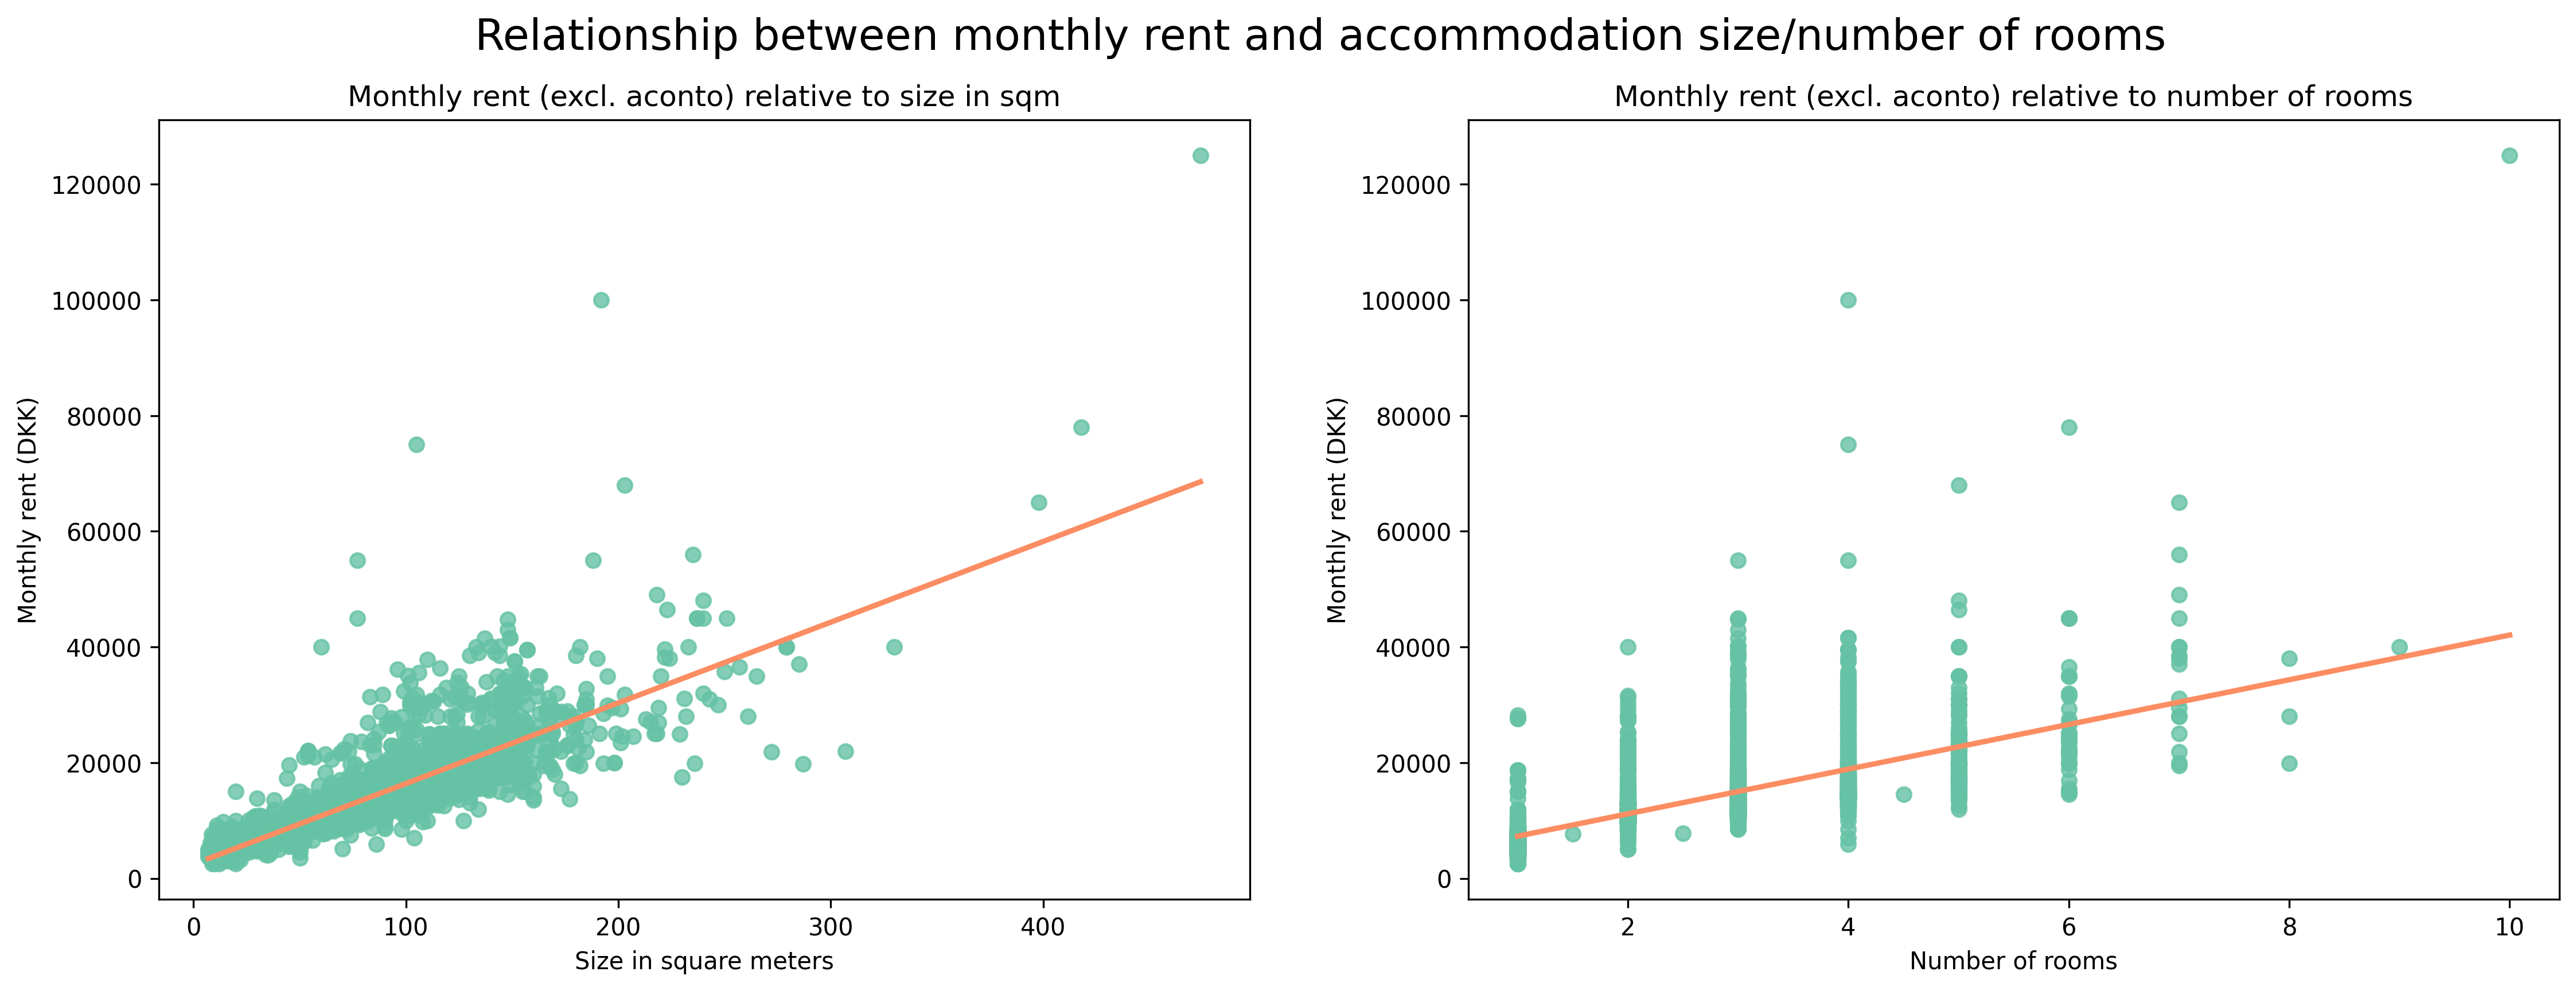

In [ ]:
# Preparing area for plotting of data
fig = plt.figure(figsize = (18, 6), dpi = 300)

# Making the 1st plot
ax1 = plt.subplot2grid((1, 2), (0, 0))
Plot1 = sns.regplot(x = DataForChart["SizeSquareMeters"], y = DataForChart["MonthlyRent"], ci = None, color = "#66C2A5", line_kws = {"color":"#FC8D62"})
plt.title("Monthly rent (excl. aconto) relative to size in sqm")
plt.xlabel("Size in square meters")
plt.ylabel("Monthly rent (DKK)")

# Making the 2nd plot
ax1 = plt.subplot2grid((1, 2), (0, 1))
Plot1 = sns.regplot(x = DataForChart["NumberOfRooms"], y = DataForChart["MonthlyRent"], ci = None, color = "#66C2A5", line_kws = {"color":"#FC8D62"})
plt.title("Monthly rent (excl. aconto) relative to number of rooms")
plt.xlabel("Number of rooms")
plt.ylabel("Monthly rent (DKK)")

# Finalizing output
plt.suptitle("Relationship between monthly rent and accommodation size/number of rooms", fontsize = 18)
plt.show()

### Is it cheaper to live in a bigger place, judging by the price per square meter?

Below, we plot the price of monthly rent (pre-adjusted for the size of the accommodation measured in square meters) against both the number of square meters and against the number of rooms available.

**The figures below give us the following insights:**

* There appears to be a negative relationship between the size of the accommodation and the rent price per sqm. This is the case both when we measure the size in square meters and in number of rooms.
* Interestingly, the relationship is rather of an exponential character. This means that by choosing to go for a bigger accommodation, you might expect to pay a lower price per square meter, although the biggest reduction in the price per square meter can be found at the lower end of the spectrum: e.g. moving from a one-room accommodation to a two-rooms accommodation will result in a bigger drop in the price per sqm than moving from a two-rooms accommodation to a three-rooms accommodation.
* Once again, the relationship between rent and size as measured in square meters is found to be stronger than the relationship between rent and size as measured by the number of rooms available.

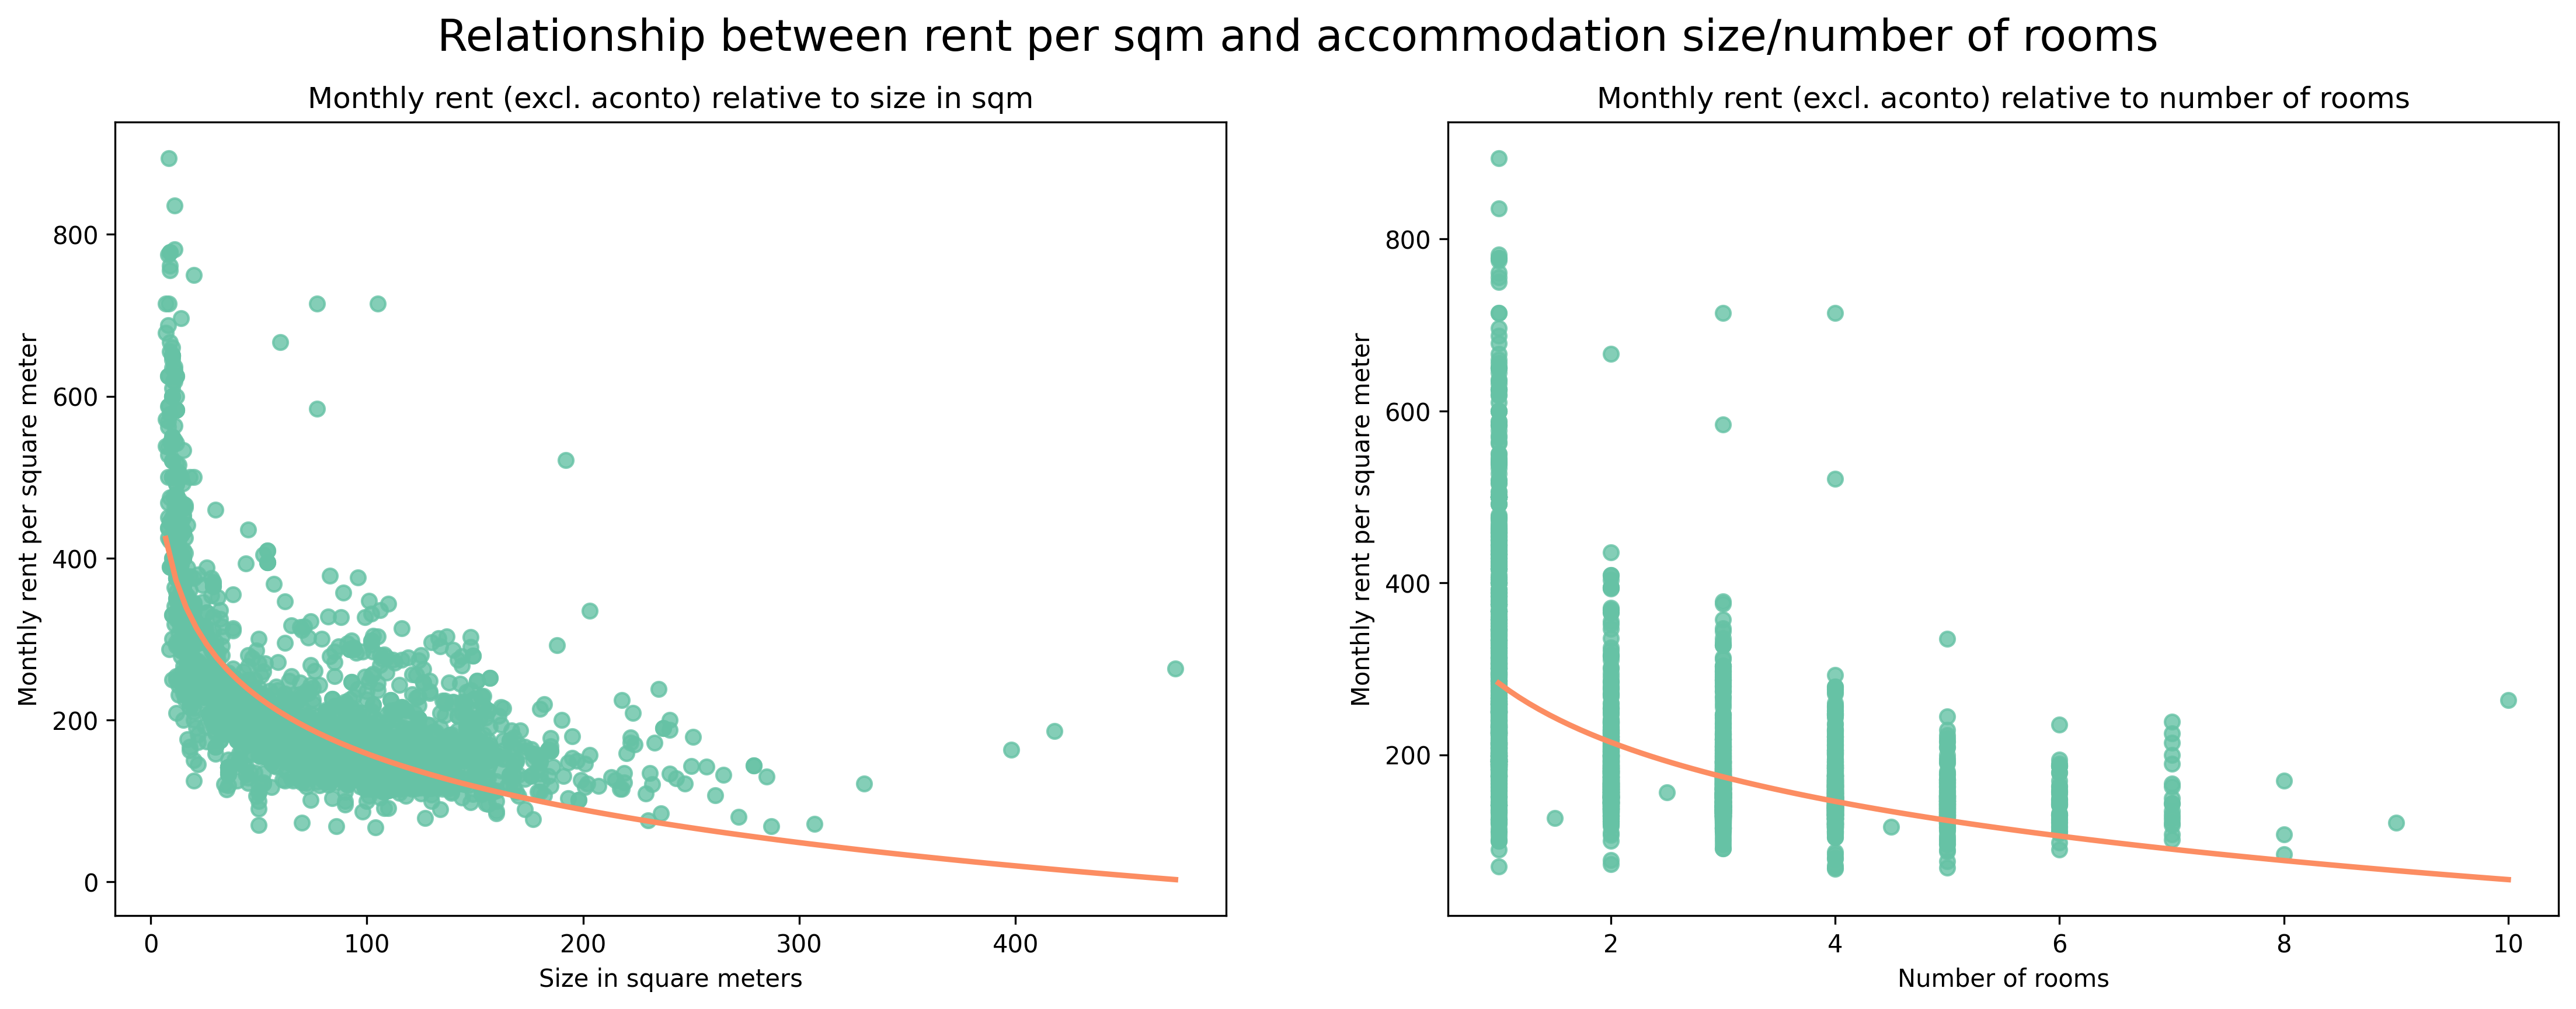

In [ ]:
# Preparing area for plotting of data
fig = plt.figure(figsize = (18, 6), dpi = 300)

# Making the 1st plot
ax1 = plt.subplot2grid((1, 2), (0, 0))
Plot1 = sns.regplot(x = DataForChart["SizeSquareMeters"], y = DataForChart["MonthlyRentBySqM"], ci = None, logx = True, color = "#66C2A5", line_kws = {"color":"#FC8D62"})
plt.title("Monthly rent (excl. aconto) relative to size in sqm")
plt.xlabel("Size in square meters")
plt.ylabel("Monthly rent per square meter")

# Making the 2nd plot
ax1 = plt.subplot2grid((1, 2), (0, 1))
Plot1 = sns.regplot(x = DataForChart["NumberOfRooms"], y = DataForChart["MonthlyRentBySqM"], ci = None, logx = True, color = "#66C2A5", line_kws = {"color":"#FC8D62"})
plt.title("Monthly rent (excl. aconto) relative to number of rooms")
plt.xlabel("Number of rooms")
plt.ylabel("Monthly rent per square meter")

# Finalizing output
plt.suptitle("Relationship between rent per sqm and accommodation size/number of rooms", fontsize = 18)
plt.show()